**Table of contents**<a id='toc0_'></a>    
- [Initial Tests with OFC](#toc1_)    
  - [Plotting PSD](#toc1_1_)    
  - [Getting FlatComb](#toc1_2_)    
- [Neural Network Training - PyTorch](#toc2_)    
  - [Datasets](#toc2_1_)    
    - [Add FlatCombs](#toc2_1_1_)    
    - [Split Dataset in Training, Validation and Test](#toc2_1_2_)    
  - [Forward Network](#toc2_2_)    
    - [Test Phase](#toc2_2_1_)    
  - [Inverse Network](#toc2_3_)    
    - [Test Phase](#toc2_3_1_)    
  - [Inverse Network - Differentiable OFC Generator](#toc2_4_)    
    - [Test phase](#toc2_4_1_)    
- [Bayesian Optimization](#toc3_)    
  - [Forward Network](#toc3_1_)    
  - [Inverse Network](#toc3_2_)    
  - [Inverse Network - Differentiable OFC Generator](#toc3_3_)    
- [Optuna Optimization](#toc4_)    
  - [Forward Network](#toc4_1_)    
  - [Inverse Network](#toc4_2_)    
  - [Inverse Network - Differentiable OFC Generator](#toc4_3_)    
- [Other Auxiliar Figures](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# TODO: adicionar duas variáveis de número de picos, 
# número de pontos a serem extraídos do comb na geração 
# do dataset e número de pontos a serem usados no treinamento
# n_collected_peaks = 101 # Number of peaks to be collected from the comb in the generation of the dataset
# n_training_peaks = 11 # Number of peaks to be used in the training

# TODO: na comparação mostrar não apenas 11 picos (n_training_peaks) mas também alguns picos laterais

# TODO: Verificar se não faz mais sentido:
#  - treinar a rede com zero_mean = False e adicionar variável de potência do sinal no treinamento
#  - retirar variáveis de fase dos moduladores
#  - duplicar frequência no último sinal de controle?
#  - adicionar ruído gaussiano ao sinal de controle
#  - adicionar modelo de laser


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
from ofc_functions import *
from nn_functions import *
import os, glob

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
#set rc parameters
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'axes.titlesize': 16})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.loc': "upper right"})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'axes.grid': True})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'lines.linestyle': "-"})
plt.rcParams.update({'grid.alpha': 0.7})
plt.rcParams.update({'grid.color': "gray"})
plt.rcParams.update({'grid.linestyle': "--"})
plt.rcParams.update({'grid.linewidth': 1})
plt.rcParams.update({'figure.autolayout': False})

In [4]:
#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device} mãe")

Runnning in cuda mãe


In [5]:
# Parameters for the OFC signal
ofc_args = parameters()
ofc_args.SpS  = 64 # (int) Samples per symbol. Determines the window size
ofc_args.Rs   = 10e9 # (float) Symbol rate (baud rate - symbols per second)
ofc_args.Ts   = 1/ofc_args.Rs # (float) Symbol period (s)
ofc_args.Fa   = 1/(ofc_args.Ts/ofc_args.SpS)  # (float) Sampling frequency of the signal (samples per second)
ofc_args.Ta   = 1/ofc_args.Fa   # (float) Sampling period of the signal (s)
ofc_args.NFFT = ofc_args.SpS*2   # (int) Number of points of the FFT (multiple of SpS) 
ofc_args.t    = ofc_args.Ta*torch.arange(0, ofc_args.SpS*10 + 1).unsqueeze(0) # (device = 'cpu') Time vector for the signal (s)
ofc_args.Vpi  = 2.0           # (float) Voltage required to achieve a π phase shift (V)
#ofc_args.Vpi_DDMZM = 3.5     # (float) Voltage required to achieve a π phase shift (V)
#ofc_args.Vpi_MZM   = 5.5     # (float) Voltage required to achieve a π phase shift (V)
#ofc_args.Vpi_PM    = 3.5     # (float) Voltage required to achieve a π phase shift (V)
#ofc_args.P = 1e-3*10**(10/10)  # (float) Power of the signal (W) --> 10 dBm
ofc_args.n_peaks = 11 # (int) Number of peaks to be found in the signal

# Parameters for the modulators cascaded
mod_args = parameters()
mod_args.P_min = 1e-3*10**(-10/10) # Minimum power (W) --> -10 dBm
mod_args.P_max = 1e-3*10**( 10/10)  # Maximum power (W) -->  10 dBm
mod_args.V_min = -3    # Minimum amplitude voltage (V)
mod_args.V_max = 3     # Maximum amplitude voltage (V)
mod_args.Phase_min = 0 # Minimum phase (rad)
mod_args.Phase_max = 2*torch.pi # Maximum phase (rad) --> Phase is periodic with period 2*π
mod_args.Vb_min = 0  # Minimum bias voltage (V)
mod_args.Vb_max = 2*ofc_args.Vpi   # Maximum bias voltage (V) --> Vb is periodic with period 2*Vπ for DDMZM and PM-PM-MZM

#mod_args.bounds = [(mod_args.V_min,  mod_args.V_max),  (mod_args.V_min,  mod_args.V_max),  
#                   (mod_args.Vb_min, mod_args.Vb_max), (mod_args.Vb_min, mod_args.Vb_max),
#                   (mod_args.P_min,  mod_args.P_max)] # Bounds of the parameters (DDMZM)

mod_args.bounds = [(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max), 
                  (mod_args.Phase_min, mod_args.Phase_max),(mod_args.Phase_min, mod_args.Phase_max), (mod_args.Phase_min, mod_args.Phase_max),
                  (mod_args.Vb_min,mod_args.Vb_max)] # Bounds of the parameters (PM-PM-MZM)

mod_args.bounds = [(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max), 
                   (mod_args.Phase_min, mod_args.Phase_max),(mod_args.Phase_min, mod_args.Phase_max), (mod_args.Phase_min, mod_args.Phase_max),
                   (mod_args.Vb_min,mod_args.Vb_max), (mod_args.Vb_min,mod_args.Vb_max)] # Bounds of the parameters (PM-MZM-MZM)

freqs_peaks_GHz = torch.linspace(-(ofc_args.n_peaks//2), ofc_args.n_peaks//2, ofc_args.n_peaks) # Frequency range in GHz for n_peaks


# <a id='toc1_'></a>[Initial Tests with OFC](#toc0_)

## <a id='toc1_1_'></a>[Plotting PSD](#toc0_)

In [16]:
#def plot_signalPower_and_frequencyComb(V1, V2, Vb1, Vb2, P):
#def plot_signalPower_and_frequencyComb(V1, V2, V3, Phase1, Phase2, Phase3, Vb3):
def plot_signalPower_and_frequencyComb(V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3):
    
    #params = V1, V2, Vb1, Vb2, P
    #params = V1, V2, V3, Phase1, Phase2, Phase3, Vb3
    params = V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3
    
    params = torch.tensor(params).unsqueeze(0)

    #frequencyComb = frequencyCombGenerator_DDMZM(params, ofc_args.Rs, ofc_args.t, ofc_args.Vpi)
    #frequencyComb = frequencyCombGenerator_PM_PM_MZM(params, ofc_args.Rs, ofc_args.t, ofc_args.Vpi)
    frequencyComb = frequencyCombGenerator_PM_MZM_MZM(params, ofc_args.Rs, ofc_args.t, ofc_args.Vpi)

    _, ax = plt.subplots(2,3,figsize = (14,6))

    power = torch.abs(frequencyComb.squeeze())**2
    powerdBm = 10*torch.log10(power/1e-3)

    ax[0,0].plot(ofc_args.t.squeeze()[:ofc_args.SpS*4]*1e9, power[:ofc_args.SpS*4]*1e6, label = "Optical Signal")
    #ax[0,0].set_xlabel("Time (ns)")
    ax[0,0].set_ylabel("Power (μW)")
    ax[0,0].set_xlim(0,4*ofc_args.Ts*1e9)
    ax[0,0].set_ylim(0,100)

    ax[1,0].plot(ofc_args.t.squeeze()[:ofc_args.SpS*4]*1e9, powerdBm[:ofc_args.SpS*4], label = "Optical Signal")
    ax[1,0].set_xlabel("Time (ns)")
    ax[1,0].set_ylabel("Power (dBm)")
    ax[1,0].set_xlim(0,4*ofc_args.Ts*1e9)
    ax[1,0].set_ylim(-60,-10)

    phase = np.unwrap(torch.angle(frequencyComb.squeeze()))
    ax[0,2].plot(ofc_args.t.squeeze()[:ofc_args.SpS*4]*1e9, phase[:ofc_args.SpS*4], label = "Optical Signal")
    ax[0,2].set_xlabel("Time (ns)")
    ax[0,2].set_ylabel("Phase (rad)")
    ax[0,2].set_xlim(0,4*ofc_args.Ts*1e9)
    ax[0,2].set_ylim(-5*torch.pi,5*torch.pi)
    
    Pxx, freqs = get_psd_ByFFT(frequencyComb, ofc_args.Fa, ofc_args.NFFT)
    log_Pxx = 10*torch.log10(Pxx)
    peaks, indx = get_indx_peaks(log_Pxx, ofc_args.NFFT/ofc_args.SpS, ofc_args.n_peaks)

    ax[0,1].plot(freqs.squeeze()/ofc_args.Rs, Pxx.squeeze(), label = "Optical Signal Spectrum")
    ax[0,1].plot(freqs[indx].squeeze()/ofc_args.Rs, Pxx.squeeze()[indx].to("cpu"), 'o')
    #ax[0,1].set_xlabel(r"Frequency (GHz/$Rs$)");
    ax[0,1].set_ylabel("Power (W/Hz)")
    ax[0,1].set_xlim(-ofc_args.n_peaks//2-3,ofc_args.n_peaks//2+3)
    ax[0,1].set_ylim(-1e-15,7e-15)

    ax[1,1].plot(freqs.squeeze()/ofc_args.Rs, log_Pxx.squeeze(), label = "Optical Signal Spectrum")
    ax[1,1].plot(freqs[indx].squeeze()/ofc_args.Rs, peaks.squeeze(), 'o')
    ax[1,1].set_xlabel(r"Frequency (GHz/$Rs$)");
    ax[1,1].set_ylabel("Power (dB/Hz)")
    ax[1,1].set_xlim(-ofc_args.n_peaks//2-3,ofc_args.n_peaks//2+3)
    ax[1,1].set_ylim(-250,-100)
    
    mean = torch.mean(peaks.squeeze())
    var = torch.var(peaks.squeeze())

    x_array = torch.tensor([freqs.squeeze()[0],freqs[-1].squeeze()])/ofc_args.Rs
    ax[1,1].plot(x_array, torch.tensor([1,1])*mean, "--",label = "peaks mean")
    ax[1,1].plot(x_array, torch.tensor([1,1])*(mean+torch.sqrt(var)), "--",label = "peaks max")
    ax[1,1].plot(x_array, torch.tensor([1,1])*(mean-torch.sqrt(var)), "--",label = "peaks min")

    ax[1,2].axis('off')
    ax[1,2].text(0, 0.7, "Mean: %.2f dB" %mean, fontsize=11)
    ax[1,2].text(0, 0.6, "Standard Deviation: %.2f dB" %torch.sqrt(var), fontsize=11)
    ax[1,2].text(0, 0.4, "Variance: %.4f dB^2"%var, fontsize=12)
    ax[1,2].text(0, 0.3, "max - min: %.4f dB" %(torch.max(peaks.squeeze()) - torch.min(peaks.squeeze())), fontsize=12)

    plt.tight_layout(w_pad=0.2, h_pad=0.2)
    plt.show()

In [ ]:
import ipywidgets as widgets

#initial_values = [2.93237115, 0.91575905, 2.68277089, 2.20521903, 0.00999964]
initial_values = [1, 1, 1, np.pi, 0, 0, 2]
initial_values = [ 2.39532993e+00,  2.14083606e+00,  1.74865649e+00,  3.09513887e+00, 3.09518252e+00,  3.09526099e+00,  3.00775498e+00, -1.11022302e-20]

V1     = widgets.FloatSlider(value=initial_values[0], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V1')
V2     = widgets.FloatSlider(value=initial_values[1], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V2')
V3     = widgets.FloatSlider(value=initial_values[2], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V3')
Phase1 = widgets.FloatSlider(value=initial_values[3], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase1')
Phase2 = widgets.FloatSlider(value=initial_values[4], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase2')
Phase3 = widgets.FloatSlider(value=initial_values[5], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase3')
Vb3    = widgets.FloatSlider(value=initial_values[7], min=mod_args.Vb_min,    max=mod_args.Vb_max,   step = 0.001, description = 'Vb3')
Vb2    = widgets.FloatSlider(value=initial_values[6], min=mod_args.Vb_min,    max=mod_args.Vb_max,   step = 0.001, description = 'Vb2')

ui1 = widgets.HBox([V1, V2, V3])
ui2 = widgets.HBox([Vb3, Vb2])
ui3 = widgets.HBox([Phase1, Phase2, Phase3])

#out1 = widgets.interactive_output(plot_signalPower_and_frequencyComb, {'V1': V1, 'V2': V2,'Vb1':Vb1,'Vb2': Vb2, 'P': P})
#out1 = widgets.interactive_output(plot_signalPower_and_frequencyComb, {'V1': V1, 'V2': V2, 'V3':V3, "Phase1":Phase1, "Phase2":Phase2, "Phase3":Phase3, 'Vb3': Vb3})
out1 = widgets.interactive_output(plot_signalPower_and_frequencyComb, {'V1': V1, 'V2': V2, 'V3':V3, "Phase1":Phase1, "Phase2":Phase2, "Phase3":Phase3, 'Vb2':Vb2, 'Vb3': Vb3})

display(ui1, ui2, ui3, out1)

Output()

## <a id='toc1_2_'></a>[Getting FlatComb](#toc0_)

In [19]:

# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [3, 1, 3, 2, 0.01]
initial_guess = [2, -1, 3, 2, 1, 1, 1]
initial_guess = [1.5, 1.5, 1.5, np.pi, np.pi, np.pi, 3, 0]

ofc_args.t    =  ofc_args.t.numpy().astype(np.float64)
optimized_params,_, _ = optimization_flatComb_numpy(initial_guess, args = ofc_args, bounds = mod_args.bounds, n_max = 5, method = "COBYLA")
ofc_args.t    = torch.tensor(ofc_args.t, dtype=torch.float32)

#V1, V2, Vb1, Vb2, P = optimized_params
#V1, V2, V3, Phase1, Phase2, Phase3, Vb3 = optimized_params
V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.4f} V")
print(f"V2: {V2:.4f} V")
print(f"V3: {V3:.4f} V")
print(f"Phase1: {Phase1:.4f} rad")
print(f"Phase2: {Phase2:.4f} rad")
print(f"Phase3: {Phase3:.4f} rad")
print(f"Vb2: {Vb2:.4f} V")
print(f"Vb3: {Vb3:.4f} V")
#print(f"P: {P:.4f} W")

Configurações otimizadas:
V1: 2.3948 V
V2: 2.1275 V
V3: 1.7539 V
Phase1: 3.1048 rad
Phase2: 3.1049 rad
Phase3: 3.1049 rad
Vb2: 2.9974 V
Vb3: 0.0006 V


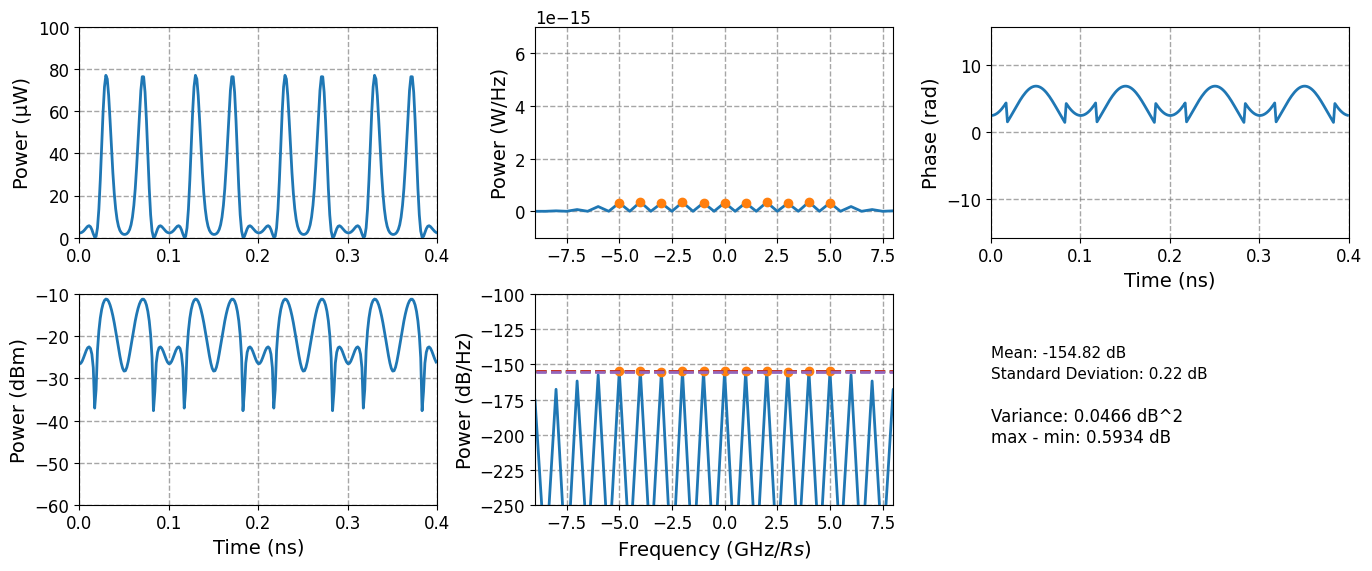

In [20]:
plot_signalPower_and_frequencyComb(*optimized_params)

# <a id='toc2_'></a>[Neural Network Training - PyTorch](#toc0_)

## <a id='toc2_1_'></a>[Datasets](#toc0_)

In [6]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

n_samples = 300000

if train_ratio + val_ratio + test_ratio > 1:
    raise ValueError("The sum of the ratios must be less than or equal to 1")

In [7]:
#load datasets if they exist, create them otherwise
datasets_folder = "saved_data/datasets/"
#gen = "ddmzm_"
#gen = "pm_pm_mzm_"
gen = "pm_mzm_mzm_"
zero_mean = True

dataset_name = gen + f"{n_samples*1e-3:.0f}k_samples_{zero_mean}ZeroMean"
dataset_filename = datasets_folder + dataset_name + ".pt"

if os.path.exists(dataset_filename):
    print("Loading dataset...")
    dataset = torch.load(dataset_filename, weights_only=False)
    dataset.input_tensors = dataset.input_tensors.to(device)
    dataset.output_tensors = dataset.output_tensors.to(device)
    print("Datasets loaded!")
else:
    print("Creating dataset...")
    dataset = FrequencyCombDataset(frequencyCombPeaks, n_samples, ofc_args, mod_args.bounds, device = device, zero_mean=zero_mean)
    print("Datasets created!")

    # Save the dataset
    torch.save(dataset, dataset_filename)
    
    print("Dataset saved!")


Loading dataset...
Datasets loaded!


### <a id='toc2_1_1_'></a>[Add FlatCombs](#toc0_)

In [8]:
files = glob.glob(datasets_folder + gen + 'flatComb_*')
if len(files) > 0:
    print("Loading flatComb datasets...")
    flatComb_inputs0_1dB = np.load(glob.glob(datasets_folder + gen + "flatComb_inputs0_1dB_*")[0]).squeeze()
    flatComb_outputs0_1dB = np.load(glob.glob(datasets_folder + gen + "flatComb_outputs0_1dB_*")[0]).squeeze()

    flatComb_inputs1_5dB = np.load(glob.glob(datasets_folder + gen + "flatComb_inputs1_5dB_*")[0]).squeeze()
    flatComb_outputs1_5dB = np.load(glob.glob(datasets_folder + gen + "flatComb_outputs1_5dB_*")[0]).squeeze()

    for file in files:
        print(file) 
    print("FlatComb datasets loaded!")

else:
    max_flat_samples = 10000

    print("Creating flatComb datasets...")
    
    ofc_args.t    =  ofc_args.t.numpy().astype(np.float64) #convert t to numpy array
    flatComb_inputs0_1dB, flatComb_outputs0_1dB, flatComb_inputs1_5dB, flatComb_outputs1_5dB = create_flatCombs_numpy(max_flat_samples, args = ofc_args, bounds = mod_args.bounds, method = "COBYLA")
    ofc_args.t    = torch.tensor(ofc_args.t, dtype=torch.float32) #convert t back to torch tensor

    #save flatComb_inputs and flatComb_outputs
    np.save(datasets_folder + gen + f"flatComb_inputs0_1dB_{len(flatComb_inputs0_1dB)}.npy", flatComb_inputs0_1dB)
    np.save(datasets_folder + gen + f"flatComb_outputs0_1dB_{len(flatComb_outputs0_1dB)}.npy", flatComb_outputs0_1dB)

    np.save(datasets_folder + gen + f"flatComb_inputs1_5dB_{len(flatComb_inputs1_5dB)}.npy", flatComb_inputs1_5dB)
    np.save(datasets_folder + gen + f"flatComb_outputs1_5dB_{len(flatComb_outputs1_5dB)}.npy", flatComb_outputs1_5dB)

    print("FlatComb datasets created and saved!")

Loading flatComb datasets...
saved_data/datasets\pm_pm_mzm_flatComb_inputs0_1dB_659.npy
saved_data/datasets\pm_pm_mzm_flatComb_inputs1_5dB_8866.npy
saved_data/datasets\pm_pm_mzm_flatComb_outputs0_1dB_659.npy
saved_data/datasets\pm_pm_mzm_flatComb_outputs1_5dB_8866.npy
FlatComb datasets loaded!


In [9]:
p0_1 = 0.04 #percentage of flatComb0_1 desired in the dataset
p1_5 = 0.02 #percentage of flatComb1_5 desired in the dataset

flat_nsamples0_1 = int(p0_1*n_samples/(1 - p0_1 - p1_5))
flat_nsamples1_5 = int(p1_5*n_samples/(1 - p1_5 - p0_1))

flat_nsamples0_1 = 659
flat_nsamples1_5 = 659

flat_nsamples_idx0_1 = np.arange(flat_nsamples0_1)
flat_nsamples_idx1_5 = np.arange(flat_nsamples1_5)
flatComb_0_1dB_dataset = FrequencyCombDataset(flatComb_inputs0_1dB[flat_nsamples_idx0_1], flatComb_outputs0_1dB[flat_nsamples_idx0_1], device = device, norm_scales=dataset.norm_scales, zero_mean=dataset.zero_mean)
flatComb_1_5dB_dataset = FrequencyCombDataset(flatComb_inputs1_5dB[flat_nsamples_idx1_5], flatComb_outputs1_5dB[flat_nsamples_idx1_5], device = device, norm_scales=dataset.norm_scales, zero_mean=dataset.zero_mean)

In [10]:
dataset.concat_with(flatComb_0_1dB_dataset, flatComb_1_5dB_dataset, recalc_norm_scales = True)

In [15]:
#pencentage of flatcombs

count01 = 0
count15 = 0

for i in range(len(dataset)):
    min_val = dataset.denormalize(torch.min(dataset.output_tensors[i]))
    max_val = dataset.denormalize(torch.max(dataset.output_tensors[i]))
    if max_val - min_val < 1.0:
        count01 += 1
    elif max_val - min_val < 5.0:
        count15 += 1
print(f"Percentage of flatcombs0_1 in train dataset: {count01/len(dataset)*100:.2f}%")
print(f"Percentage of flatcombs1_5 in train dataset: {count15/len(dataset)*100:.2f}%")

Percentage of flatcombs0_1 in train dataset: 0.19%
Percentage of flatcombs1_5 in train dataset: 0.81%


### <a id='toc2_1_2_'></a>[Split Dataset in Training, Validation and Test](#toc0_)

In [8]:
# split dataset into train, validation and test
train_dataset, val_dataset, test_dataset = dataset.split_dataset([train_ratio, val_ratio, test_ratio], shuffle = True)

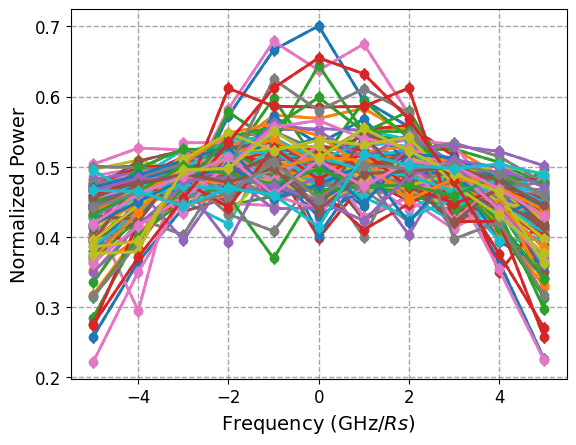

In [9]:
#verifing if frequencyCombPeaks can generate the same frequencyComb as the dataset

inputs = dataset.input_tensors[0:100]
targets = dataset.output_tensors[0:100]

#outputs = frequencyCombPeaks(inputs.to("cpu"), ofc_args)
outputs = frequencyCombPeaks(inputs.to("cpu"), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)

if dataset.zero_mean:
    outputs = outputs - torch.mean(outputs, dim=1).unsqueeze(1)
outputs = dataset.normalize(outputs)

for i in range(100):
    plt.plot(freqs_peaks_GHz, outputs[i].cpu().numpy(), "d-", color = f"C{i}")
    plt.plot(freqs_peaks_GHz, targets[i].cpu().numpy(), "o--", color = f"C{i}")
plt.xlabel(r"Frequency (GHz/$Rs$)");
plt.ylabel("Normalized Power");


## <a id='toc2_2_'></a>[Forward Network](#toc0_)

In [115]:
# Create data loaders
batch_size = 85
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

#flat_loader = DataLoader(flatComb_0_1dB_dataset, batch_size = batch_size, shuffle=True)

In [116]:
# Initialize the model
n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]
architecture = [n_inputs, 176, 176, 176, 176, 176, 176, 176, 176, n_outputs]

forward_net = FrequencyCombNet(architecture).to(device)
forward_net_name = "model_forward_" + "_".join([f"{n:.0f}" for n in architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"
forward_net_path = "saved_data/models/"+ forward_net_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
for_optimizer = torch.optim.Adam(forward_net.parameters(), lr = 8.5e-5) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(forward_net_path):
    print("Loading model...")
    checkpoint = torch.load(forward_net_path, map_location=torch.device(device), weights_only=True) # Load only the model and optimizer states (weights_only=False)
    forward_net.load_state_dict(checkpoint['model_state_dict'])
    for_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

Loading model...
Model and Optimizer loaded!


In [99]:
#architecture = [8, 296, 296, 296, 296, 296, 296, 11]
calc_num_params(architecture)

221419

In [100]:
## losses
for_losses_path = "saved_data/losses/" + forward_net_name + '_losses.npz'

# Load training losses if file exists
if os.path.exists(for_losses_path):
    losses = np.load(for_losses_path)
    train_losses = list(losses['train_losses'])
    val_losses = list(losses['val_losses'])
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

val_loss_min = 1

Losses files not found.
Losses files created!


Validation loss decreased (1.000000 --> 0.000881). Epoch: 1. Saving model...
Validation loss decreased (0.000881 --> 0.000655). Epoch: 2. Saving model...
Validation loss decreased (0.000655 --> 0.000600). Epoch: 3. Saving model...
Validation loss decreased (0.000600 --> 0.000571). Epoch: 4. Saving model...
Validation loss decreased (0.000571 --> 0.000567). Epoch: 5. Saving model...
Validation loss decreased (0.000567 --> 0.000533). Epoch: 6. Saving model...
Validation loss decreased (0.000533 --> 0.000524). Epoch: 7. Saving model...
Validation loss decreased (0.000524 --> 0.000505). Epoch: 8. Saving model...
Validation loss decreased (0.000505 --> 0.000473). Epoch: 9. Saving model...
Validation loss decreased (0.000473 --> 0.000456). Epoch: 10. Saving model...
Validation loss decreased (0.000456 --> 0.000445). Epoch: 11. Saving model...
Validation loss decreased (0.000445 --> 0.000425). Epoch: 13. Saving model...
Validation loss decreased (0.000425 --> 0.000413). Epoch: 14. Saving mode

Validation loss decreased (0.000229 --> 0.000227). Epoch: 102. Saving model...
Validation loss decreased (0.000227 --> 0.000225). Epoch: 105. Saving model...
Validation loss decreased (0.000225 --> 0.000223). Epoch: 106. Saving model...
Validation loss decreased (0.000223 --> 0.000220). Epoch: 109. Saving model...
Validation loss decreased (0.000220 --> 0.000218). Epoch: 110. Saving model...
Validation loss decreased (0.000218 --> 0.000217). Epoch: 112. Saving model...
Validation loss decreased (0.000217 --> 0.000216). Epoch: 114. Saving model...
Validation loss decreased (0.000216 --> 0.000216). Epoch: 115. Saving model...
Validation loss decreased (0.000216 --> 0.000215). Epoch: 116. Saving model...
Validation loss decreased (0.000215 --> 0.000215). Epoch: 118. Saving model...
Validation loss decreased (0.000215 --> 0.000214). Epoch: 120. Saving model...
Validation loss decreased (0.000214 --> 0.000213). Epoch: 123. Saving model...
Validation loss decreased (0.000213 --> 0.000212). E

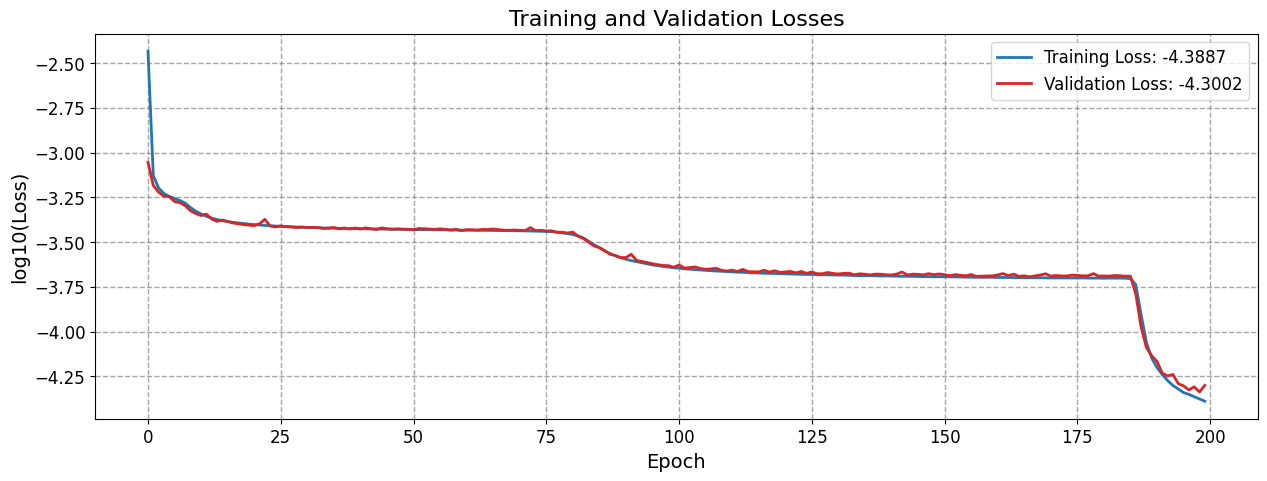

Validation loss decreased (0.000046 --> 0.000044). Epoch: 201. Saving model...
Validation loss decreased (0.000044 --> 0.000041). Epoch: 202. Saving model...
Validation loss decreased (0.000041 --> 0.000039). Epoch: 206. Saving model...
Validation loss decreased (0.000039 --> 0.000039). Epoch: 208. Saving model...
Validation loss decreased (0.000039 --> 0.000037). Epoch: 209. Saving model...
Validation loss decreased (0.000037 --> 0.000036). Epoch: 216. Saving model...
Validation loss decreased (0.000036 --> 0.000035). Epoch: 218. Saving model...
Validation loss decreased (0.000035 --> 0.000034). Epoch: 221. Saving model...
Validation loss decreased (0.000034 --> 0.000034). Epoch: 223. Saving model...
Validation loss decreased (0.000034 --> 0.000031). Epoch: 227. Saving model...
Validation loss decreased (0.000031 --> 0.000030). Epoch: 233. Saving model...
Validation loss decreased (0.000030 --> 0.000029). Epoch: 245. Saving model...
Validation loss decreased (0.000029 --> 0.000028). E

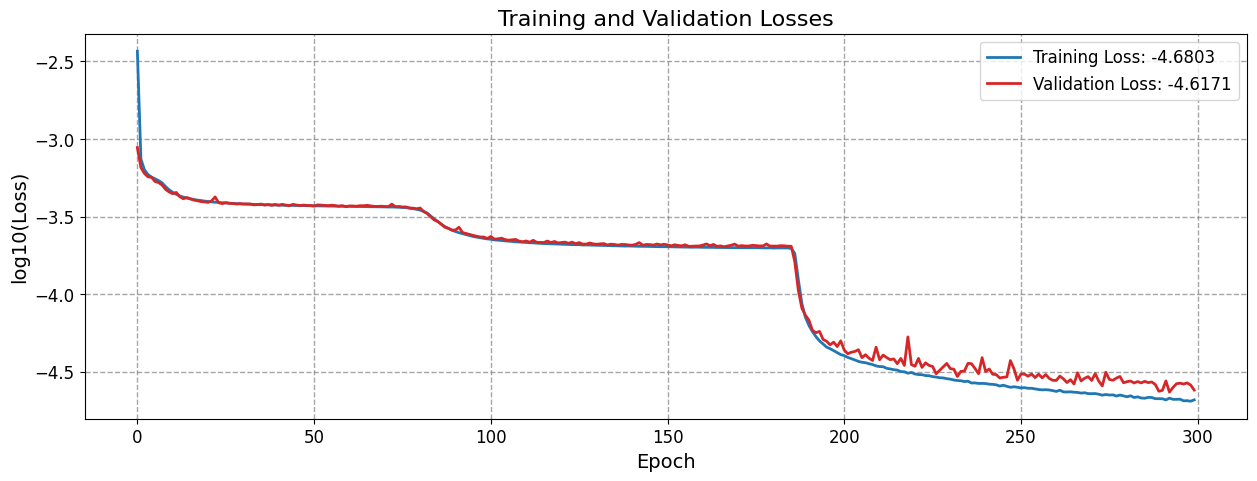

Validation loss decreased (0.000023 --> 0.000023). Epoch: 323. Saving model...
Validation loss decreased (0.000023 --> 0.000021). Epoch: 341. Saving model...
Validation loss decreased (0.000021 --> 0.000021). Epoch: 364. Saving model...
Validation loss decreased (0.000021 --> 0.000021). Epoch: 378. Saving model...
Validation loss decreased (0.000021 --> 0.000020). Epoch: 396. Saving model...
Validation loss decreased (0.000020 --> 0.000020). Epoch: 399. Saving model...
Validation loss decreased (0.000020 --> 0.000019). Epoch: 400. Saving model...
Epoch: 400/1000... Training loss: 0.566310 (dB/Hz)^2 ... Validation Loss: 0.694390 (dB/Hz)^2


Validation loss decreased (0.000019 --> 0.000019). Epoch: 419. Saving model...
Validation loss decreased (0.000019 --> 0.000019). Epoch: 443. Saving model...
Validation loss decreased (0.000019 --> 0.000019). Epoch: 455. Saving model...
Validation loss decreased (0.000019 --> 0.000019). Epoch: 473. Saving model...
Validation loss decreased (0.000019 --> 0.000018). Epoch: 484. Saving model...
Epoch: 500/1000... Training loss: 0.466376 (dB/Hz)^2 ... Validation Loss: 0.679985 (dB/Hz)^2


Validation loss decreased (0.000018 --> 0.000018). Epoch: 502. Saving model...
Validation loss decreased (0.000018 --> 0.000018). Epoch: 512. Saving model...
Validation loss decreased (0.000018 --> 0.000018). Epoch: 514. Saving model...
Validation loss decreased (0.000018 --> 0.000018). Epoch: 518. Saving model...
Validation loss decreased (0.000018 --> 0.000018). Epoch: 529. Saving model...
Validation loss decreased (0.000018 --> 0.000018). Epoch: 546. Saving model...
Validation loss decreased (0.000018 --> 0.000018). Epoch: 550. Saving model...
Validation loss decreased (0.000018 --> 0.000018). Epoch: 563. Saving model...
Validation loss decreased (0.000018 --> 0.000017). Epoch: 586. Saving model...
Validation loss decreased (0.000017 --> 0.000016). Epoch: 587. Saving model...
Epoch: 600/1000... Training loss: 0.408376 (dB/Hz)^2 ... Validation Loss: 0.638237 (dB/Hz)^2


Validation loss decreased (0.000016 --> 0.000016). Epoch: 604. Saving model...
Validation loss decreased (0.000016 --> 0.000016). Epoch: 651. Saving model...
Validation loss decreased (0.000016 --> 0.000016). Epoch: 663. Saving model...
Validation loss decreased (0.000016 --> 0.000016). Epoch: 672. Saving model...
Epoch: 700/1000... Training loss: 0.350645 (dB/Hz)^2 ... Validation Loss: 0.613369 (dB/Hz)^2


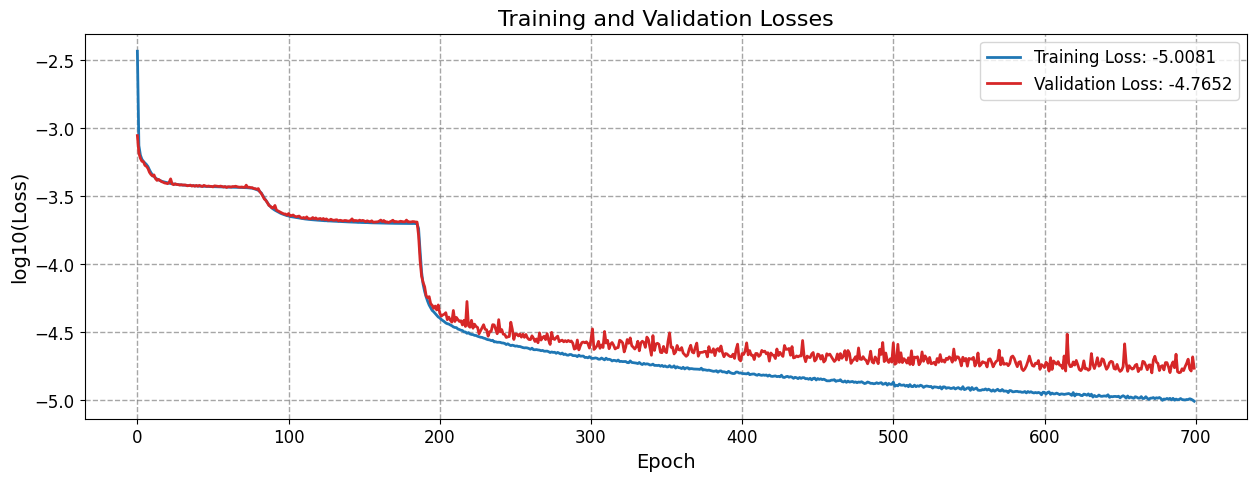

Validation loss decreased (0.000016 --> 0.000015). Epoch: 714. Saving model...
Validation loss decreased (0.000015 --> 0.000015). Epoch: 724. Saving model...
Validation loss decreased (0.000015 --> 0.000015). Epoch: 729. Saving model...
Validation loss decreased (0.000015 --> 0.000015). Epoch: 760. Saving model...
Epoch: 800/1000... Training loss: 0.311006 (dB/Hz)^2 ... Validation Loss: 0.541316 (dB/Hz)^2


Validation loss decreased (0.000015 --> 0.000015). Epoch: 801. Saving model...
Validation loss decreased (0.000015 --> 0.000015). Epoch: 805. Saving model...
Validation loss decreased (0.000015 --> 0.000015). Epoch: 843. Saving model...
Validation loss decreased (0.000015 --> 0.000014). Epoch: 856. Saving model...
Validation loss decreased (0.000014 --> 0.000014). Epoch: 859. Saving model...
Validation loss decreased (0.000014 --> 0.000014). Epoch: 873. Saving model...
Validation loss decreased (0.000014 --> 0.000014). Epoch: 892. Saving model...
Epoch: 900/1000... Training loss: 0.299454 (dB/Hz)^2 ... Validation Loss: 0.545542 (dB/Hz)^2


Validation loss decreased (0.000014 --> 0.000014). Epoch: 933. Saving model...
Validation loss decreased (0.000014 --> 0.000014). Epoch: 958. Saving model...
Validation loss decreased (0.000014 --> 0.000014). Epoch: 990. Saving model...
Epoch: 1000/1000... Training loss: 0.291727 (dB/Hz)^2 ... Validation Loss: 0.533863 (dB/Hz)^2


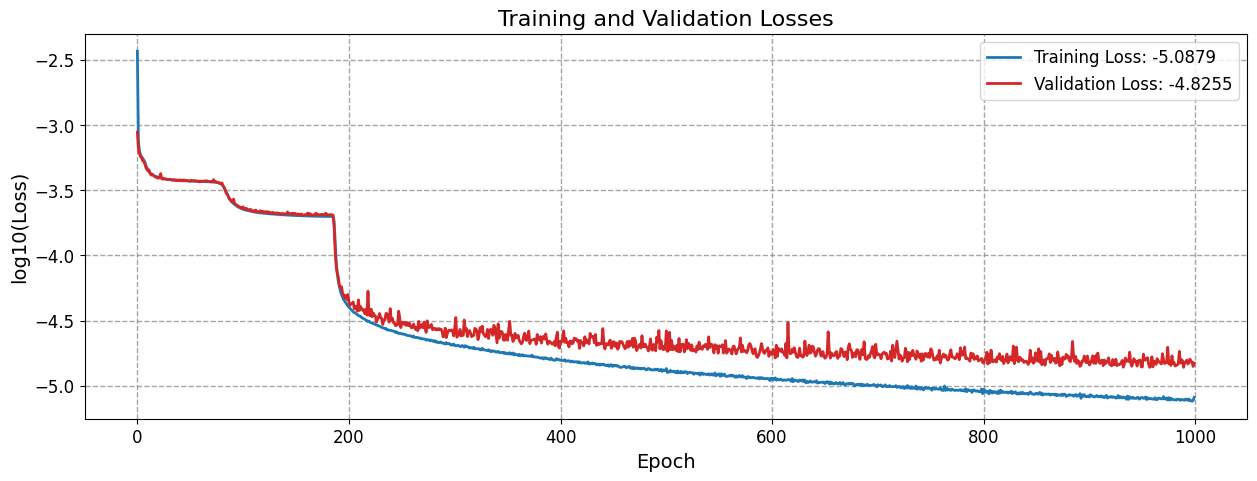

CPU times: total: 7min 28s
Wall time: 1h 23min 44s


In [101]:
%%time 

num_epochs = 1000

PATIENCE = 100
patience_counter = 0
for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, _, _ = run_one_epoch_forward("train", train_loader, forward_net, criterion, device, for_optimizer)
    train_losses.append(avg_train_loss) #Epoch training losses for plotting

    # Validation phase
    avg_val_loss, _, _ = run_one_epoch_forward("val", val_loader, forward_net, criterion, device)
    val_losses.append(avg_val_loss) # Append average validation loss for the epoch

    # Save model if validation loss has decreased; Early stopping
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save({"model_state_dict" : forward_net.state_dict(),
            "optimizer_state_dict": for_optimizer.state_dict()}, 
            "saved_data/models/min_loss/"+ forward_net_name + "val_min.pth")
        val_loss_min = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch} with validation loss: {avg_val_loss:.6f}')
            break

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")


In [102]:
# Save model
torch.save({"model_state_dict" : forward_net.state_dict(),
            "optimizer_state_dict": for_optimizer.state_dict()}, forward_net_path)

# Save training and validation losses for the inverse model
np.savez(for_losses_path, train_losses = np.array(train_losses), val_losses = np.array(val_losses))


In [103]:
#load min_loss model
checkpoint = torch.load("saved_data/models/min_loss/"+ forward_net_name + "val_min.pth", map_location=torch.device(device), weights_only=False)
forward_net.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

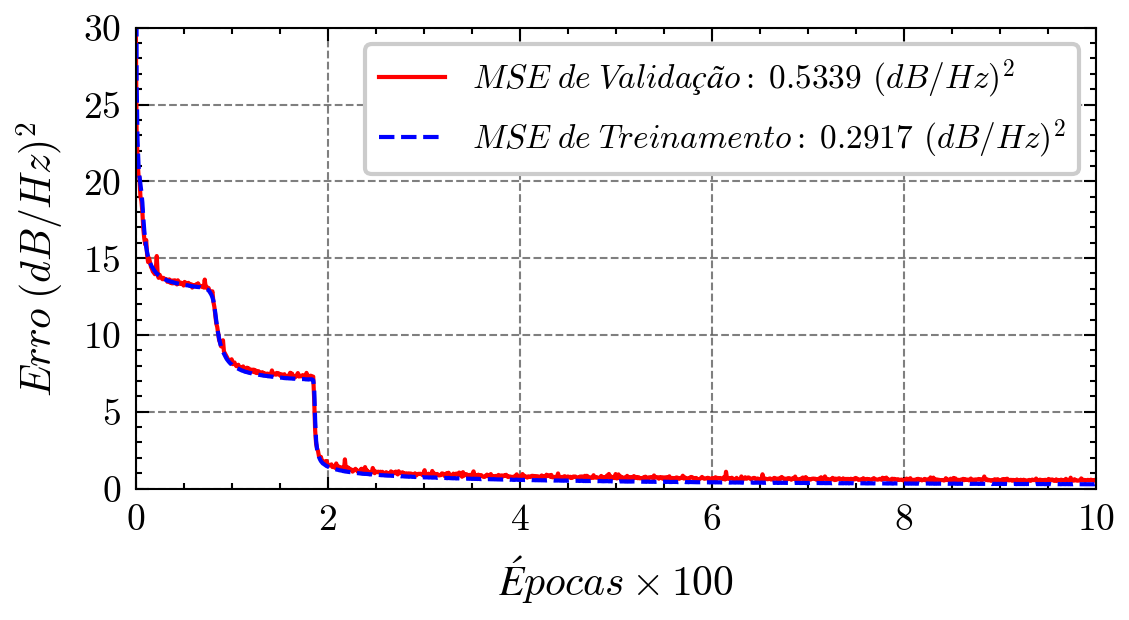

In [104]:
train_array = convert_to_real_loss(train_losses, train_dataset.norm_scales)
val_array = convert_to_real_loss(val_losses, train_dataset.norm_scales)
figname = "figures/" + forward_net_name + "_training_progress.png"
plot_training_progress_style(train_array, val_array, title = "", ylabel = r"$Erro\; (dB/Hz)^2$", ylim=(0,30), average_curves = False, M = 10, figname=figname)

### <a id='toc2_2_1_'></a>[Test Phase](#toc0_)

In [ ]:
# Flat Test phase

avg_test_loss, outputs, targets = run_one_epoch_forward("test", flat_loader, forward_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

for i in range(min(5, outputs.shape[0])):  # Loop over the first n examples

    # Denormalize
    outputs_denorm = train_dataset.denormalize(outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    real_loss = criterion(outputs_denorm, targets_denorm).item()

    # Plot the comparison
    title = ''
    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    outputs_denorm = outputs_denorm.cpu().detach().numpy().squeeze()

    figname = "figures/forward/" + f"forward_flat_sample_{i+1}.png"
    
    plot_comparison_style(targets_denorm, outputs_denorm, freqs_peaks_GHz, real_loss, figname, title, ylim = (-3,3), show_max_min=True)


Test Loss: 0.511798 (dB/Hz)^2


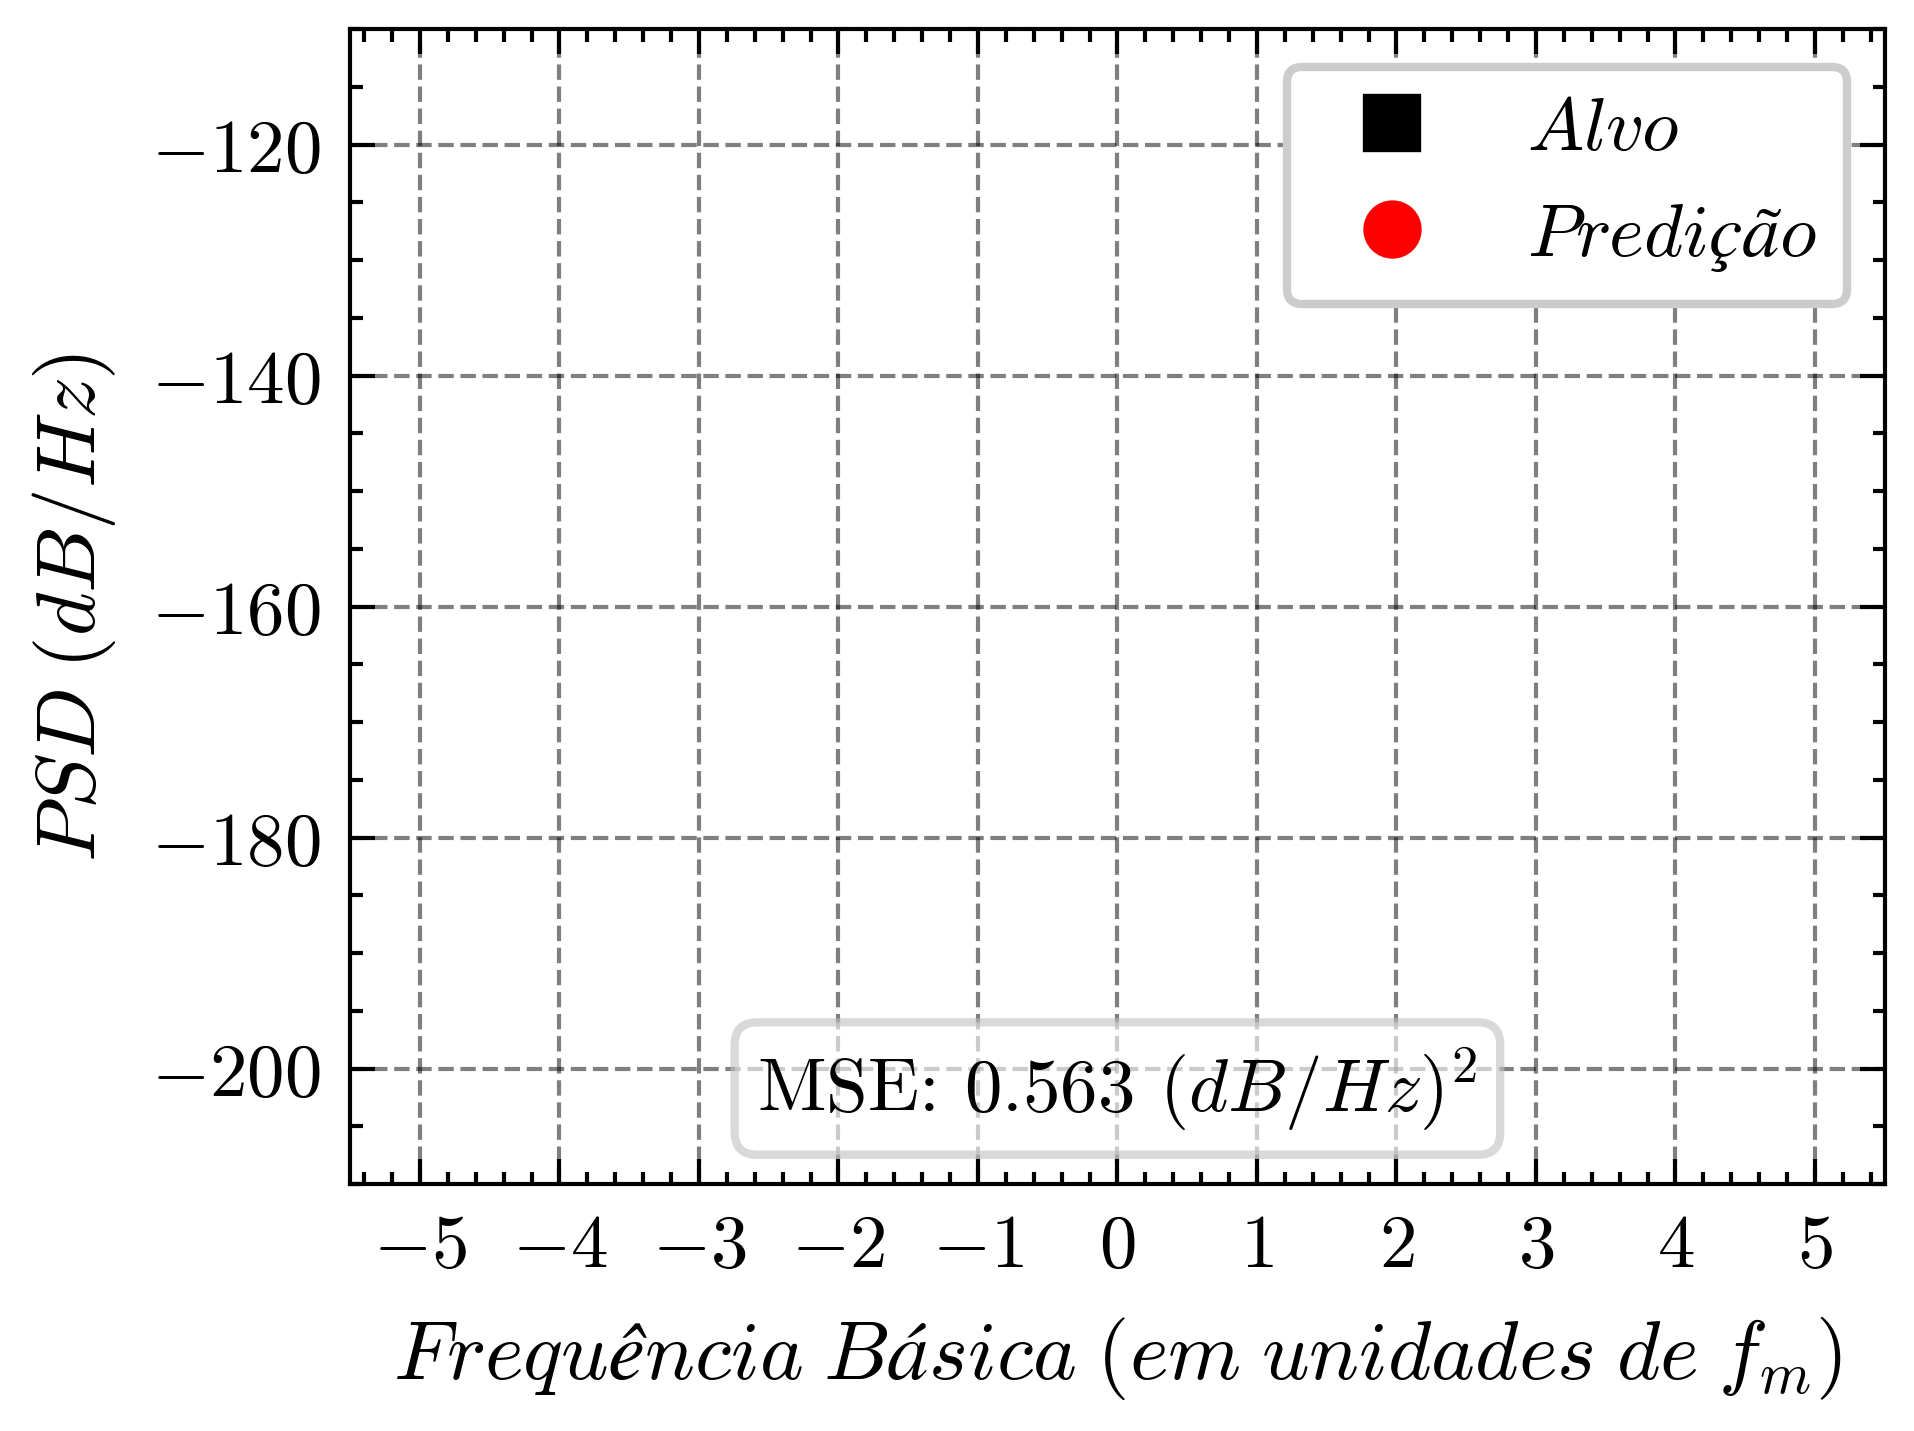

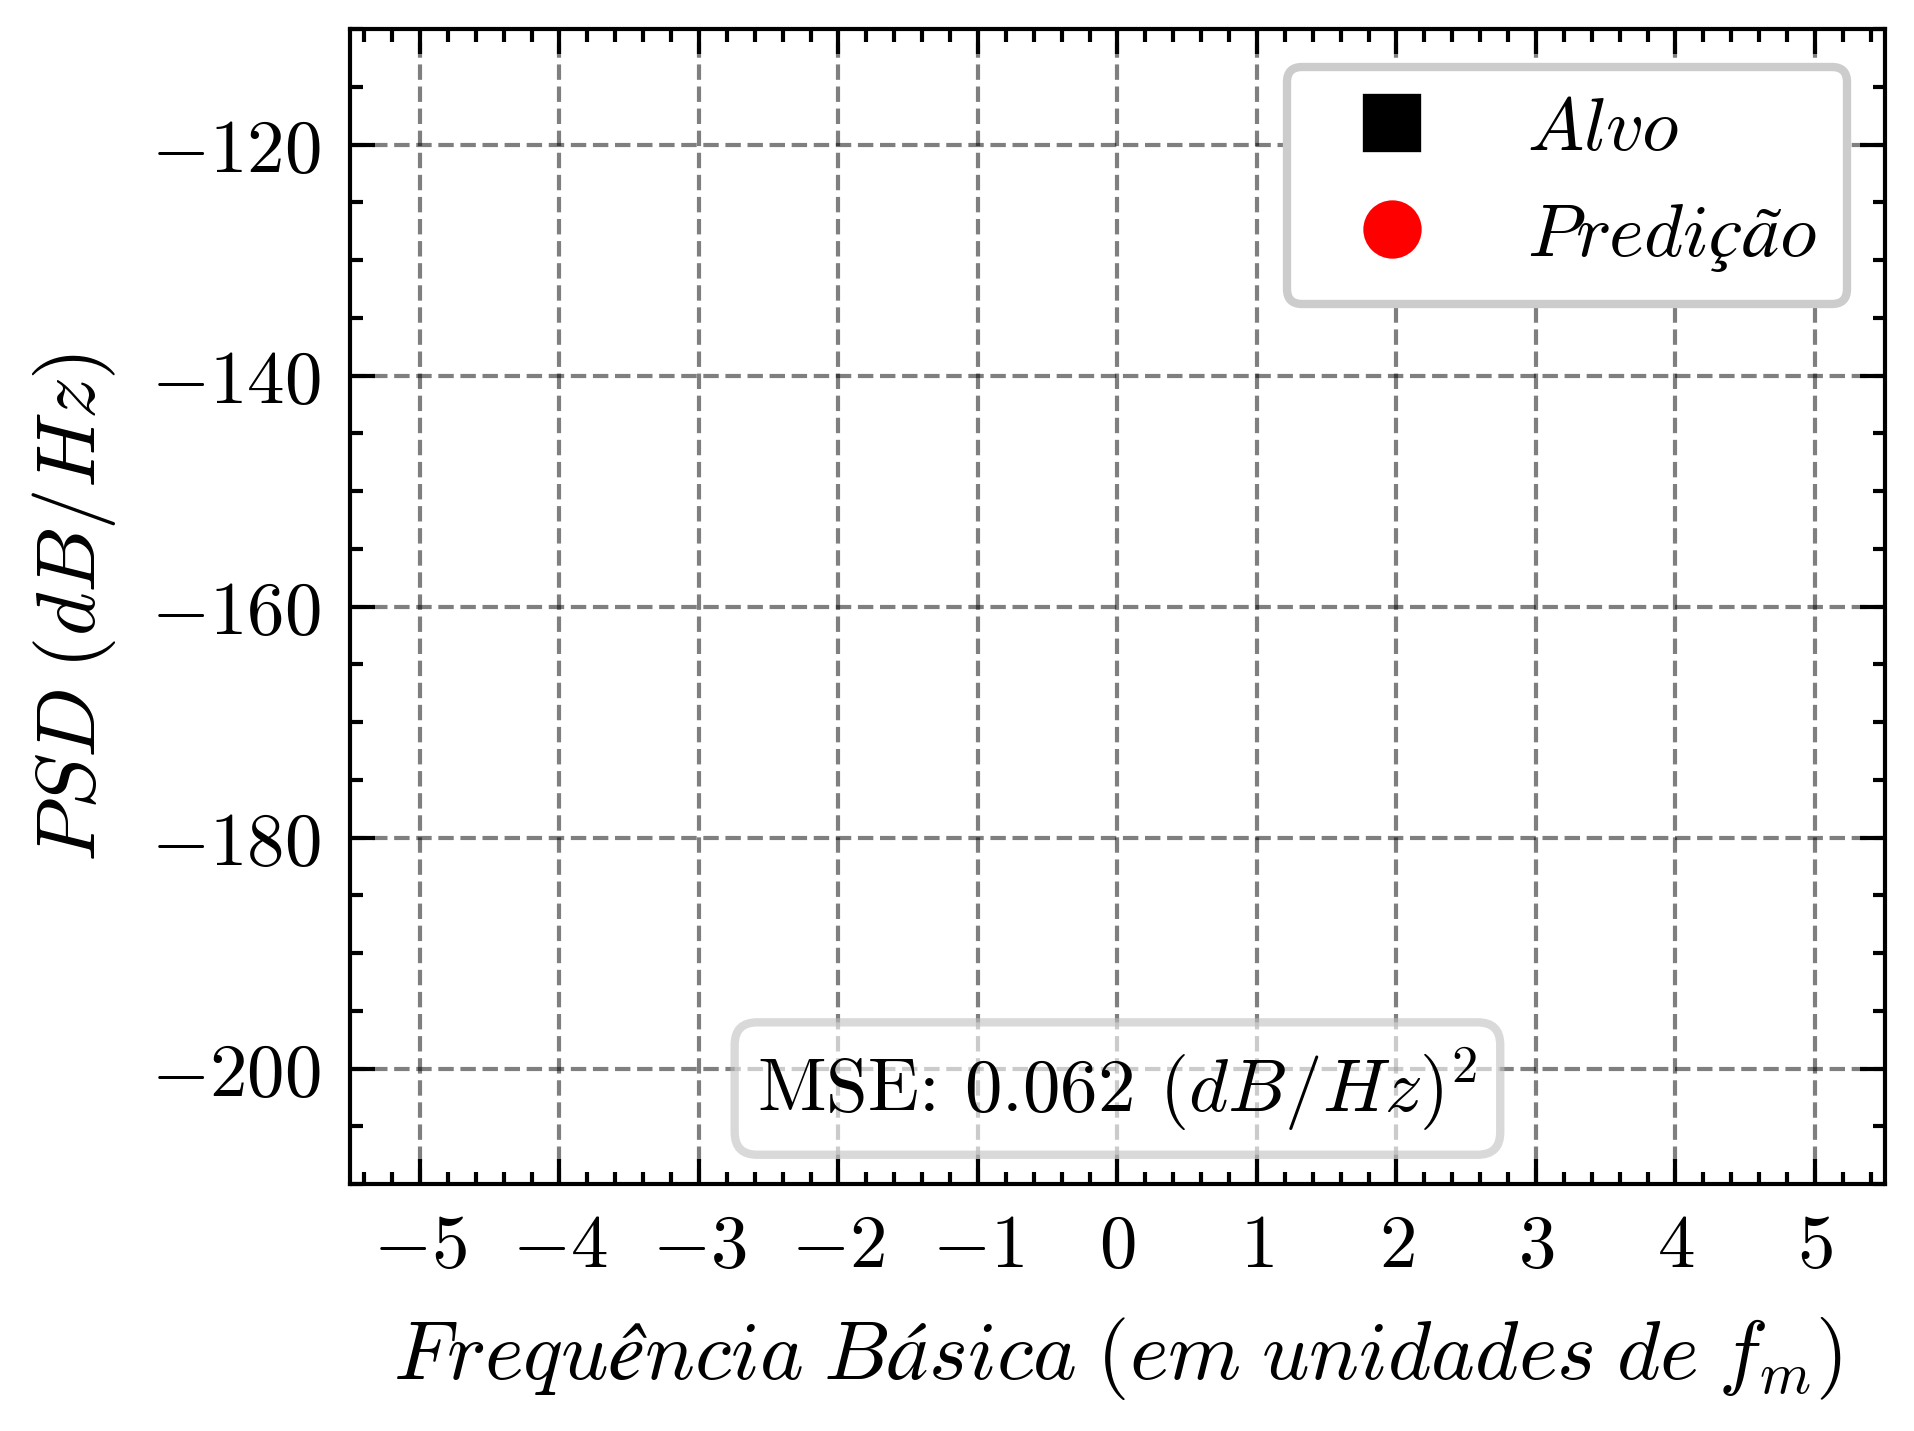

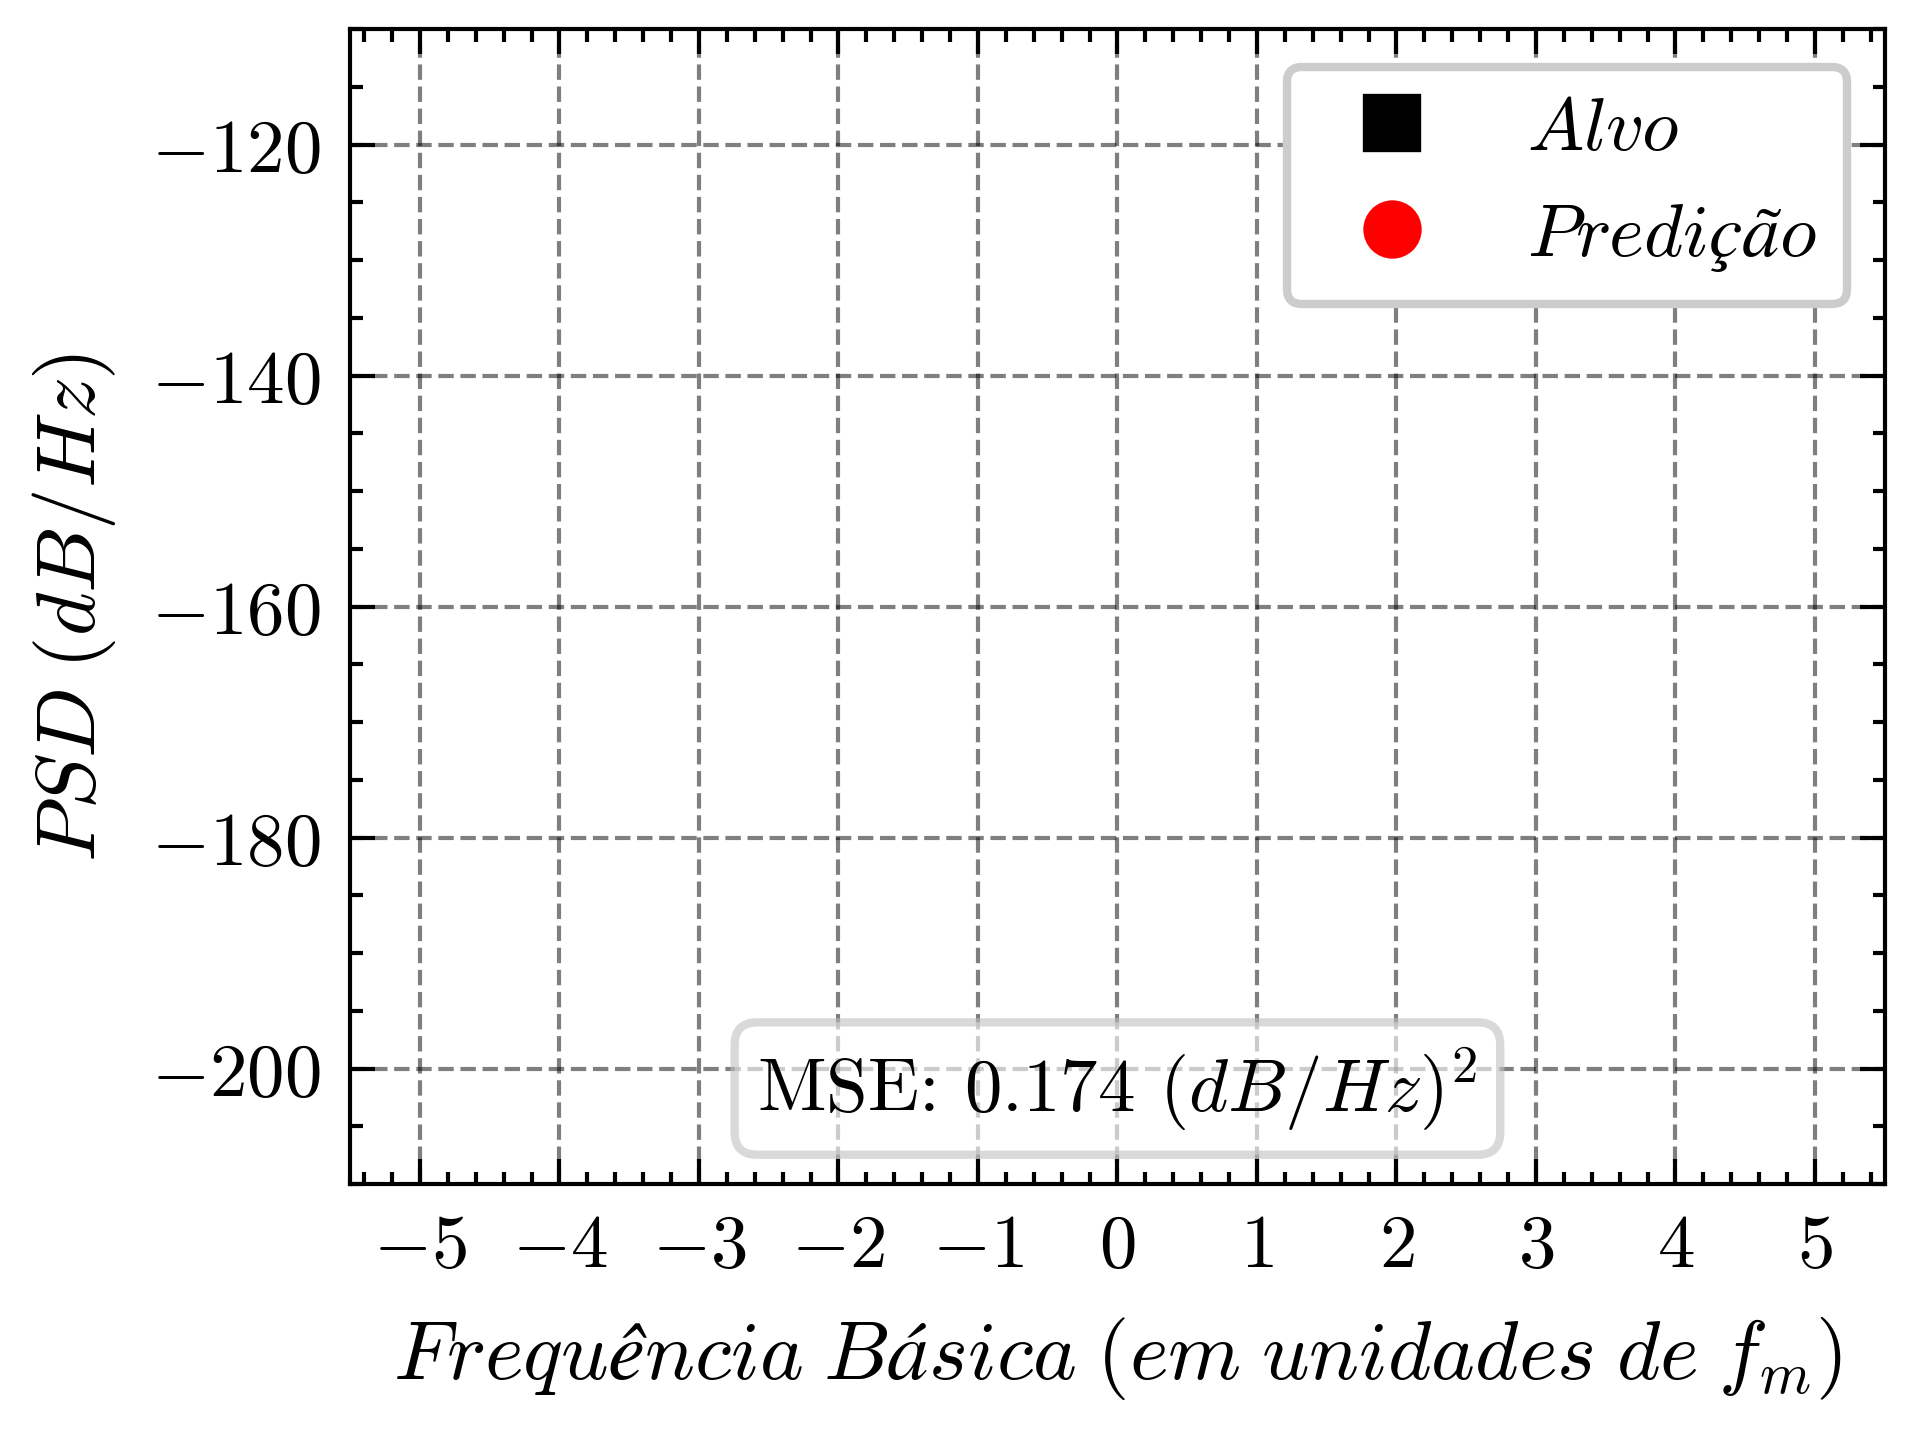

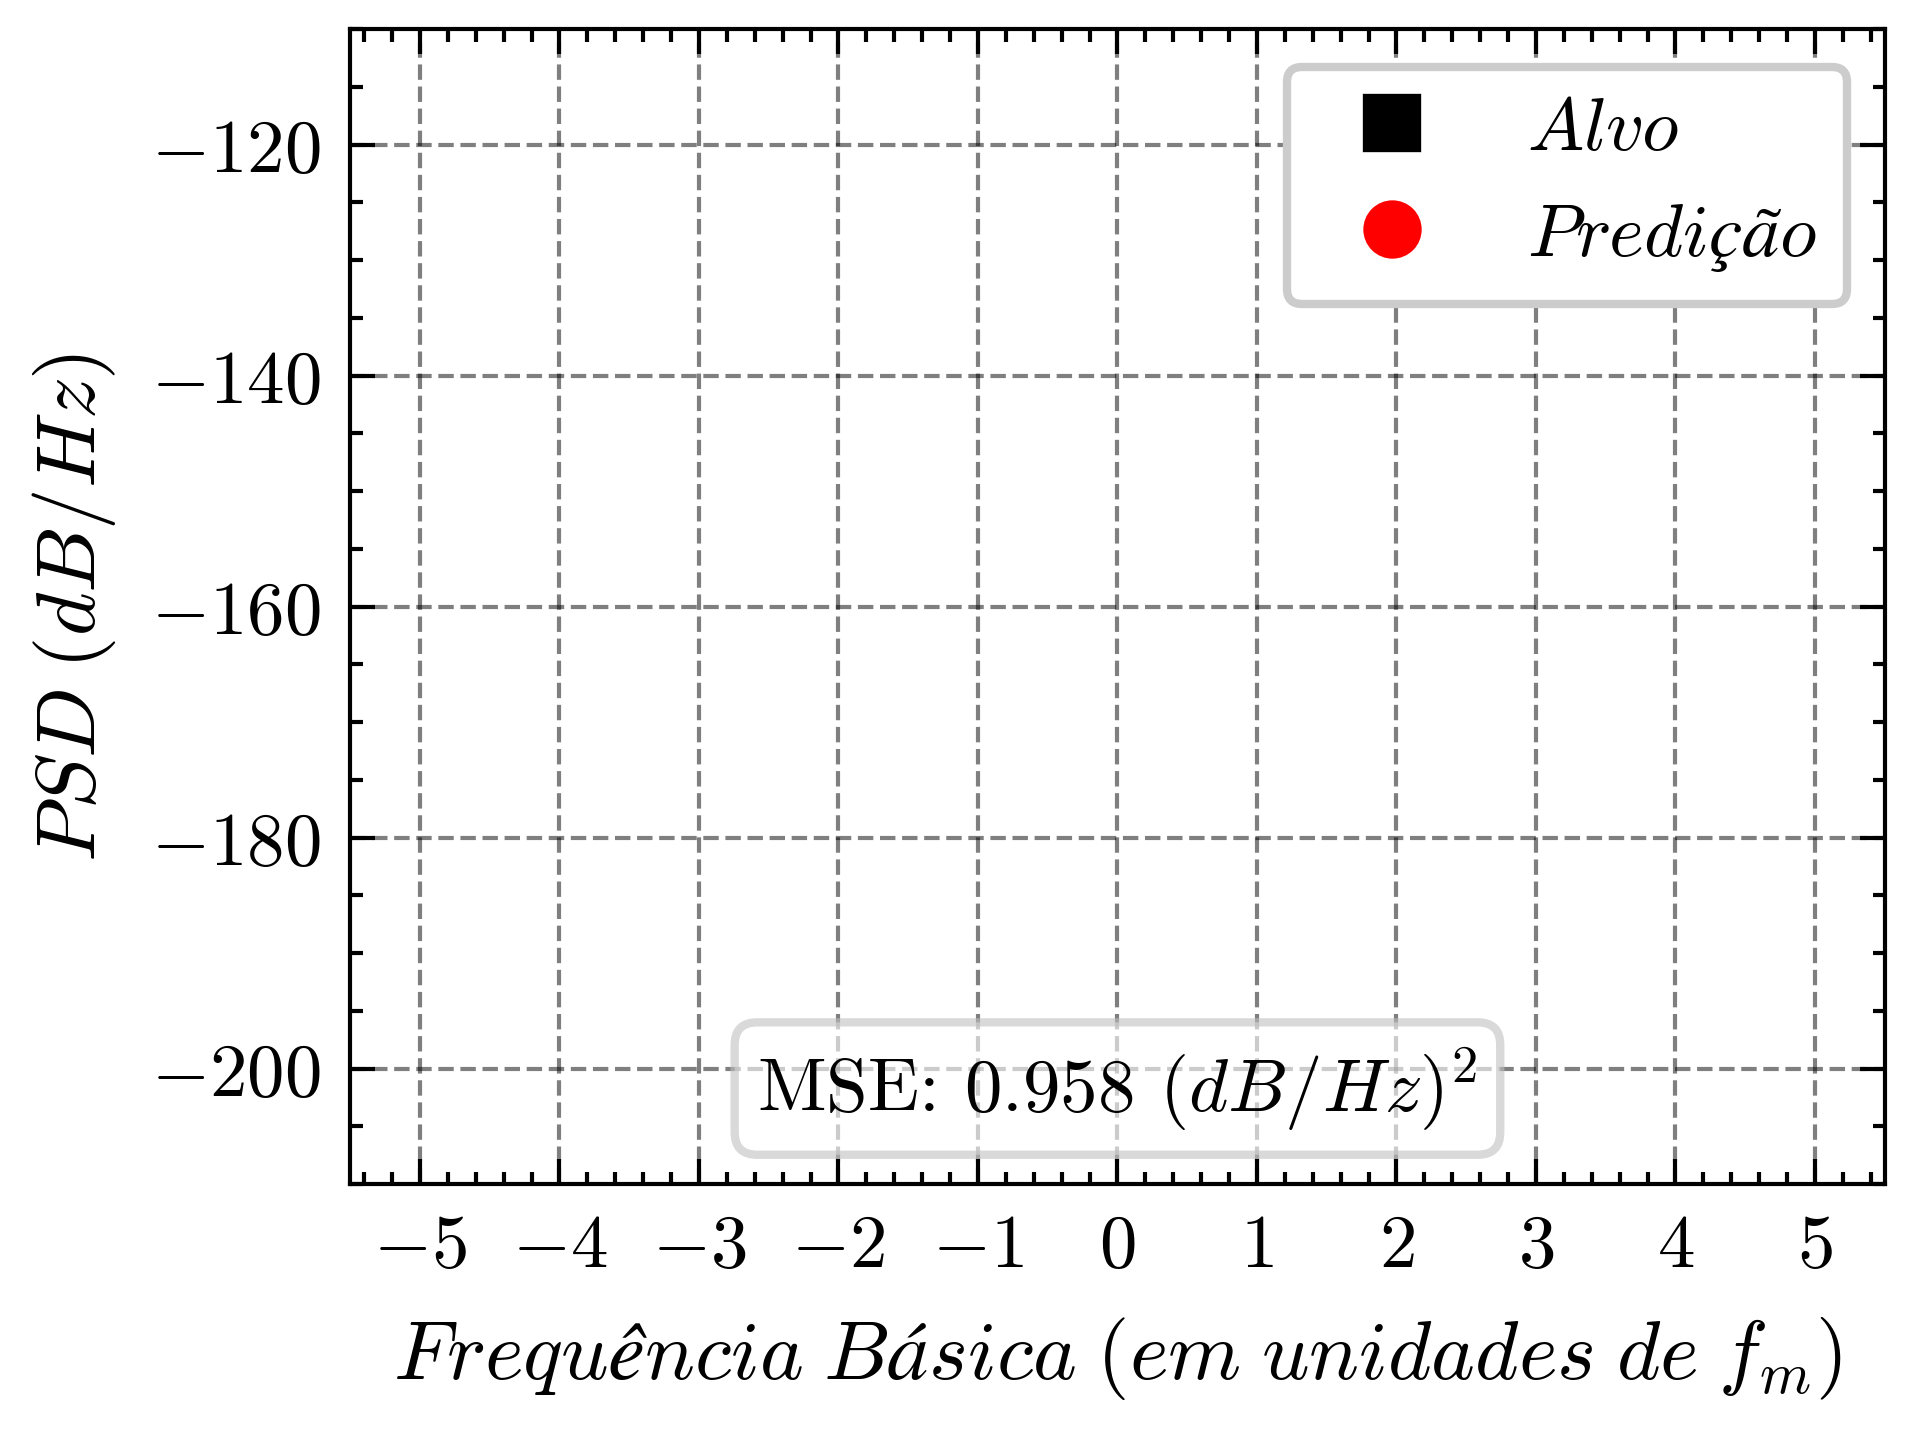

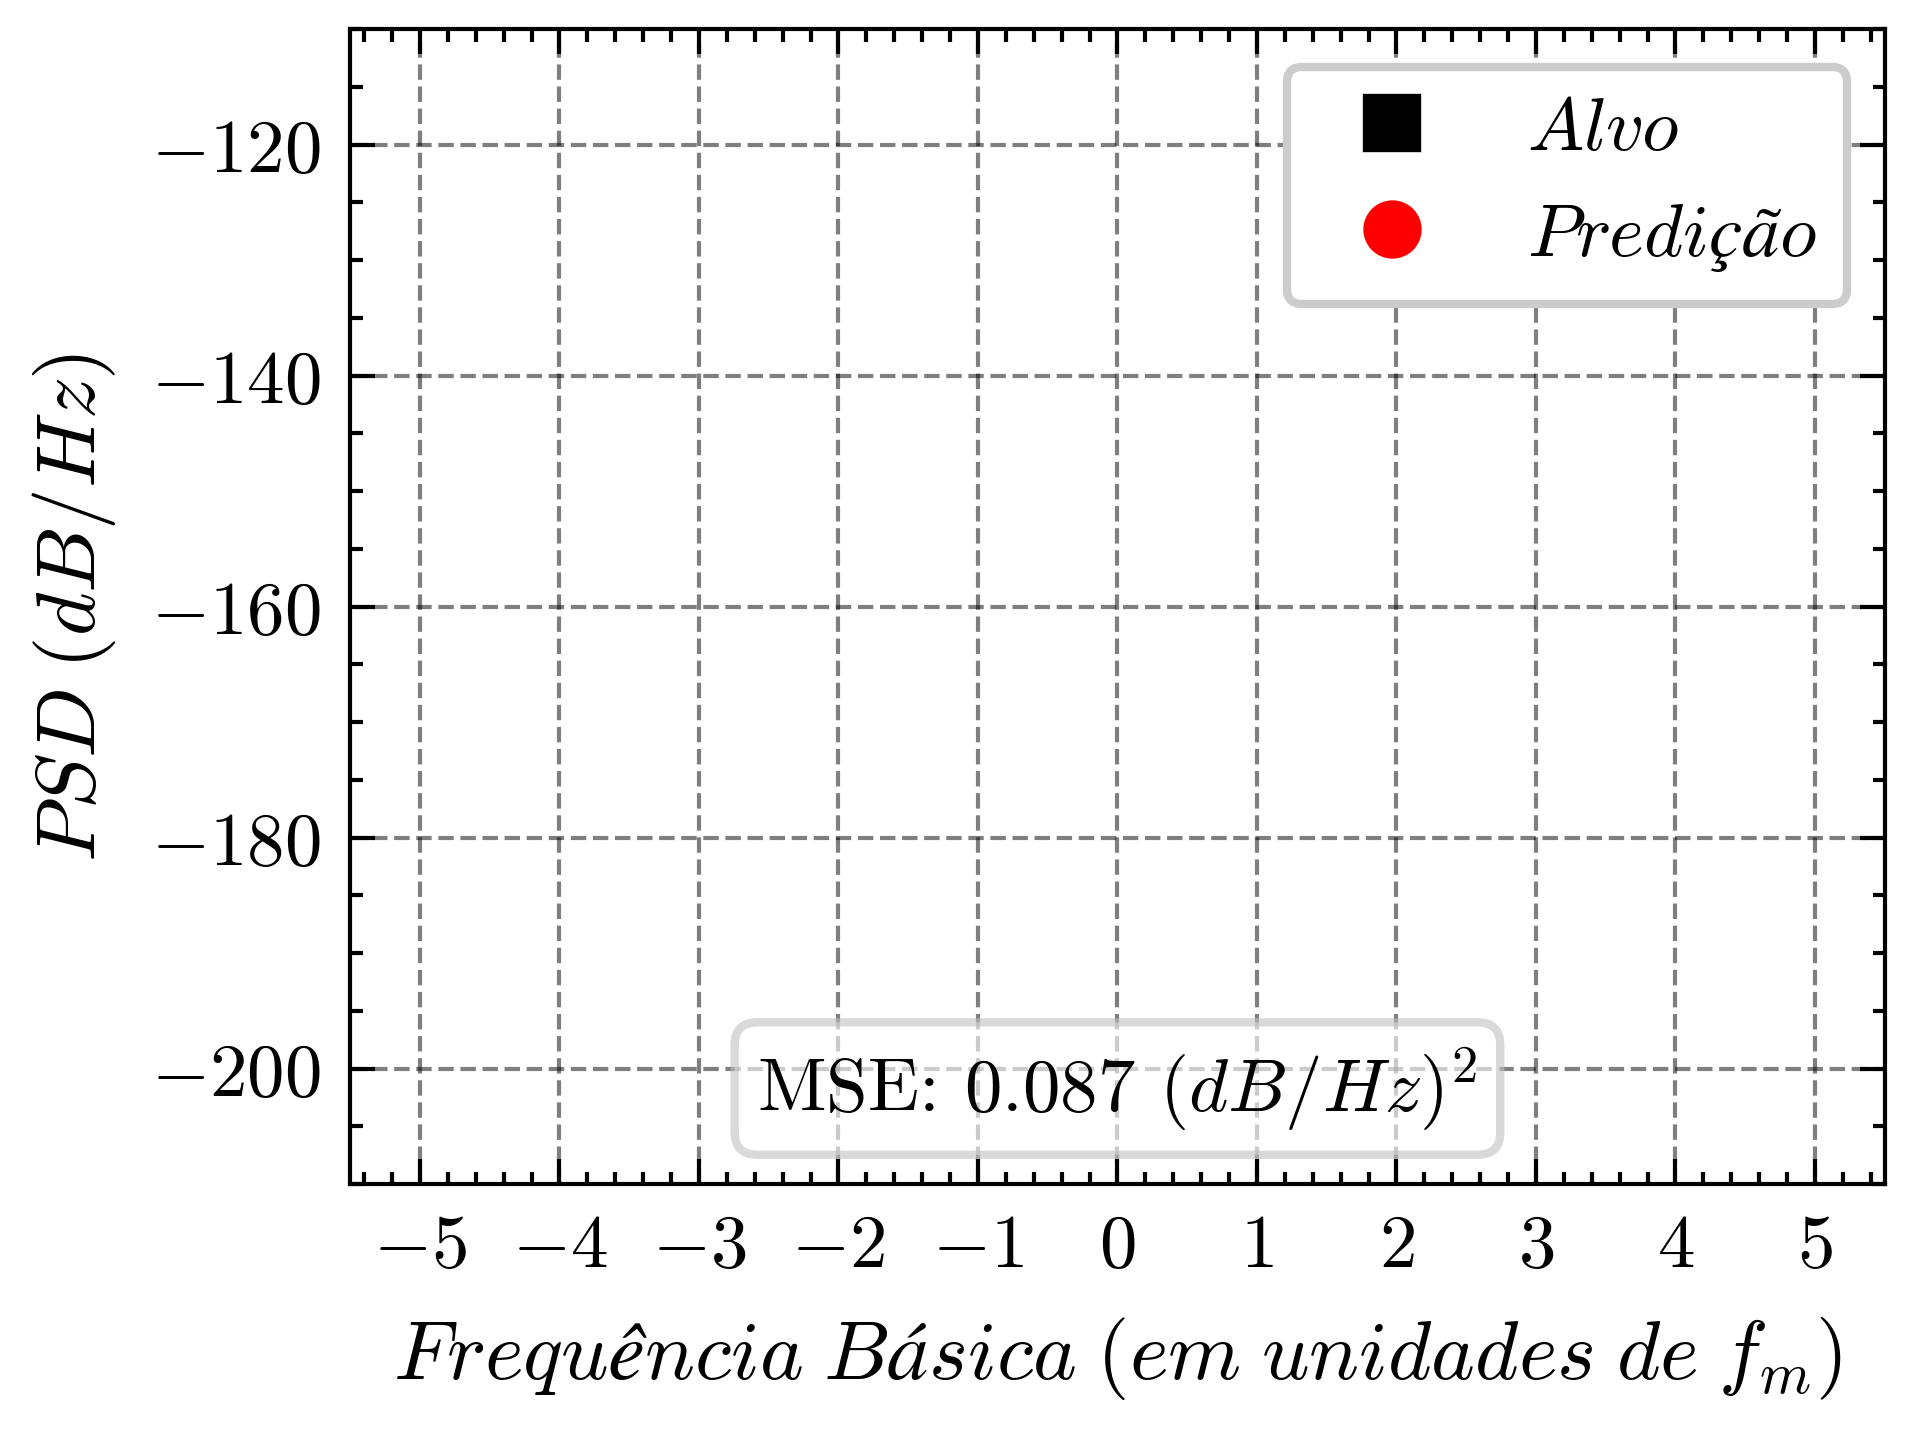

In [105]:
# Test phase
avg_test_loss, outputs, targets = run_one_epoch_forward("test", test_loader, forward_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

for i in range(min(5, outputs.shape[0])):  # Loop over the first n examples

    # Denormalize
    outputs_denorm = train_dataset.denormalize(outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    real_loss = criterion(outputs_denorm, targets_denorm).item()

    # Plot the comparison
    title = ''
    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    outputs_denorm = outputs_denorm.cpu().detach().numpy().squeeze()

    figname = "figures/forward/" + f"forward_sample_{i+1}.png"
    
    plot_comparison_style(targets_denorm, outputs_denorm, freqs_peaks_GHz, real_loss, figname, title, ylim = (-210,-110))


## <a id='toc2_3_'></a>[Inverse Network](#toc0_)

In [118]:
# Create data loaders
batch_size = 85
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

In [119]:
# Load the pre-trained forward model
forward_net_name = 'model_forward_7_176_176_176_176_176_176_176_176_11_pm_pm_mzm_350k_samples_TrueZeroMean_batch_size_85'
forward_net_path = "saved_data/models/" + forward_net_name + ".pth"

model_dict_data = torch.load(forward_net_path, map_location=torch.device(device), weights_only=False)
forward_architecture = get_architecture(model_dict_data)
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(model_dict_data["model_state_dict"])  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

# Create an inverse model
inverse_architecture = [n_outputs, 345, 345, 345, 345, 345, 345, n_inputs]
inverse_net = FrequencyCombNet(inverse_architecture).to(device)
inverse_net_name = "model_inverse_forward_" + "_".join([f"{n:.0f}" for n in inverse_architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"
inverse_net_path = "saved_data/models/"+ inverse_net_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = 8.5e-6) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(inverse_net_path):
    print("Loading model...")
    checkpoint = torch.load(inverse_net_path, map_location=torch.device(device), weights_only=False)
    inverse_net.load_state_dict(checkpoint['model_state_dict'])
    inv_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(inverse_net_name)
    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

Loading model...
model_inverse_forward_11_345_345_345_345_345_345_7_pm_pm_mzm_350k_samples_TrueZeroMean_batch_size_85
Model and Optimizer loaded!


In [120]:
calc_num_params(inverse_architecture)

603412

In [121]:
## losses
inv_losses_path = "saved_data/losses/" + inverse_net_name + '_losses.npz'

# Load training losses if file exists
if os.path.exists(inv_losses_path):
    losses = np.load(inv_losses_path)
    train_losses = list(losses['train_losses'])
    val_losses = list(losses['val_losses'])
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

val_loss_min = 1

Losses files loaded!


In [122]:
flat_val_losses = []
min_test_loss = 0.5

Validation loss decreased (1.000000 --> 0.000529). Epoch: 1. Saving model...
Validation loss decreased (0.000529 --> 0.000506). Epoch: 2. Saving model...
Validation loss decreased (0.000506 --> 0.000447). Epoch: 3. Saving model...
Validation loss decreased (0.000447 --> 0.000399). Epoch: 4. Saving model...
Validation loss decreased (0.000399 --> 0.000386). Epoch: 5. Saving model...
Validation loss decreased (0.000386 --> 0.000376). Epoch: 6. Saving model...
Validation loss decreased (0.000376 --> 0.000362). Epoch: 7. Saving model...
Validation loss decreased (0.000362 --> 0.000350). Epoch: 8. Saving model...
Validation loss decreased (0.000350 --> 0.000337). Epoch: 9. Saving model...
Validation loss decreased (0.000337 --> 0.000327). Epoch: 10. Saving model...
Validation loss decreased (0.000327 --> 0.000321). Epoch: 11. Saving model...
Validation loss decreased (0.000321 --> 0.000316). Epoch: 12. Saving model...
Validation loss decreased (0.000316 --> 0.000313). Epoch: 13. Saving mode

Validation loss decreased (0.000209 --> 0.000206). Epoch: 102. Saving model...
Validation loss decreased (0.000206 --> 0.000206). Epoch: 103. Saving model...
Validation loss decreased (0.000206 --> 0.000205). Epoch: 104. Saving model...
Validation loss decreased (0.000205 --> 0.000205). Epoch: 105. Saving model...
Validation loss decreased (0.000205 --> 0.000204). Epoch: 106. Saving model...
Validation loss decreased (0.000204 --> 0.000202). Epoch: 108. Saving model...
Validation loss decreased (0.000202 --> 0.000200). Epoch: 111. Saving model...
Validation loss decreased (0.000200 --> 0.000199). Epoch: 112. Saving model...
Validation loss decreased (0.000199 --> 0.000197). Epoch: 114. Saving model...
Validation loss decreased (0.000197 --> 0.000197). Epoch: 117. Saving model...
Validation loss decreased (0.000197 --> 0.000196). Epoch: 120. Saving model...
Validation loss decreased (0.000196 --> 0.000194). Epoch: 121. Saving model...
Validation loss decreased (0.000194 --> 0.000193). E

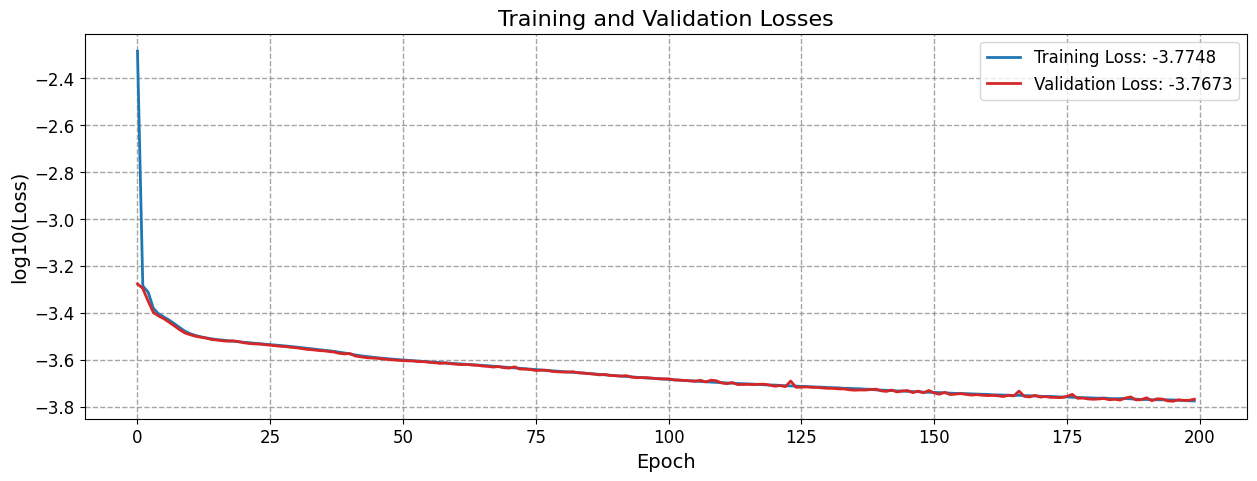

Validation loss decreased (0.000168 --> 0.000167). Epoch: 201. Saving model...
Validation loss decreased (0.000167 --> 0.000166). Epoch: 203. Saving model...
Validation loss decreased (0.000166 --> 0.000166). Epoch: 205. Saving model...
Validation loss decreased (0.000166 --> 0.000165). Epoch: 206. Saving model...
Validation loss decreased (0.000165 --> 0.000165). Epoch: 208. Saving model...
Validation loss decreased (0.000165 --> 0.000164). Epoch: 209. Saving model...
Validation loss decreased (0.000164 --> 0.000164). Epoch: 211. Saving model...
Validation loss decreased (0.000164 --> 0.000164). Epoch: 214. Saving model...
Validation loss decreased (0.000164 --> 0.000164). Epoch: 215. Saving model...
Validation loss decreased (0.000164 --> 0.000162). Epoch: 217. Saving model...
Validation loss decreased (0.000162 --> 0.000162). Epoch: 220. Saving model...
Validation loss decreased (0.000162 --> 0.000162). Epoch: 222. Saving model...
Validation loss decreased (0.000162 --> 0.000161). E

Validation loss decreased (0.000137 --> 0.000134). Epoch: 303. Saving model...
Validation loss decreased (0.000134 --> 0.000133). Epoch: 307. Saving model...
Validation loss decreased (0.000133 --> 0.000132). Epoch: 308. Saving model...
Validation loss decreased (0.000132 --> 0.000132). Epoch: 315. Saving model...
Validation loss decreased (0.000132 --> 0.000131). Epoch: 316. Saving model...
Validation loss decreased (0.000131 --> 0.000129). Epoch: 317. Saving model...
Validation loss decreased (0.000129 --> 0.000128). Epoch: 318. Saving model...
Validation loss decreased (0.000128 --> 0.000127). Epoch: 319. Saving model...
Validation loss decreased (0.000127 --> 0.000124). Epoch: 324. Saving model...
Validation loss decreased (0.000124 --> 0.000122). Epoch: 328. Saving model...
Validation loss decreased (0.000122 --> 0.000122). Epoch: 330. Saving model...
Validation loss decreased (0.000122 --> 0.000121). Epoch: 335. Saving model...
Validation loss decreased (0.000121 --> 0.000121). E

Validation loss decreased (0.000109 --> 0.000108). Epoch: 406. Saving model...
Validation loss decreased (0.000108 --> 0.000108). Epoch: 412. Saving model...
Validation loss decreased (0.000108 --> 0.000107). Epoch: 418. Saving model...
Validation loss decreased (0.000107 --> 0.000107). Epoch: 421. Saving model...
Validation loss decreased (0.000107 --> 0.000106). Epoch: 425. Saving model...
Validation loss decreased (0.000106 --> 0.000106). Epoch: 426. Saving model...
Validation loss decreased (0.000106 --> 0.000106). Epoch: 427. Saving model...
Validation loss decreased (0.000106 --> 0.000106). Epoch: 432. Saving model...
Validation loss decreased (0.000106 --> 0.000106). Epoch: 435. Saving model...
Validation loss decreased (0.000106 --> 0.000105). Epoch: 439. Saving model...
Validation loss decreased (0.000105 --> 0.000105). Epoch: 441. Saving model...
Validation loss decreased (0.000105 --> 0.000104). Epoch: 449. Saving model...
Validation loss decreased (0.000104 --> 0.000104). E

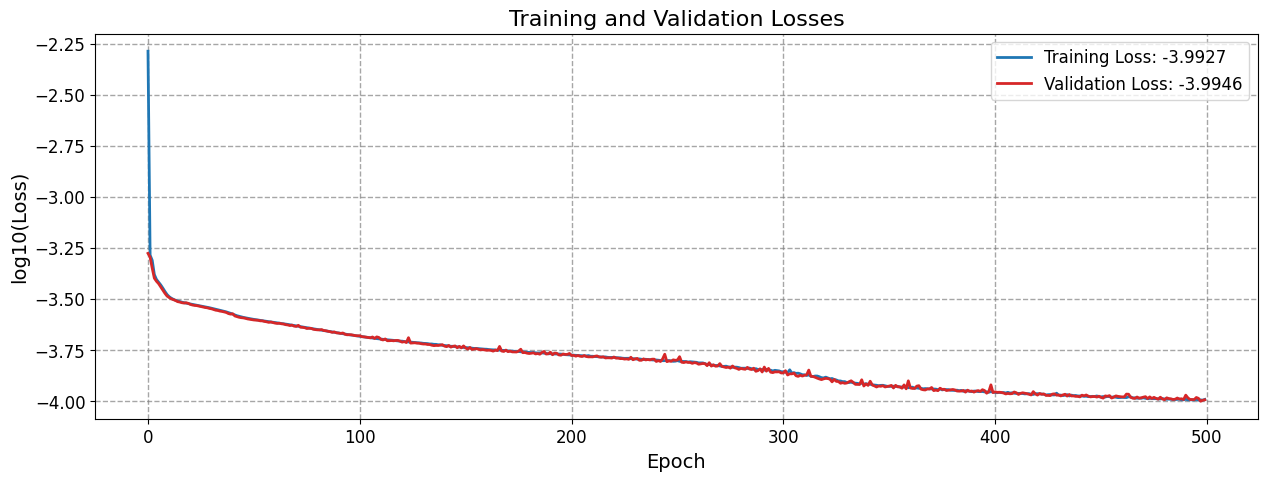

Validation loss decreased (0.000100 --> 0.000099). Epoch: 514. Saving model...
Validation loss decreased (0.000099 --> 0.000099). Epoch: 516. Saving model...
Validation loss decreased (0.000099 --> 0.000098). Epoch: 517. Saving model...
Validation loss decreased (0.000098 --> 0.000098). Epoch: 523. Saving model...
Validation loss decreased (0.000098 --> 0.000097). Epoch: 535. Saving model...
Validation loss decreased (0.000097 --> 0.000097). Epoch: 553. Saving model...
Validation loss decreased (0.000097 --> 0.000096). Epoch: 555. Saving model...
Validation loss decreased (0.000096 --> 0.000096). Epoch: 562. Saving model...
Validation loss decreased (0.000096 --> 0.000096). Epoch: 563. Saving model...
Validation loss decreased (0.000096 --> 0.000096). Epoch: 572. Saving model...
Validation loss decreased (0.000096 --> 0.000095). Epoch: 576. Saving model...
Validation loss decreased (0.000095 --> 0.000095). Epoch: 581. Saving model...
Validation loss decreased (0.000095 --> 0.000094). E

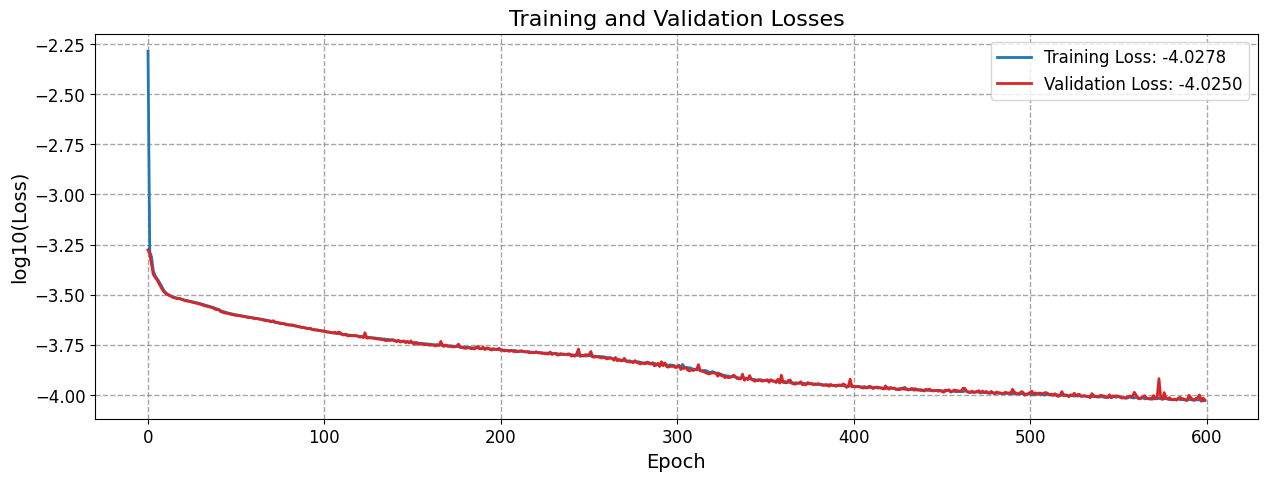

Validation loss decreased (0.000093 --> 0.000093). Epoch: 607. Saving model...
Validation loss decreased (0.000093 --> 0.000093). Epoch: 617. Saving model...
Validation loss decreased (0.000093 --> 0.000092). Epoch: 624. Saving model...
Validation loss decreased (0.000092 --> 0.000092). Epoch: 629. Saving model...
Validation loss decreased (0.000092 --> 0.000091). Epoch: 633. Saving model...
Validation loss decreased (0.000091 --> 0.000090). Epoch: 642. Saving model...
Validation loss decreased (0.000090 --> 0.000090). Epoch: 653. Saving model...
Validation loss decreased (0.000090 --> 0.000090). Epoch: 667. Saving model...
Validation loss decreased (0.000090 --> 0.000089). Epoch: 668. Saving model...
Validation loss decreased (0.000089 --> 0.000089). Epoch: 697. Saving model...
Epoch: 700/1000... Training loss: 3.127866 (dB/Hz)^2 ... Validation Loss: 3.442685 (dB/Hz)^2


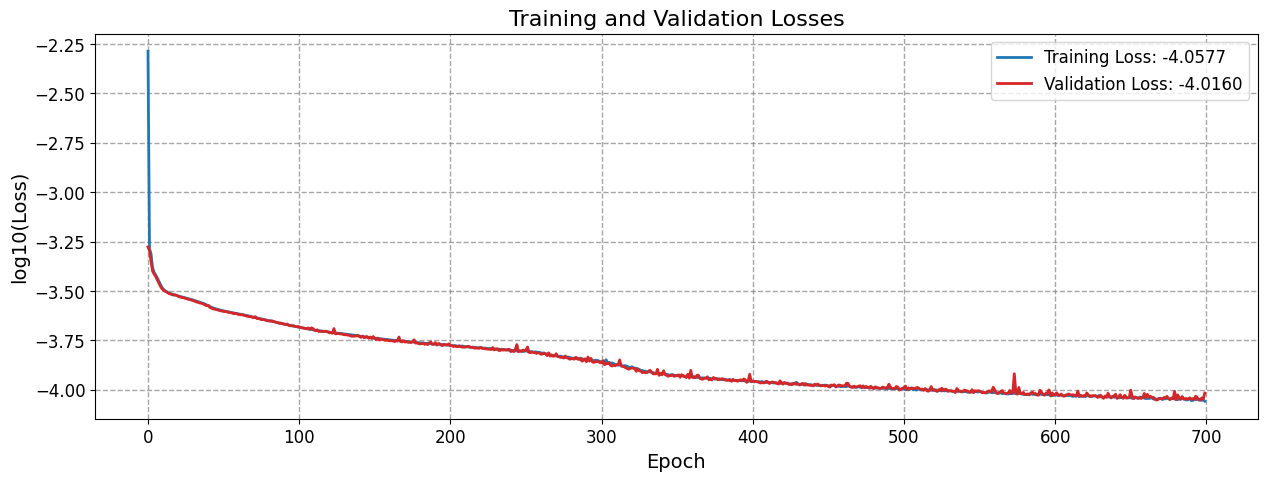

Validation loss decreased (0.000089 --> 0.000088). Epoch: 701. Saving model...
Validation loss decreased (0.000088 --> 0.000088). Epoch: 708. Saving model...
Validation loss decreased (0.000088 --> 0.000087). Epoch: 722. Saving model...
Validation loss decreased (0.000087 --> 0.000086). Epoch: 729. Saving model...
Validation loss decreased (0.000086 --> 0.000086). Epoch: 737. Saving model...
Validation loss decreased (0.000086 --> 0.000086). Epoch: 738. Saving model...
Validation loss decreased (0.000086 --> 0.000085). Epoch: 747. Saving model...
Validation loss decreased (0.000085 --> 0.000085). Epoch: 755. Saving model...
Validation loss decreased (0.000085 --> 0.000084). Epoch: 756. Saving model...
Validation loss decreased (0.000084 --> 0.000083). Epoch: 767. Saving model...
Validation loss decreased (0.000083 --> 0.000082). Epoch: 772. Saving model...
Validation loss decreased (0.000082 --> 0.000082). Epoch: 781. Saving model...
Validation loss decreased (0.000082 --> 0.000081). E

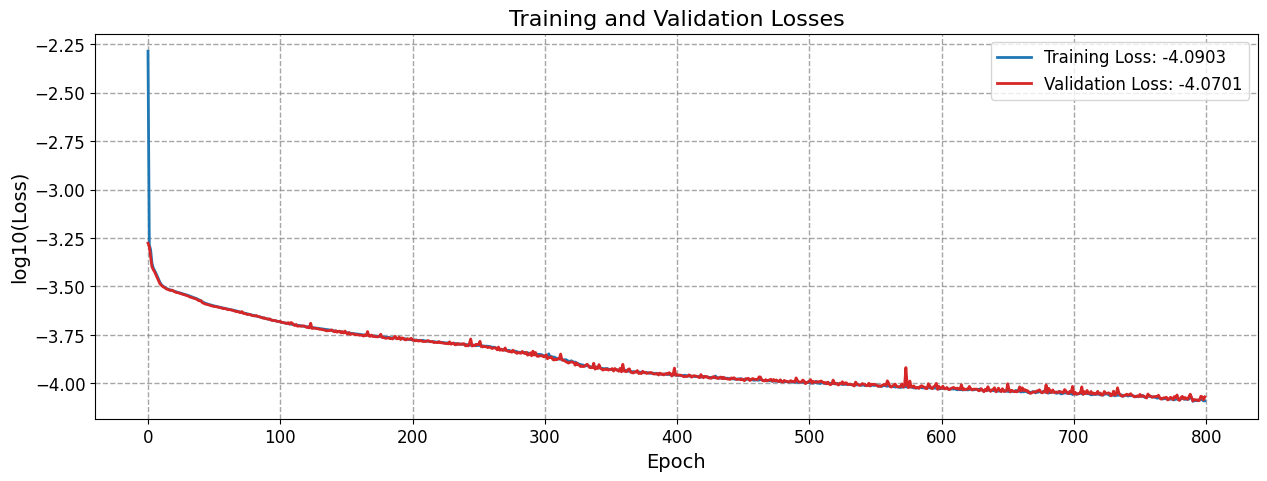

Validation loss decreased (0.000081 --> 0.000081). Epoch: 805. Saving model...
Validation loss decreased (0.000081 --> 0.000080). Epoch: 809. Saving model...
Validation loss decreased (0.000080 --> 0.000080). Epoch: 821. Saving model...
Validation loss decreased (0.000080 --> 0.000080). Epoch: 823. Saving model...
Validation loss decreased (0.000080 --> 0.000080). Epoch: 824. Saving model...
Validation loss decreased (0.000080 --> 0.000079). Epoch: 836. Saving model...
Validation loss decreased (0.000079 --> 0.000079). Epoch: 837. Saving model...
Validation loss decreased (0.000079 --> 0.000079). Epoch: 849. Saving model...
Validation loss decreased (0.000079 --> 0.000078). Epoch: 856. Saving model...
Validation loss decreased (0.000078 --> 0.000078). Epoch: 858. Saving model...
Validation loss decreased (0.000078 --> 0.000078). Epoch: 864. Saving model...
Validation loss decreased (0.000078 --> 0.000077). Epoch: 868. Saving model...
Validation loss decreased (0.000077 --> 0.000077). E

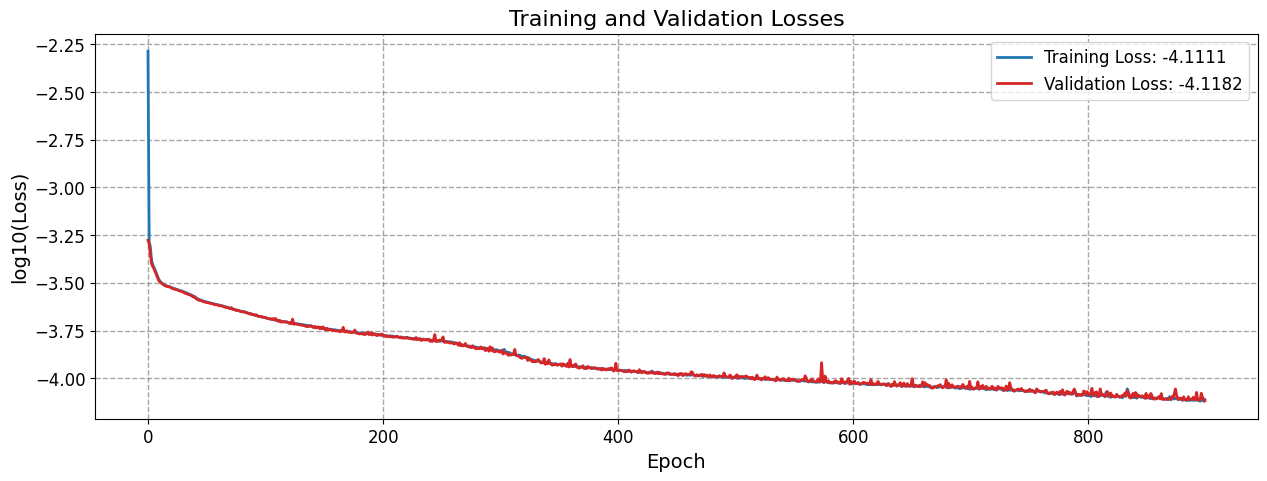

Validation loss decreased (0.000076 --> 0.000076). Epoch: 907. Saving model...
Validation loss decreased (0.000076 --> 0.000075). Epoch: 910. Saving model...
Validation loss decreased (0.000075 --> 0.000074). Epoch: 919. Saving model...
Validation loss decreased (0.000074 --> 0.000074). Epoch: 935. Saving model...
Validation loss decreased (0.000074 --> 0.000074). Epoch: 956. Saving model...
Validation loss decreased (0.000074 --> 0.000074). Epoch: 975. Saving model...
Validation loss decreased (0.000074 --> 0.000073). Epoch: 978. Saving model...
Validation loss decreased (0.000073 --> 0.000073). Epoch: 989. Saving model...
Validation loss decreased (0.000073 --> 0.000073). Epoch: 996. Saving model...
Validation loss decreased (0.000073 --> 0.000072). Epoch: 999. Saving model...
Epoch: 1000/1000... Training loss: 2.644080 (dB/Hz)^2 ... Validation Loss: 2.634868 (dB/Hz)^2


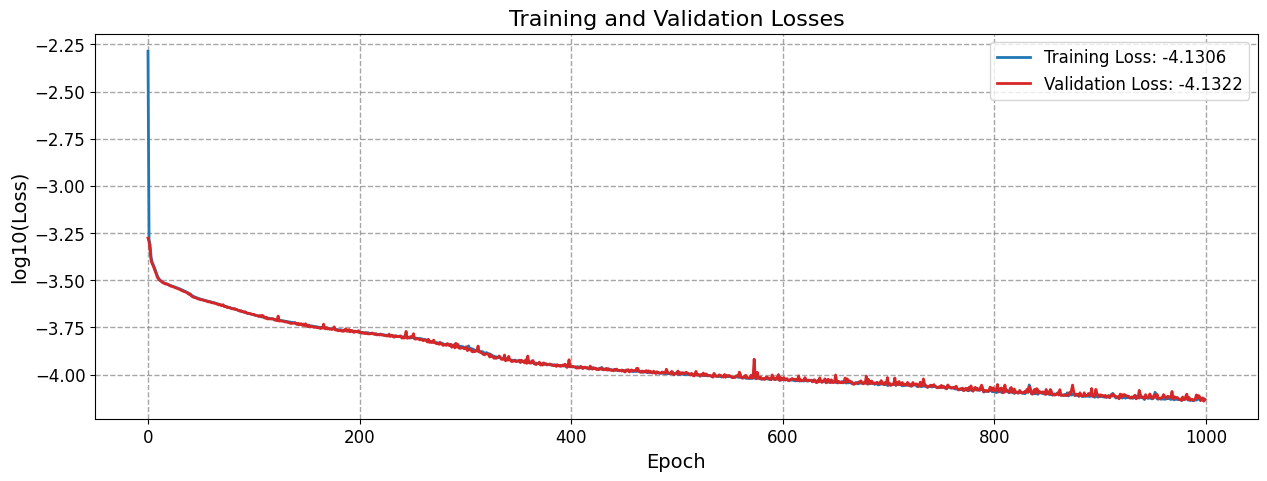

CPU times: total: 5min 32s
Wall time: 1h 45min 1s


In [123]:
%%time

num_epochs = 1000

PATIENCE = 200
patience_counter = 0

for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, _, _, _, _ = run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)
    train_losses.append(avg_train_loss)

    # Validation phase
    avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
    val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Save model if validation loss has decreased; Early stopping
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, 
            "saved_data/models/min_loss/"+ inverse_net_name + "val_min.pth")
        val_loss_min = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch} with validation loss: {avg_val_loss:.6f}')
            break

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")


    # Test FlatComb
    perfect_flat_comb = torch.tensor([-150]*n_outputs).unsqueeze(0).to(device)
    if dataset.zero_mean:
        perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype=torch.float32)
    perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

    perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

    #inverse_peaks = frequencyCombPeaks(perfect_flat_comb_inv_output.to('cpu'), ofc_args).to(device)
    inverse_peaks = frequencyCombPeaks(perfect_flat_comb_inv_output.to('cpu'), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)

    if dataset.zero_mean:
        inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    inv_loss = criterion(perfect_flat_comb, inverse_peaks).item()
    inv_loss = convert_to_real_loss(inv_loss, train_dataset.norm_scales).item()

    flat_val_losses.append(inv_loss)  # Append average validation loss for the epoch

    if inv_loss < min_test_loss:
        min_test_loss = inv_loss
        print(f"Epoch: {epoch}/{num_epochs}... Test loss: {inv_loss:.6f} (dB/Hz)^2 .. validation loss: {avg_val_loss:.6f}")
        torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, 
            "saved_data/models/min_loss/"+ inverse_net_name + "_min_flat_loss.pth")
        
    if inv_loss < 0.1:
        print(f"Epoch: {epoch}/{num_epochs}... Test loss: {inv_loss:.6f} (dB/Hz)^2 .. validation loss: {avg_val_loss:.6f}")

        #break


(0.0, 2.0)

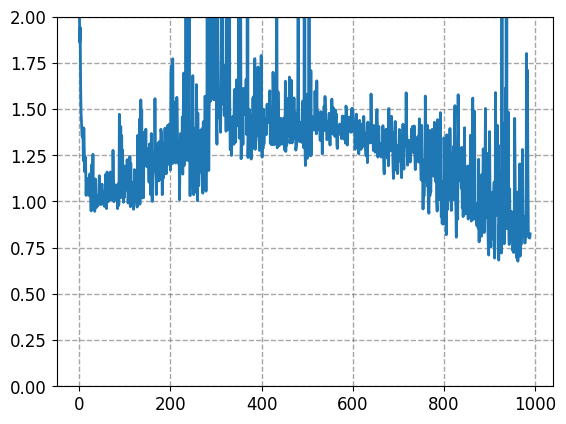

In [125]:
plt.plot(flat_val_losses[10:])
plt.ylim(0,2)
#plt.xlim(460,470)

In [126]:
# Save model
torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, inverse_net_path)

# Save training and validation losses for the inverse model
np.savez(inv_losses_path, train_losses = np.array(train_losses), val_losses = np.array(val_losses))

In [127]:
#load min flat loss model
checkpoint = torch.load("saved_data/models/min_loss/" + inverse_net_name + "_min_flat_loss.pth", map_location=torch.device(device))
inverse_net.load_state_dict(checkpoint['model_state_dict'])

C:\Users\PC\AppData\Local\Temp\ipykernel_22072\99389043.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("saved_data/models/min_loss/" + inverse_n

FileNotFoundError: [Errno 2] No such file or directory: 'saved_data/models/min_loss/model_inverse_forward_11_345_345_345_345_345_345_7_pm_pm_mzm_350k_samples_TrueZeroMean_batch_size_85_min_flat_loss.pth'

In [128]:
#load the min loss
checkpoint = torch.load("saved_data/models/min_loss/" + inverse_net_name + "val_min.pth", map_location=torch.device(device), weights_only=False)
inverse_net.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [129]:
train_array = convert_to_real_loss(train_losses, train_dataset.norm_scales)
val_array = convert_to_real_loss(val_losses, train_dataset.norm_scales)
figname = "figures/inv_forward/" + inverse_net_name + "_training_progress.png"

plot_training_progress_style(train_array, val_array, title = "",  average_curves = False, figname = figname, ylim=(0,20))

### <a id='toc2_3_1_'></a>[Test Phase](#toc0_)

In [131]:
# Test phase

perfect_flat_comb = torch.tensor([-150]*n_outputs).unsqueeze(0).to(device) #flat comb
#perfect_flat_comb = torch.tensor([-80,-85,-90,-95,-100,-105,-100,-95,-90,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb = torch.tensor(0.5*np.arange(-5,6,1)**2, dtype=torch.float32).unsqueeze(0).to(device) #quadratic comb
#perfect_flat_comb = torch.tensor(-150**np.exp(0.0005*np.arange(-(9//2),9//2+1,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb 
#perfect_flat_comb = torch.tensor(-60*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb negative
#perfect_flat_comb = torch.tensor(-np.abs(8*np.arange(-5,6,1)), dtype=torch.float32).unsqueeze(0).to(device) #hate comb
#perfect_flat_comb = torch.tensor(3.6*np.arange(-5,6,1), dtype=torch.float32).unsqueeze(0).to(device) # linear comb
#perfect_flat_comb = -2.5*torch.tensor([-80,-85,-80,-85,-80,-85,-80,-85,-80,-85,-80]).unsqueeze(0).to(device) #alternating comb
perfect_flat_comb[0,0] , perfect_flat_comb[0,-1] = -160, -160 

perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype=torch.float32)*dataset.zero_mean
perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

#inverse_peaks = frequencyCombPeaks(perfect_flat_comb_inv_output.to('cpu'), ofc_args).to(device)
inverse_peaks = frequencyCombPeaks(perfect_flat_comb_inv_output.to("cpu"), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)

inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)*dataset.zero_mean
inverse_peaks = train_dataset.normalize(inverse_peaks)

loss = criterion(perfect_flat_comb, inverse_peaks).item()
real_loss = convert_to_real_loss(loss, train_dataset.norm_scales).item()

perfect_flat_comb_denorm = train_dataset.denormalize(perfect_flat_comb).cpu().detach().numpy().squeeze()
inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks).cpu().detach().numpy().squeeze()

# Plot the Comparison
title = ''
figname = 'figures/fig_inverse_hat_comb'
figname = 'figures/fig_inverse_hole_comb'
figname = 'figures/inverseNet_sample3'
figname = 'figures/fig_inverse_flat_comb'
figname = 'figures/fig_inverse_linear_comb'
figname = 'figures/fig_inverse_gaussian_comb'

figname = 'figures/inv_forward/inv_forward_perfect_flat_comb.png'

plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, real_loss, figname, title, show_max_min=True)
#plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, real_loss, figname, title, show_max_min=False)

In [132]:
# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", train_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

Test Loss: 2.526437 (dB/Hz)^2


In [133]:
# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", val_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

Test Loss: 2.584427 (dB/Hz)^2


In [134]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", test_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

Test Loss: 2.598614 (dB/Hz)^2


In [ ]:
# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", flat_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

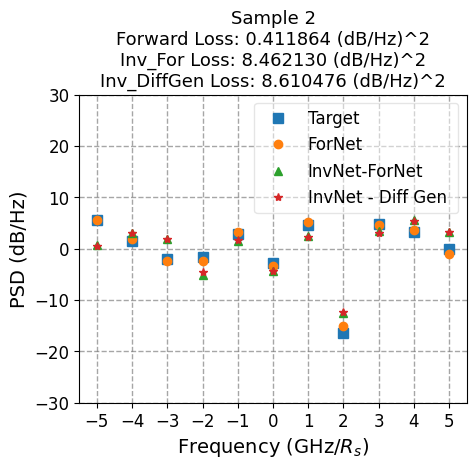

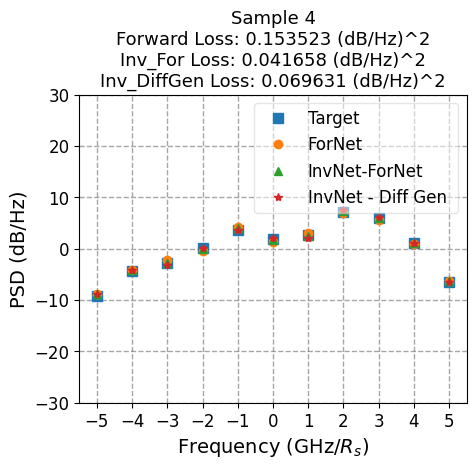

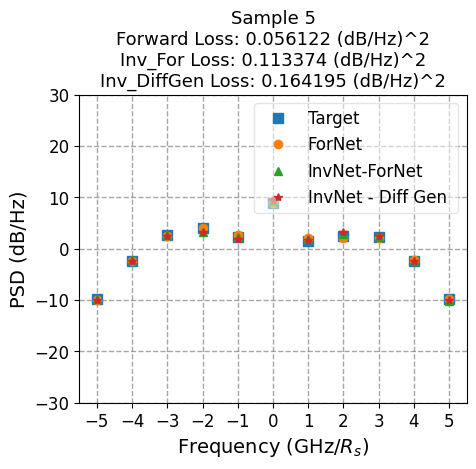

In [137]:
# Loop over the first n examples
for i in range(min(5, targets.shape[0])):

    #inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args).to(device)
    inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)

    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)*dataset.zero_mean
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    forward_peaks = forward_net(inputs[i].unsqueeze(0))

    # Denormalize
    inv_for_outputs_denorm = train_dataset.denormalize(inv_for_outputs[i]).unsqueeze(0)
    targets_denorm = train_dataset.denormalize(targets[i]).unsqueeze(0)
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)
    forward_peaks_denorm = train_dataset.denormalize(forward_peaks)

    inv_for_loss = criterion(inv_for_outputs_denorm, targets_denorm).item()
    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()
    forward_loss = criterion(forward_peaks_denorm, targets_denorm).item()

    fig, ax = plt.subplots(1,1, figsize=(5,4))
    freqs_GHz = np.linspace(-(ofc_args.n_peaks//2),ofc_args.n_peaks//2,ofc_args.n_peaks) # Frequency range in GHz for n_peaks
    ax.plot(freqs_GHz,targets_denorm.cpu().detach().numpy().squeeze(),"s", label='Target',markersize=7)
    ax.plot(freqs_GHz,forward_peaks_denorm.cpu().detach().numpy().squeeze(),"o", label=f'ForNet')
    ax.plot(freqs_GHz,inv_for_outputs_denorm.cpu().detach().numpy().squeeze(),"^", label=f'InvNet-ForNet')
    ax.plot(freqs_GHz,inverse_peaks_denorm.cpu().detach().numpy().squeeze(),"*",label=f'InvNet - Diff Gen ')
    ax.set_xticks(freqs_GHz)
    ax.set_xlabel(r"Frequency (GHz/$R_s$)")
    ax.set_ylabel("PSD (dB/Hz)")
    #ax.set_ylim(-200,-100)
    ax.set_ylim(-30,30)
    ax.legend(framealpha=0.5)
    ax.set_title(f'Sample {i+1}\nForward Loss: {forward_loss:.6f} (dB/Hz)^2\nInv_For Loss: {inv_for_loss:.6f} (dB/Hz)^2\nInv_DiffGen Loss: {inverse_loss:.6f} (dB/Hz)^2', fontsize = 13)


In [ ]:

# Flat Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", flat_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(5, targets.shape[0])):

    #inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args).to(device)
    inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)

    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)*dataset.zero_mean
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    
    title = ''
    figname = "figures/inv_forward/" + f"inv_forward_flat_sample_{i+1}.png"

    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title, ylim = (-3,3), show_max_min=True)

Test Loss: 2.598175 (dB/Hz)^2


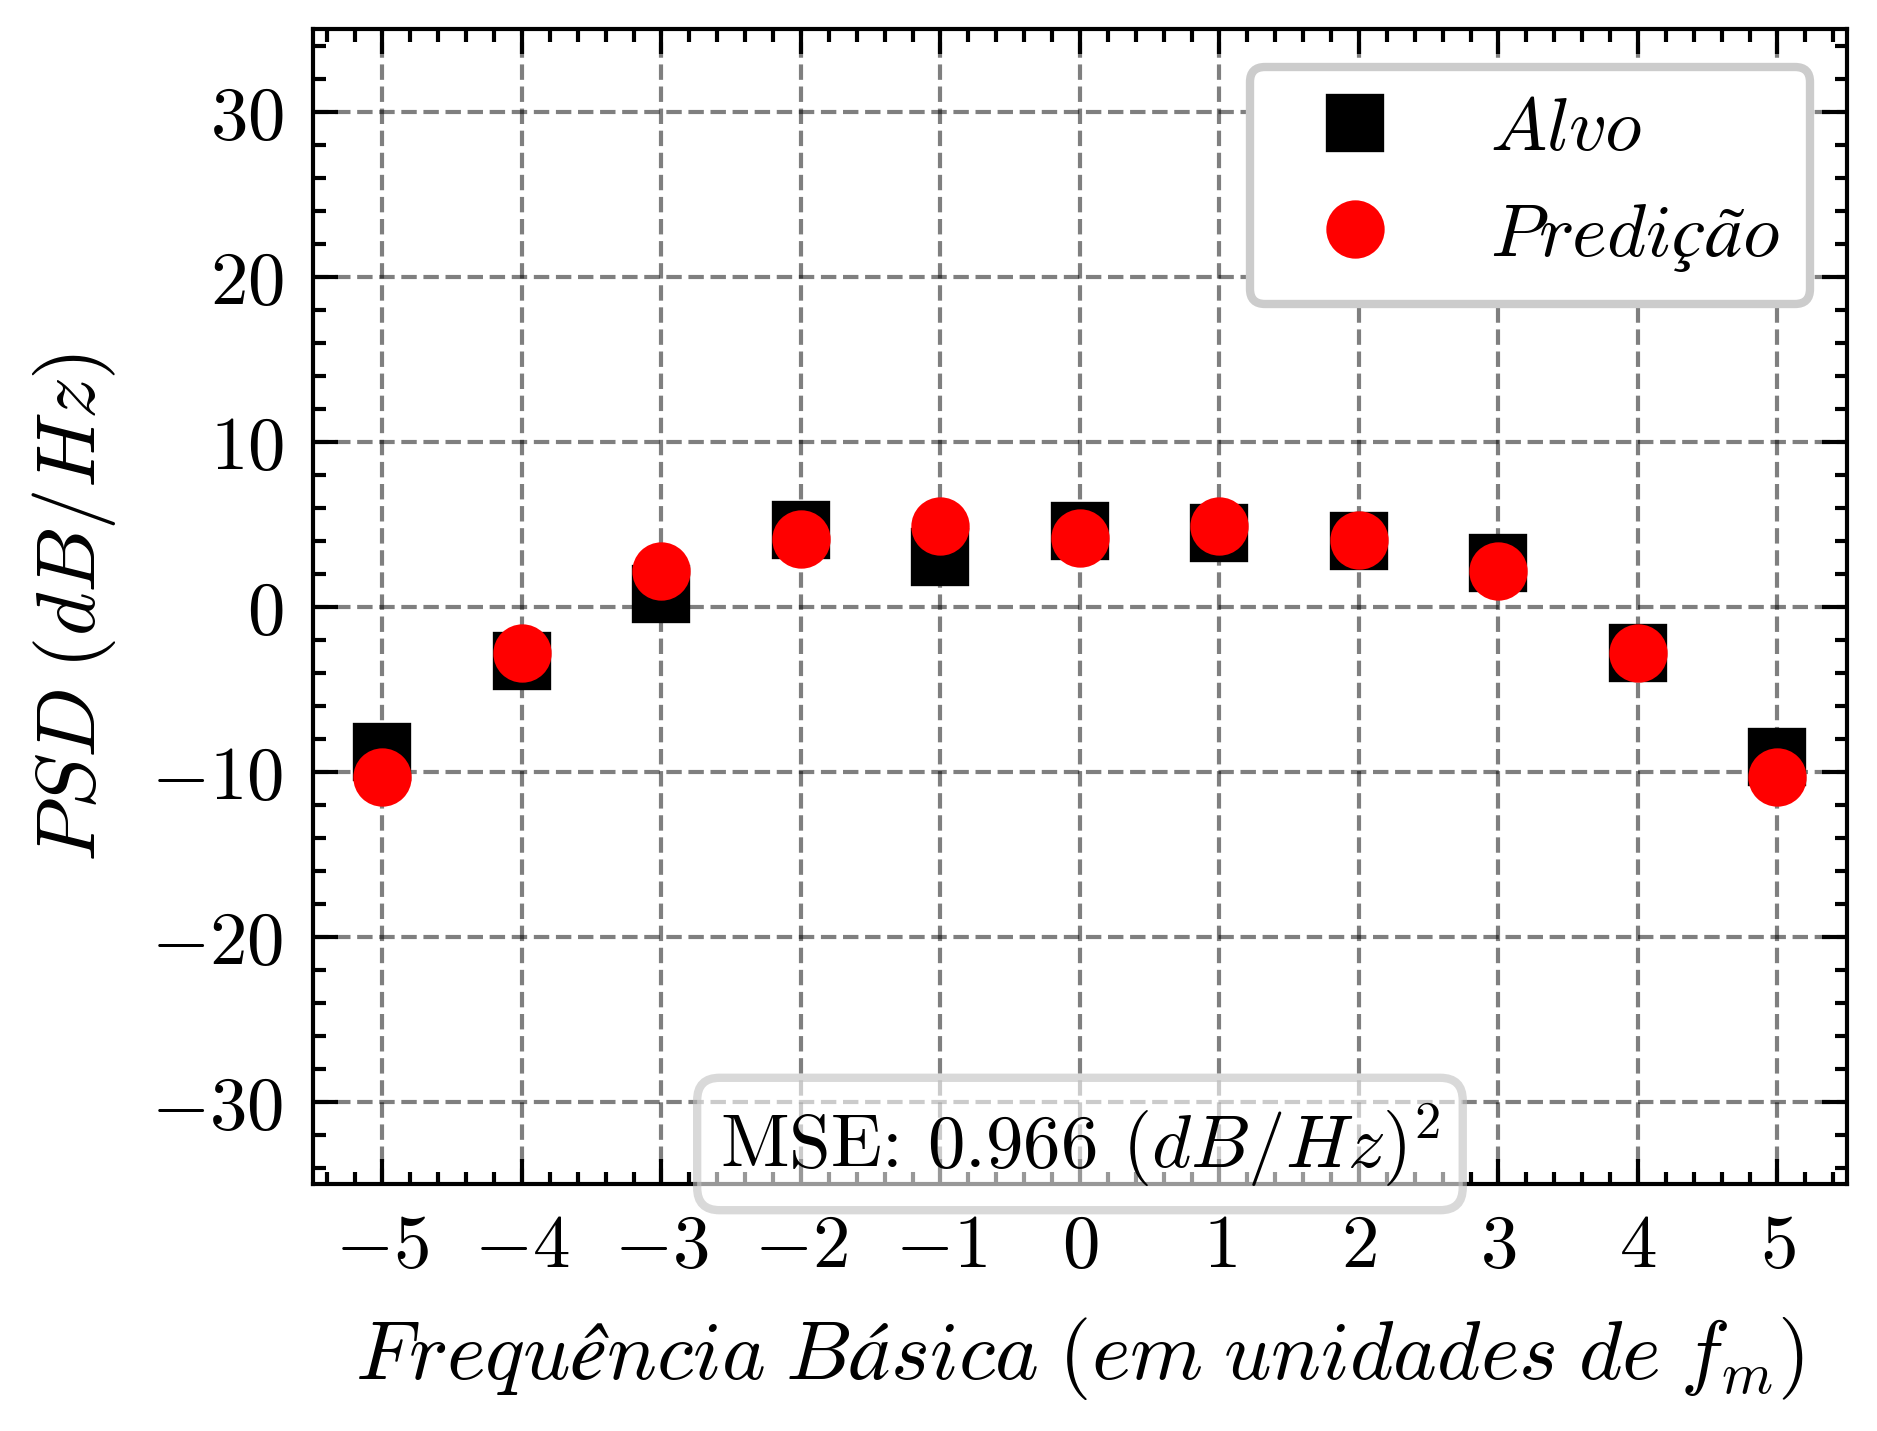

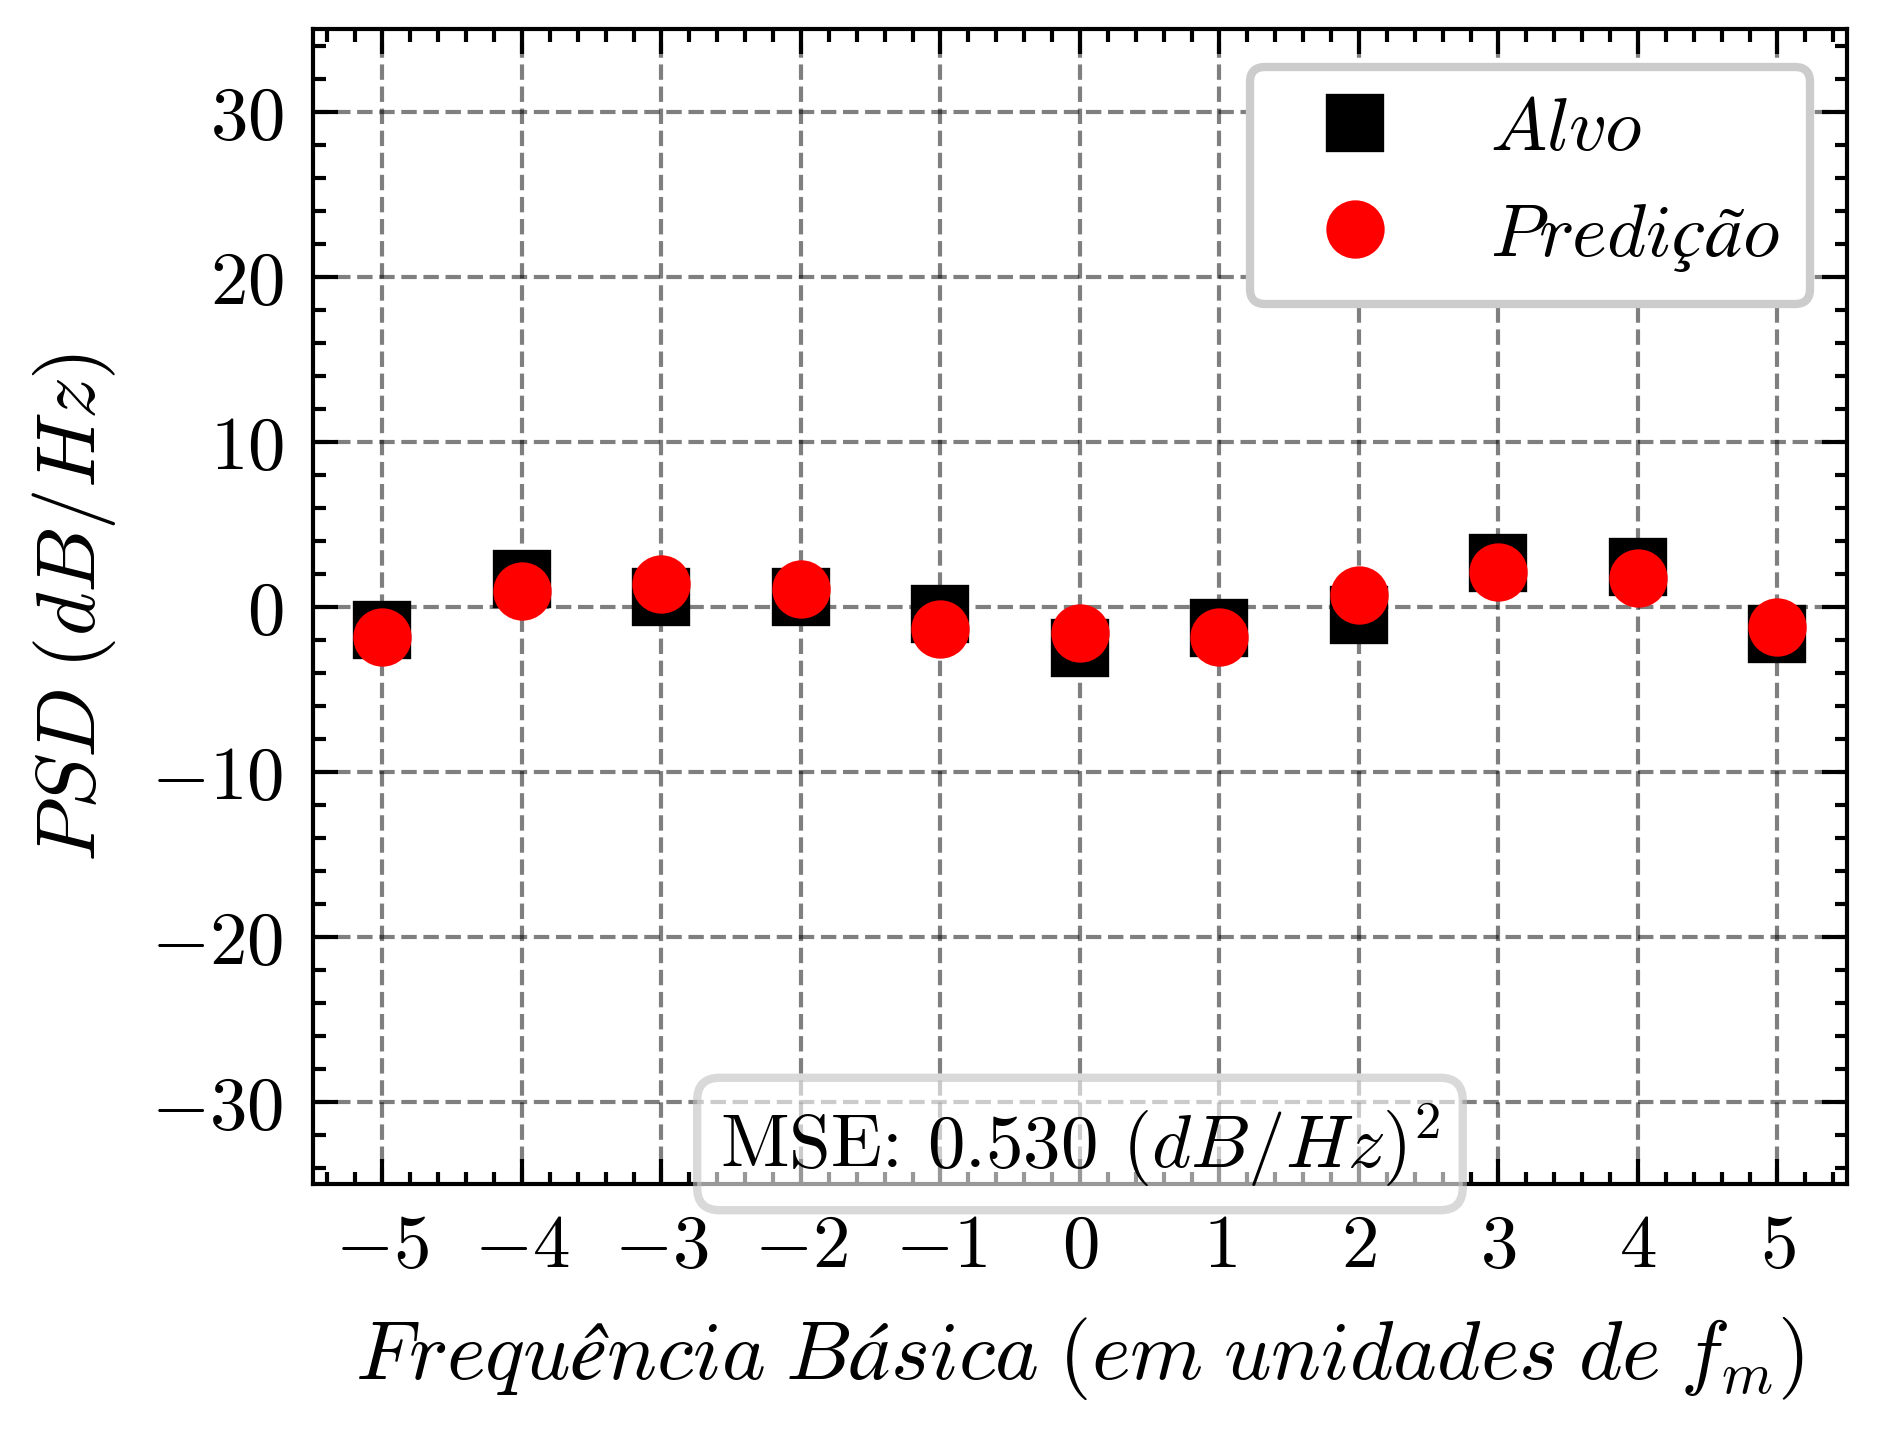

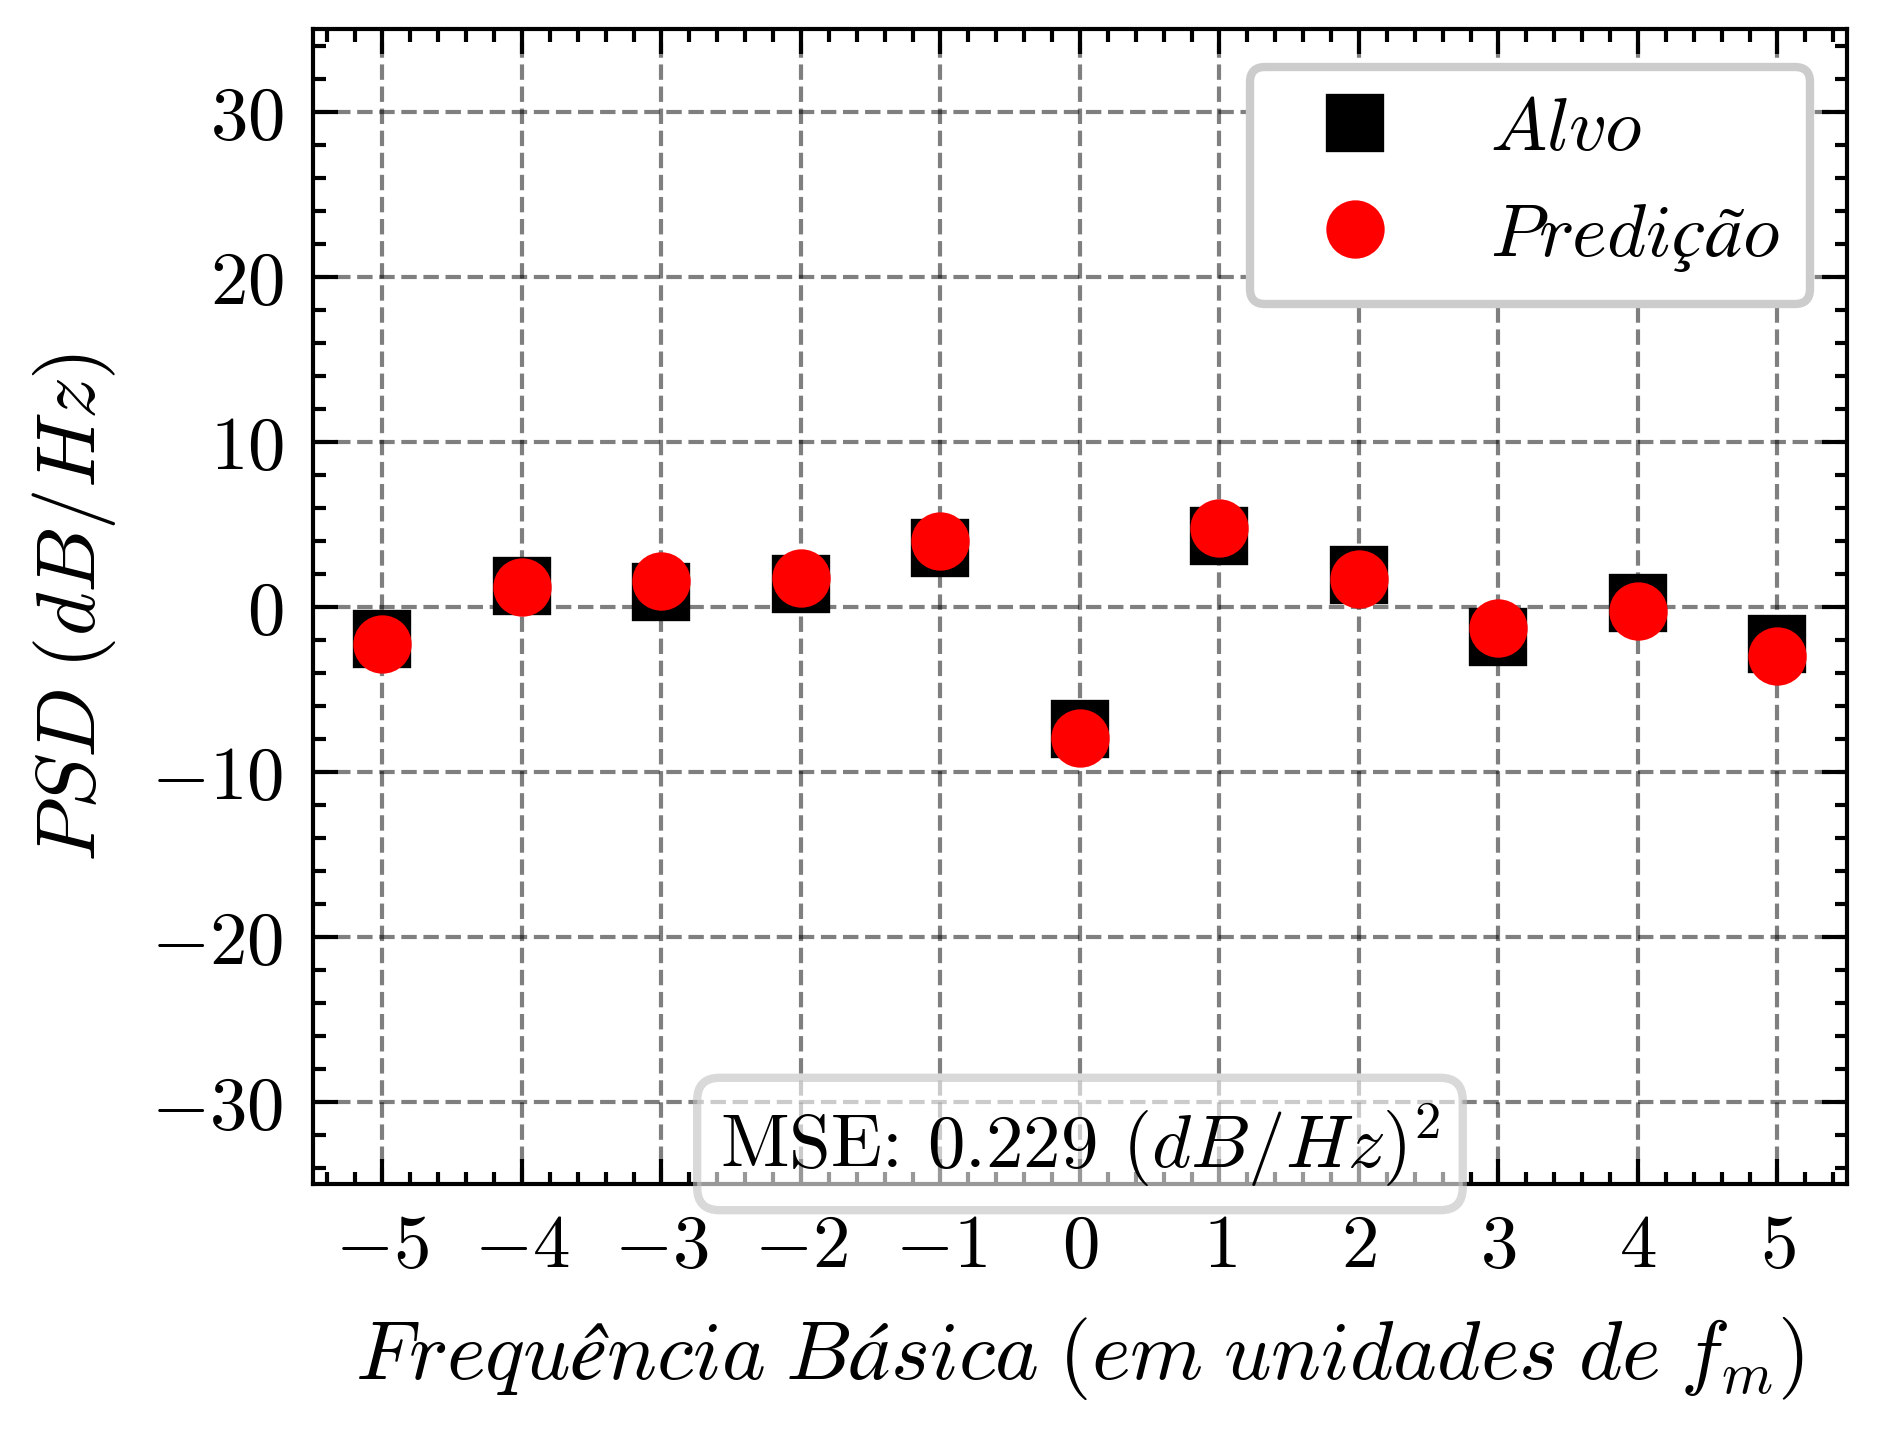

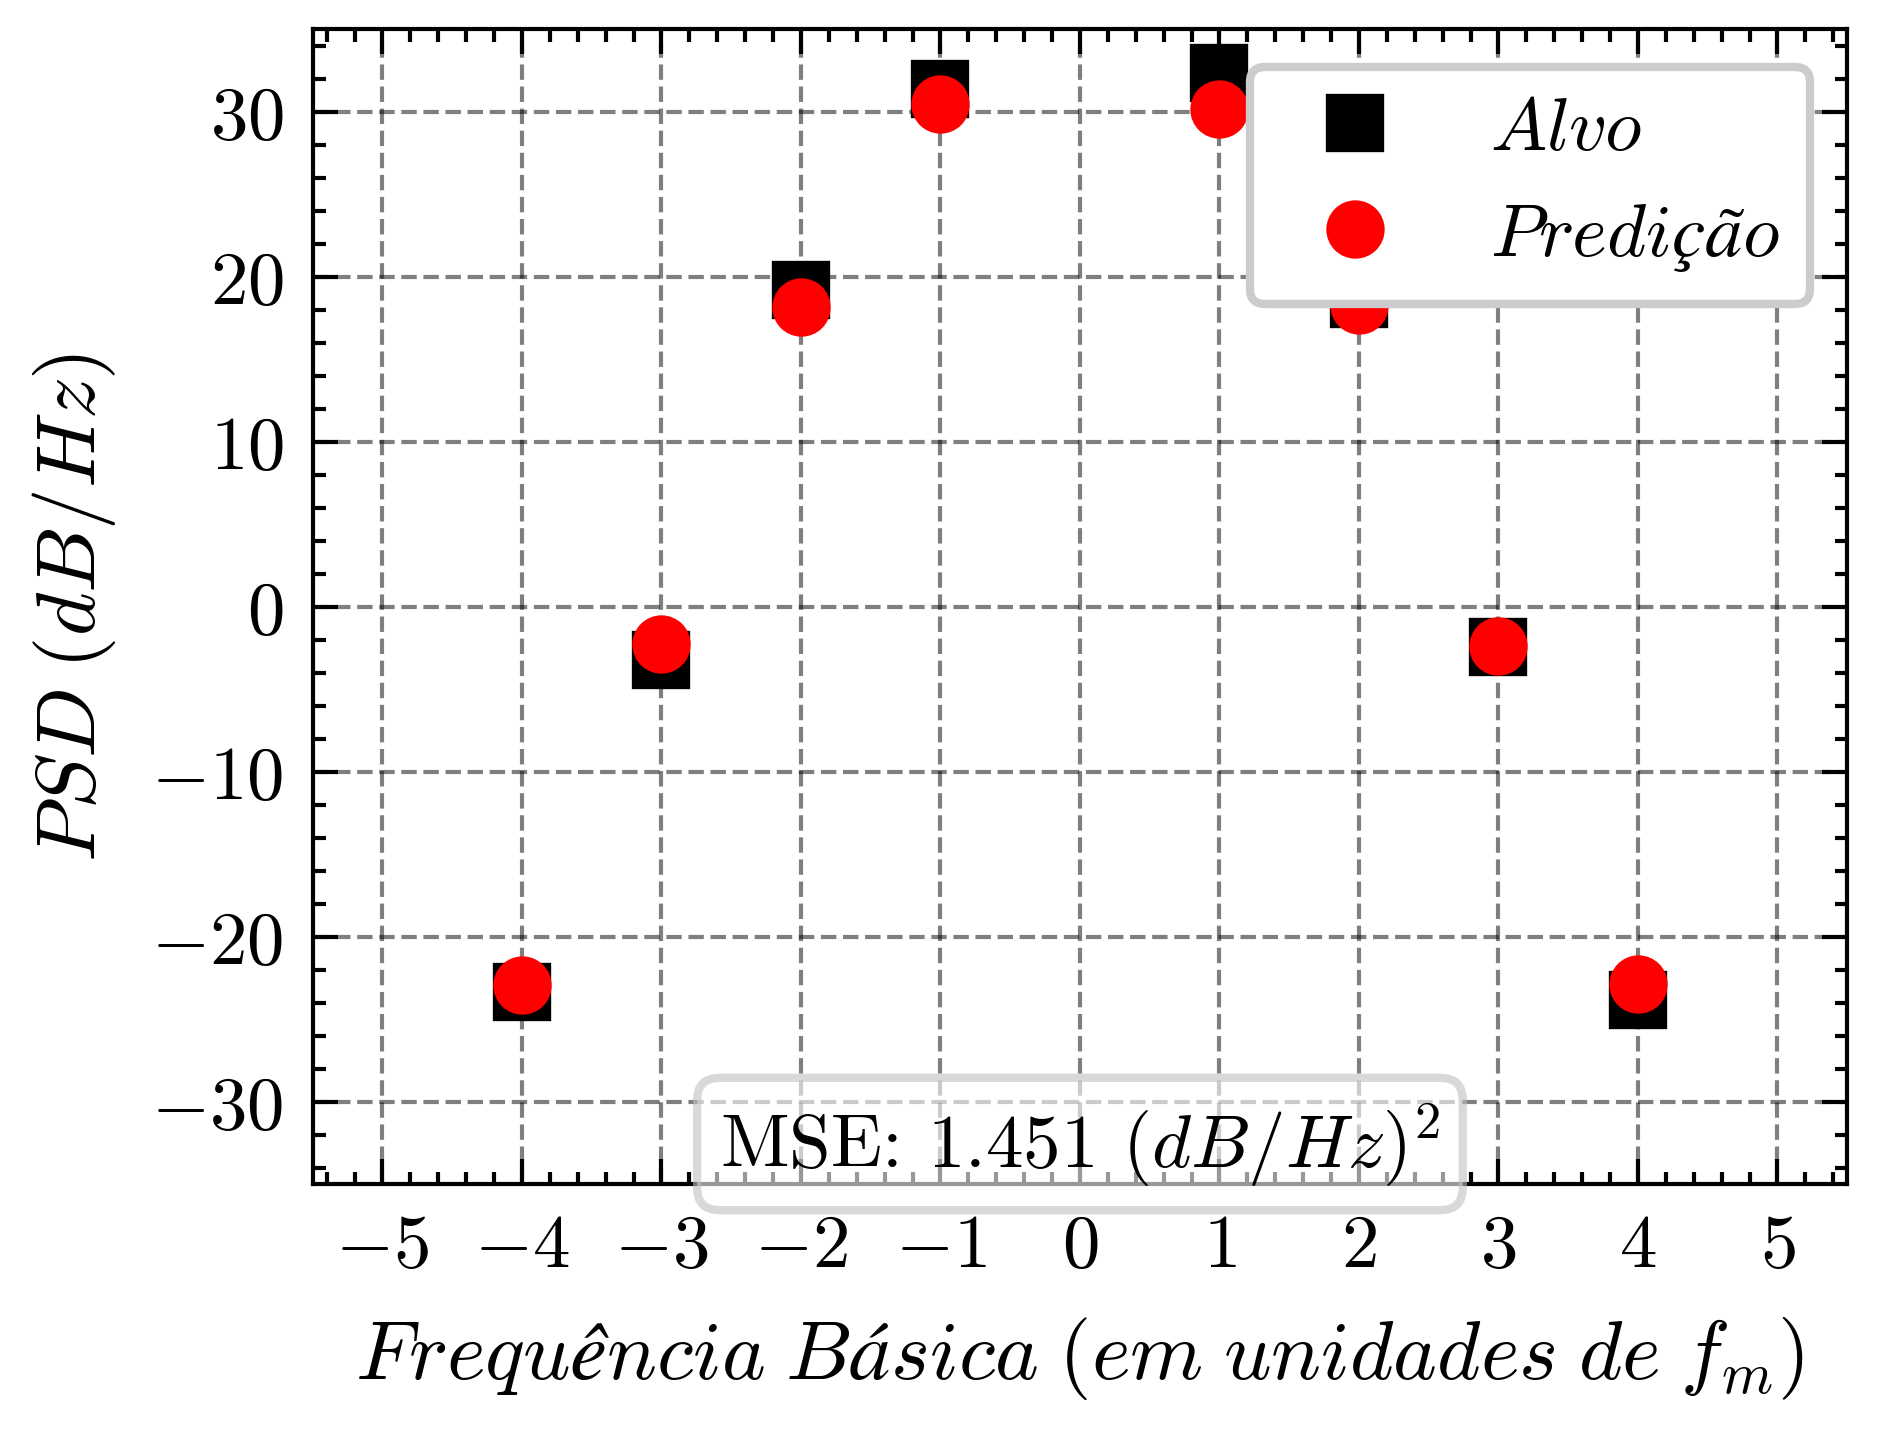

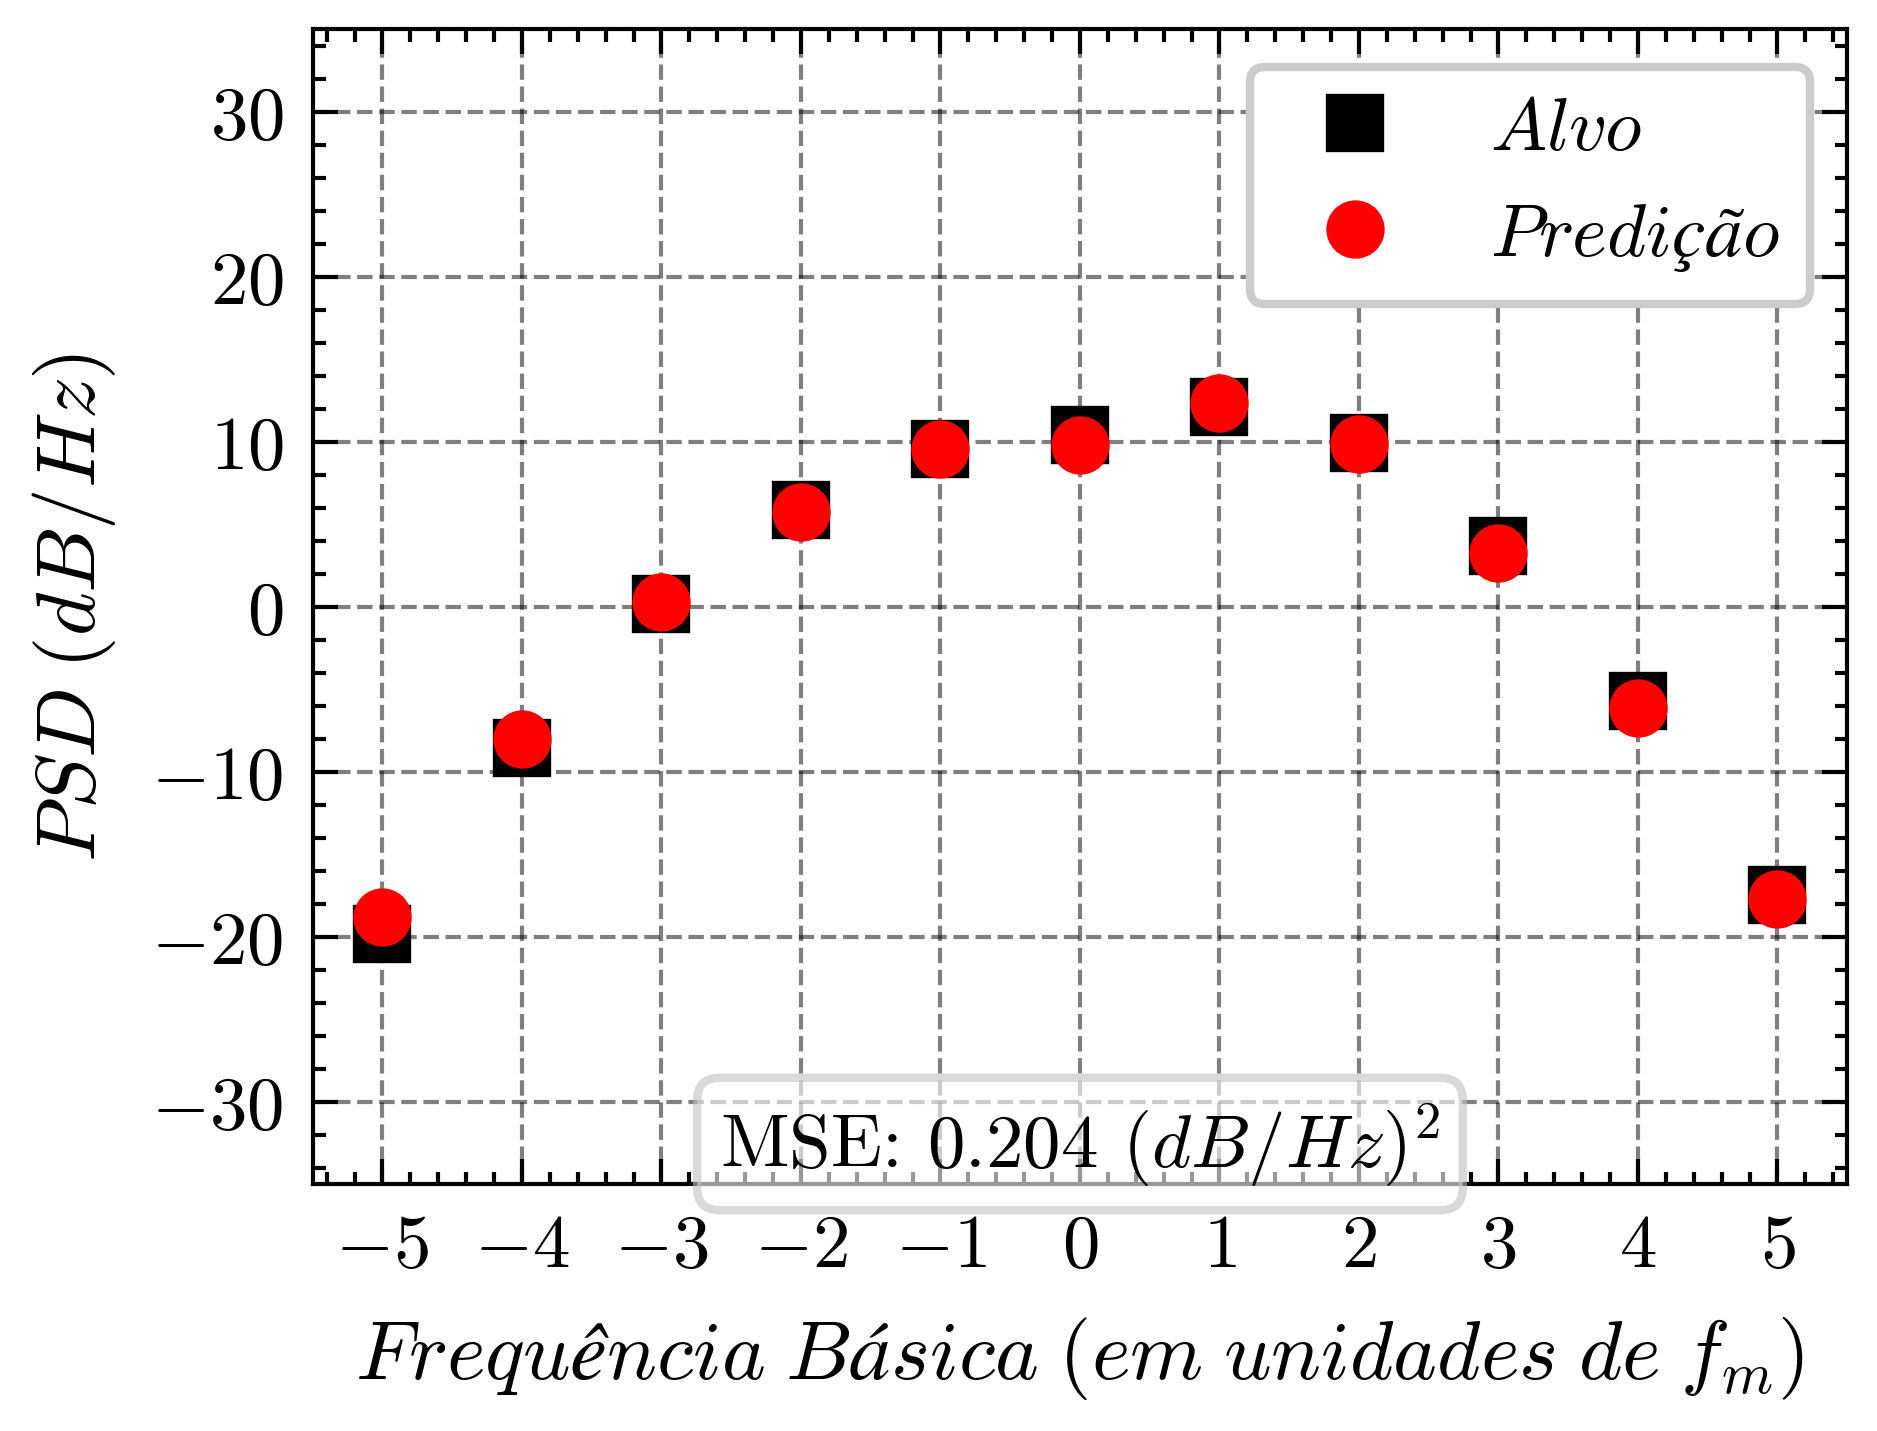

In [139]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", test_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(5, targets.shape[0])):

    #inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args).to(device)
    inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)

    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)*dataset.zero_mean
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i].unsqueeze(0))
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    
    title = ''
    figname = "figures/inv_forward/" + f"inv_forward_sample_{i+1}.png"

    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title)

## <a id='toc2_4_'></a>[Inverse Network - Differentiable OFC Generator](#toc0_)

In [12]:
# Create data loaders
batch_size = 120
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
#flat_loader = DataLoader(flatComb_0_1dB_dataset, batch_size = batch_size, shuffle=True)

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

In [13]:

# Create an inverse model
inverse_architecture = [n_outputs, 290, 290, 290, 290, 290, 290, n_inputs]
inverse_architecture = [n_outputs, 345, 345, 345, 345, 345, 345, n_inputs]
inverse_net = FrequencyCombNet(inverse_architecture).to(device)

inverse_net_name = "model_inverse_diffgen" + "_".join([f"{n:.0f}" for n in inverse_architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"
#inverse_net_name = 'model_inv_for_9_128_256_256_128_5_ddmzm_100k_samples_FalseZeroMean_batch_size_110inverse_net'

inverse_net_path = "saved_data/models/"+ inverse_net_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = 8.5e-6) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(inverse_net_path):
    print("Loading model...")
    checkpoint = torch.load(inverse_net_path, map_location=torch.device(device), weights_only=False)
    inverse_net.load_state_dict(checkpoint['model_state_dict'])
    inv_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(inverse_net_name)
    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

Loading model...
model_inverse_diffgen31_345_345_345_345_345_345_7_pm_pm_mzm_320k_samples_TrueZeroMean_batch_size_120
Model and Optimizer loaded!


In [14]:
## losses
inv_losses_path = "saved_data/losses/" + inverse_net_name + '_losses.npz'

# Load training losses if file exists
if os.path.exists(inv_losses_path):
    losses = np.load(inv_losses_path)
    train_losses = list(losses['train_losses'])
    val_losses = list(losses['val_losses'])
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

val_loss_min = 1


Losses files loaded!


Validation loss decreased (0.000144 --> 0.000141). Epoch: 7. Saving model...
Epoch: 250/2500... Training loss: 16.127157 (dB/Hz)^2 ... Validation Loss: 15.491116 (dB/Hz)^2


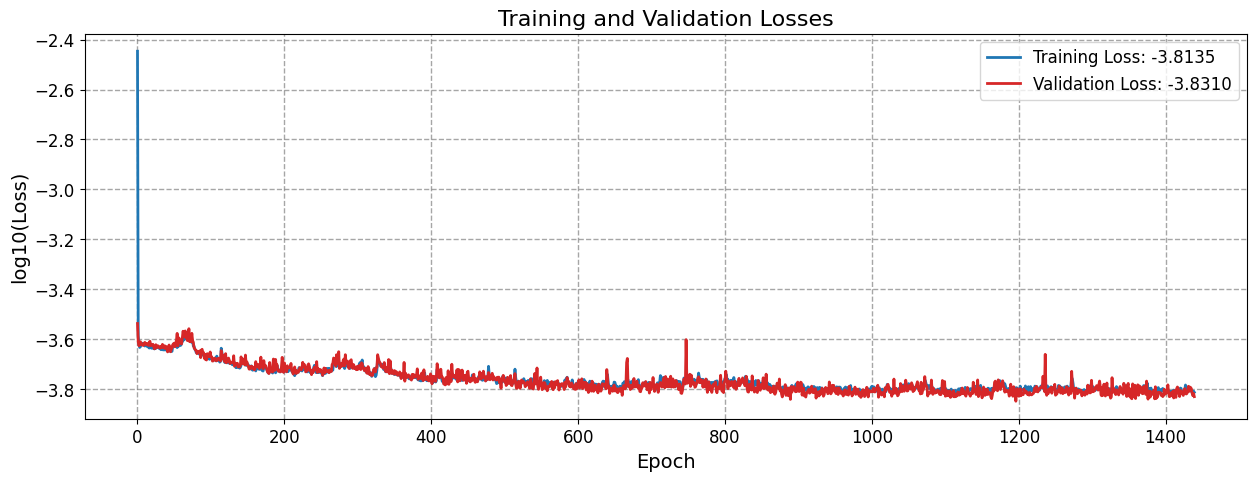

Epoch: 500/2500... Training loss: 15.901041 (dB/Hz)^2 ... Validation Loss: 16.633955 (dB/Hz)^2


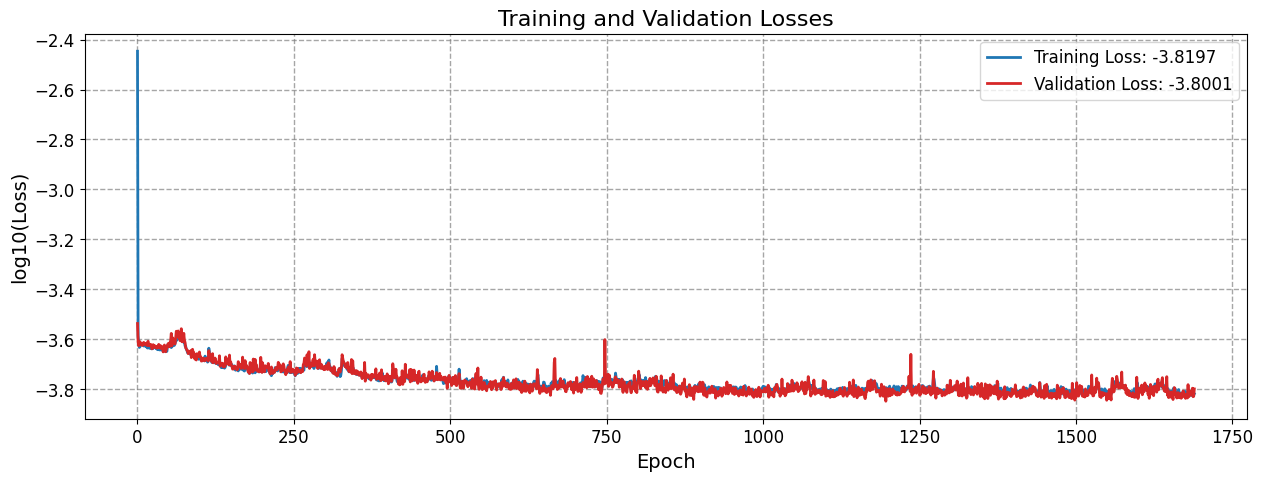

Validation loss decreased (0.000141 --> 0.000140). Epoch: 504. Saving model...
Validation loss decreased (0.000140 --> 0.000139). Epoch: 565. Saving model...
Validation loss decreased (0.000139 --> 0.000139). Epoch: 571. Saving model...
Epoch: 750/2500... Training loss: 15.910066 (dB/Hz)^2 ... Validation Loss: 15.429653 (dB/Hz)^2


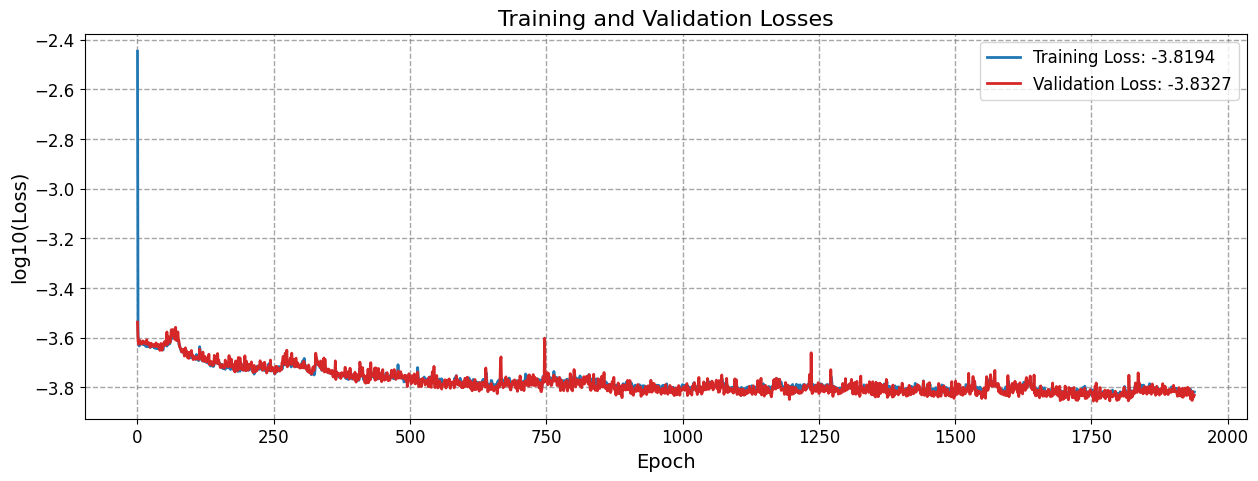

Validation loss decreased (0.000139 --> 0.000139). Epoch: 851. Saving model...
Validation loss decreased (0.000139 --> 0.000135). Epoch: 882. Saving model...
Epoch: 1000/2500... Training loss: 15.871778 (dB/Hz)^2 ... Validation Loss: 15.733887 (dB/Hz)^2


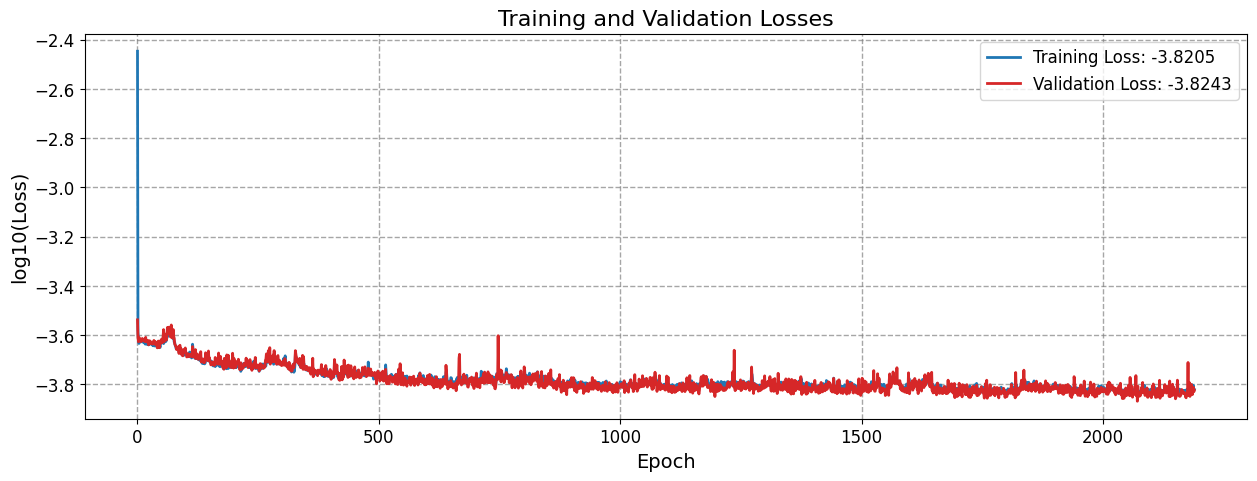

Epoch: 1250/2500... Training loss: 15.310993 (dB/Hz)^2 ... Validation Loss: 16.392971 (dB/Hz)^2


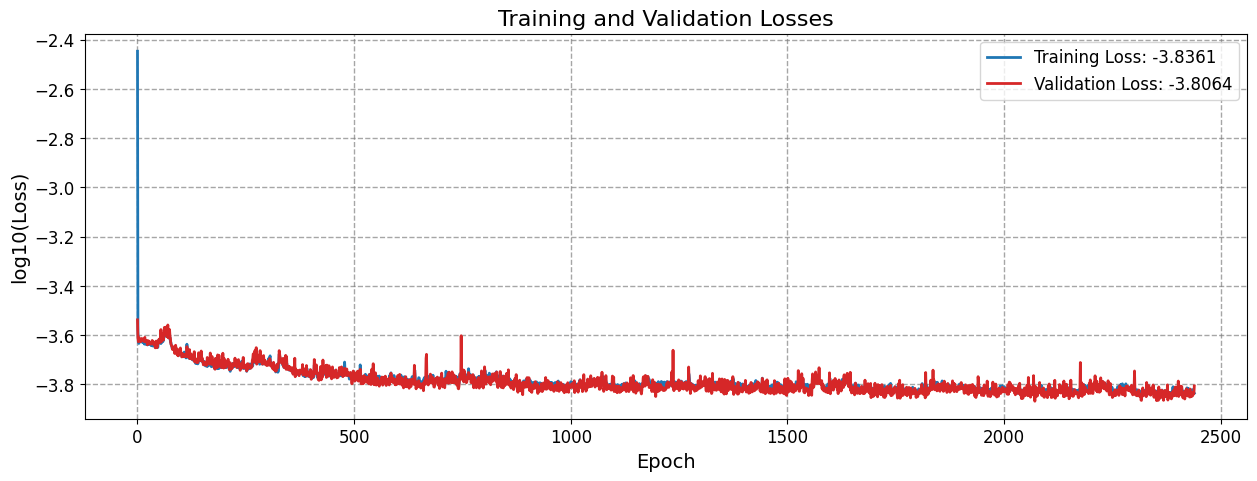

Validation loss decreased (0.000135 --> 0.000135). Epoch: 1277. Saving model...
Validation loss decreased (0.000135 --> 0.000135). Epoch: 1372. Saving model...
Validation loss decreased (0.000135 --> 0.000134). Epoch: 1402. Saving model...
Validation loss decreased (0.000134 --> 0.000134). Epoch: 1407. Saving model...
Validation loss decreased (0.000134 --> 0.000132). Epoch: 1438. Saving model...
Epoch: 1500/2500... Training loss: 15.263359 (dB/Hz)^2 ... Validation Loss: 16.071007 (dB/Hz)^2


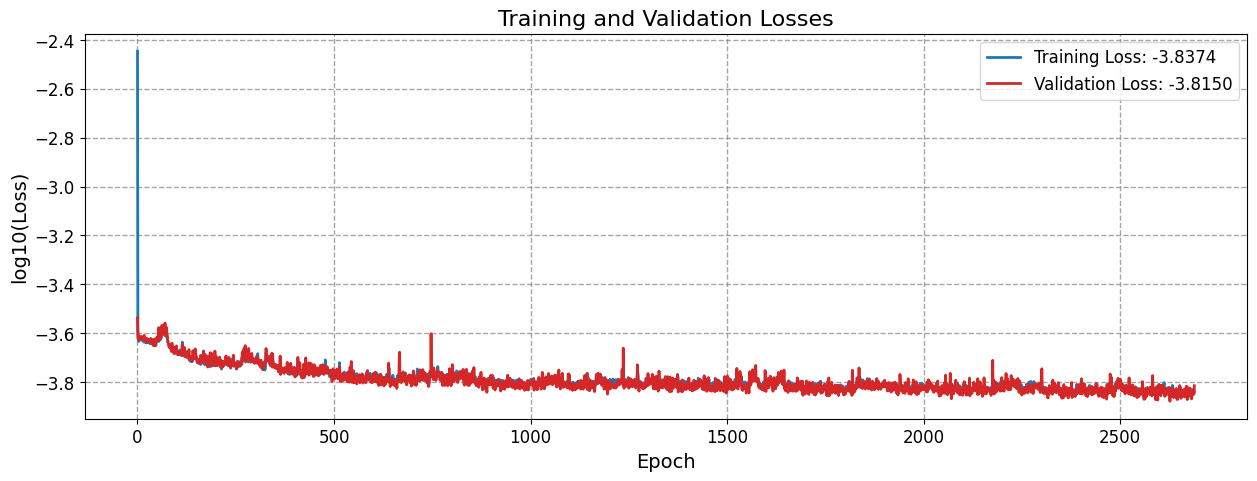

Validation loss decreased (0.000132 --> 0.000132). Epoch: 1543. Saving model...
Validation loss decreased (0.000132 --> 0.000130). Epoch: 1616. Saving model...
Epoch: 1750/2500... Training loss: 14.904778 (dB/Hz)^2 ... Validation Loss: 15.168687 (dB/Hz)^2


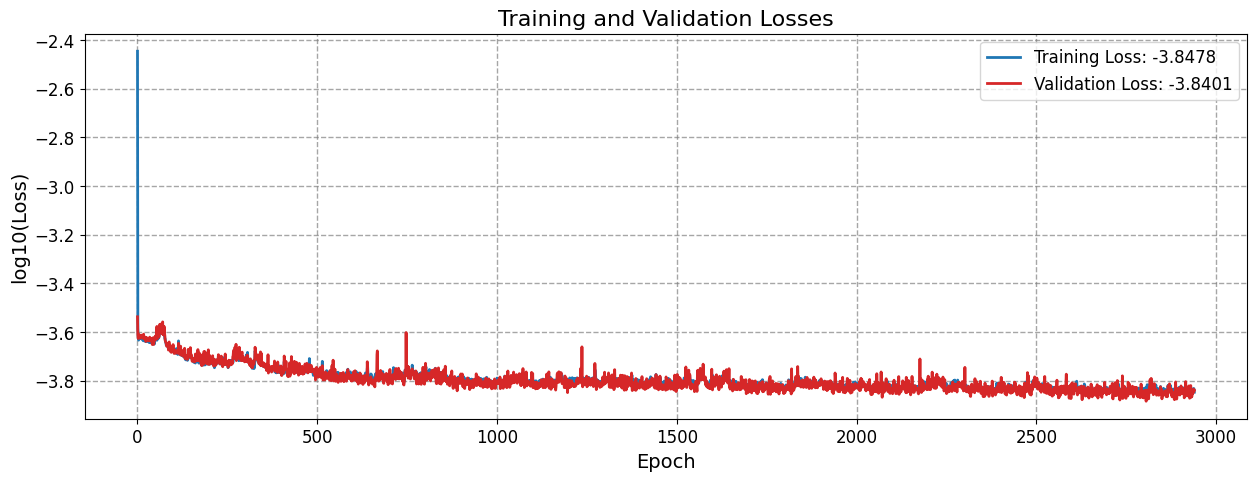

Validation loss decreased (0.000130 --> 0.000130). Epoch: 1848. Saving model...
Epoch: 2000/2500... Training loss: 14.807092 (dB/Hz)^2 ... Validation Loss: 14.157786 (dB/Hz)^2


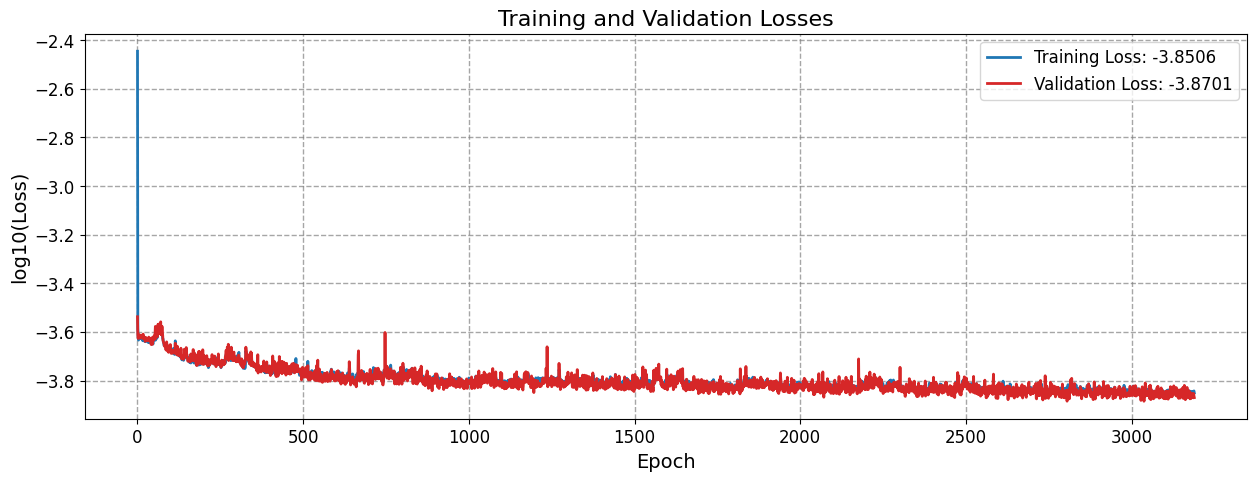

Validation loss decreased (0.000130 --> 0.000128). Epoch: 2001. Saving model...
Epoch: 2250/2500... Training loss: 14.579689 (dB/Hz)^2 ... Validation Loss: 14.614754 (dB/Hz)^2


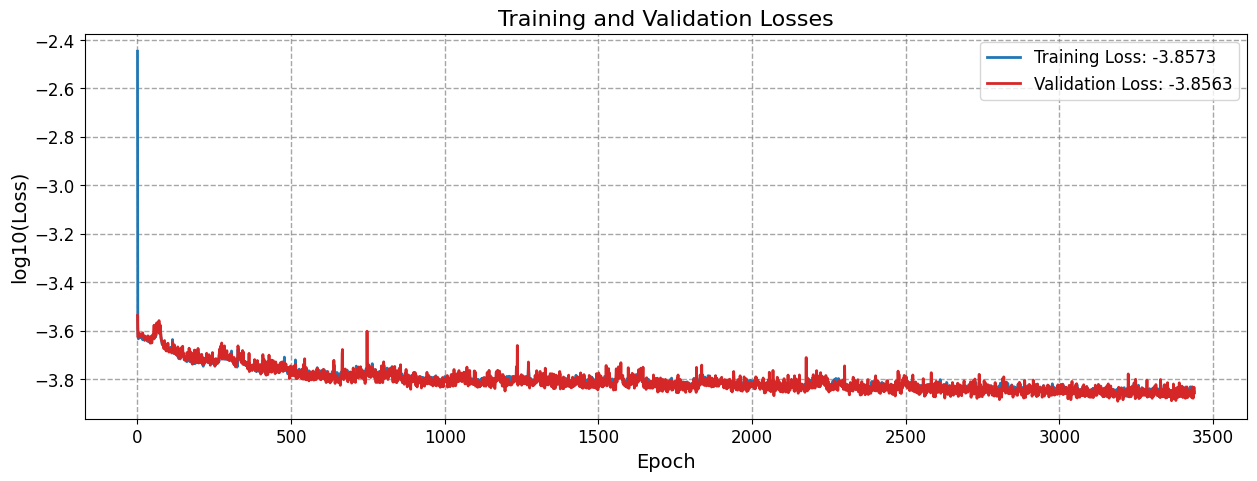

Epoch: 2500/2500... Training loss: 15.108182 (dB/Hz)^2 ... Validation Loss: 15.342046 (dB/Hz)^2


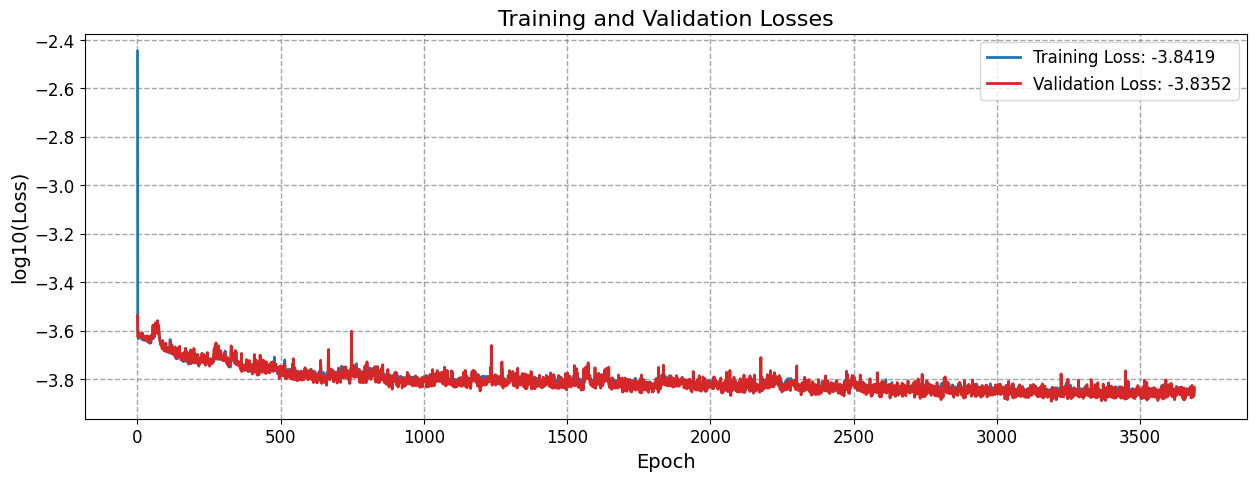

CPU times: total: 7h 11min 41s
Wall time: 7h 51min 20s


In [24]:
%%time

num_epochs = 2500

PATIENCE = 1000
patience_counter = 0

for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, _, _, _, _ = run_one_epoch_inverse_DiffGen("train", train_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device, inv_optimizer)
    train_losses.append(avg_train_loss)

    # Validation phase
    avg_val_loss, _, _, _, _ = run_one_epoch_inverse_DiffGen("val", val_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device)
    val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(inverse_net.state_dict(), "saved_data/models/min_loss/"+ inverse_net_name + "val_min.pth")
        val_loss_min = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch} with validation loss: {avg_val_loss:.6f}')
            break

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")



In [25]:
# Save model
torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, inverse_net_path)

# Save training and validation losses for the inverse model
np.savez(inv_losses_path, train_losses = np.array(train_losses), val_losses = np.array(val_losses))

In [26]:
#load min loss model
model_dict_data = torch.load("saved_data/models/min_loss/"+ inverse_net_name + "val_min.pth", map_location=torch.device(device), weights_only=False)
inverse_net.load_state_dict(model_dict_data)  # Load pre-trained weights

<All keys matched successfully>

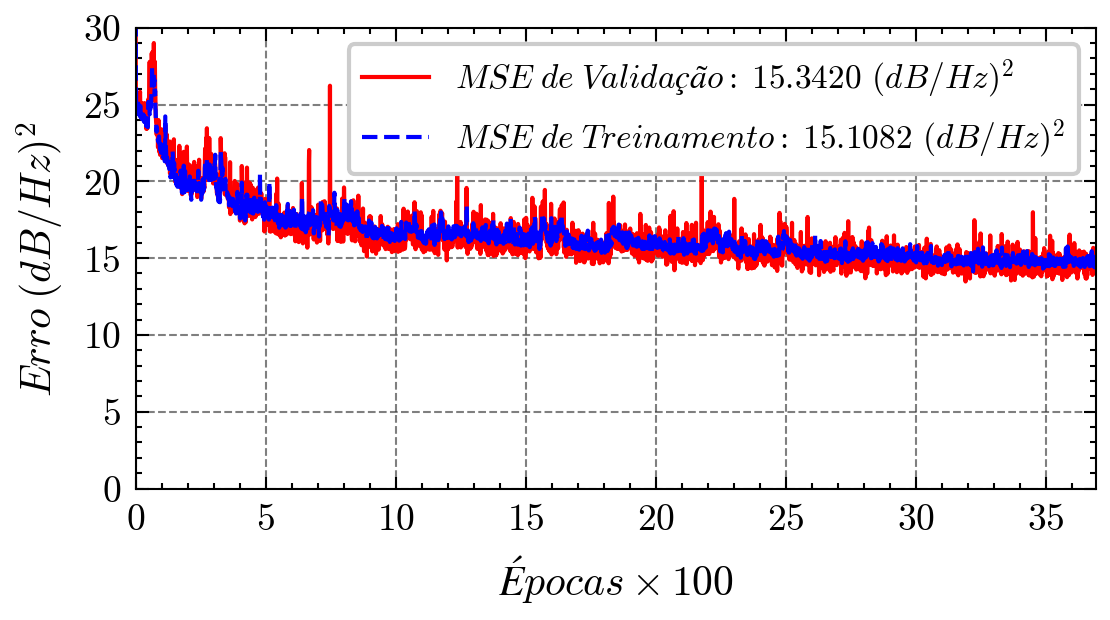

In [15]:
train_array = convert_to_real_loss(train_losses, train_dataset.norm_scales)
val_array = convert_to_real_loss(val_losses, train_dataset.norm_scales)
figname = "figures/inv_analitical/" + inverse_net_name + "_training_progress.png"

plot_training_progress_style(train_array,val_array, title = "",  average_curves = False, figname = figname, ylim = (0,30))

### <a id='toc2_4_1_'></a>[Test phase](#toc0_)

In [16]:
freqs_peaks_GHz

tensor([-15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
          9.,  10.,  11.,  12.,  13.,  14.,  15.])

C:\Users\ferna\AppData\Local\Temp\ipykernel_4340\1913627523.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian = torch.tensor(gaussian, dtype=torch.float32).unsqueeze(0).to(device)


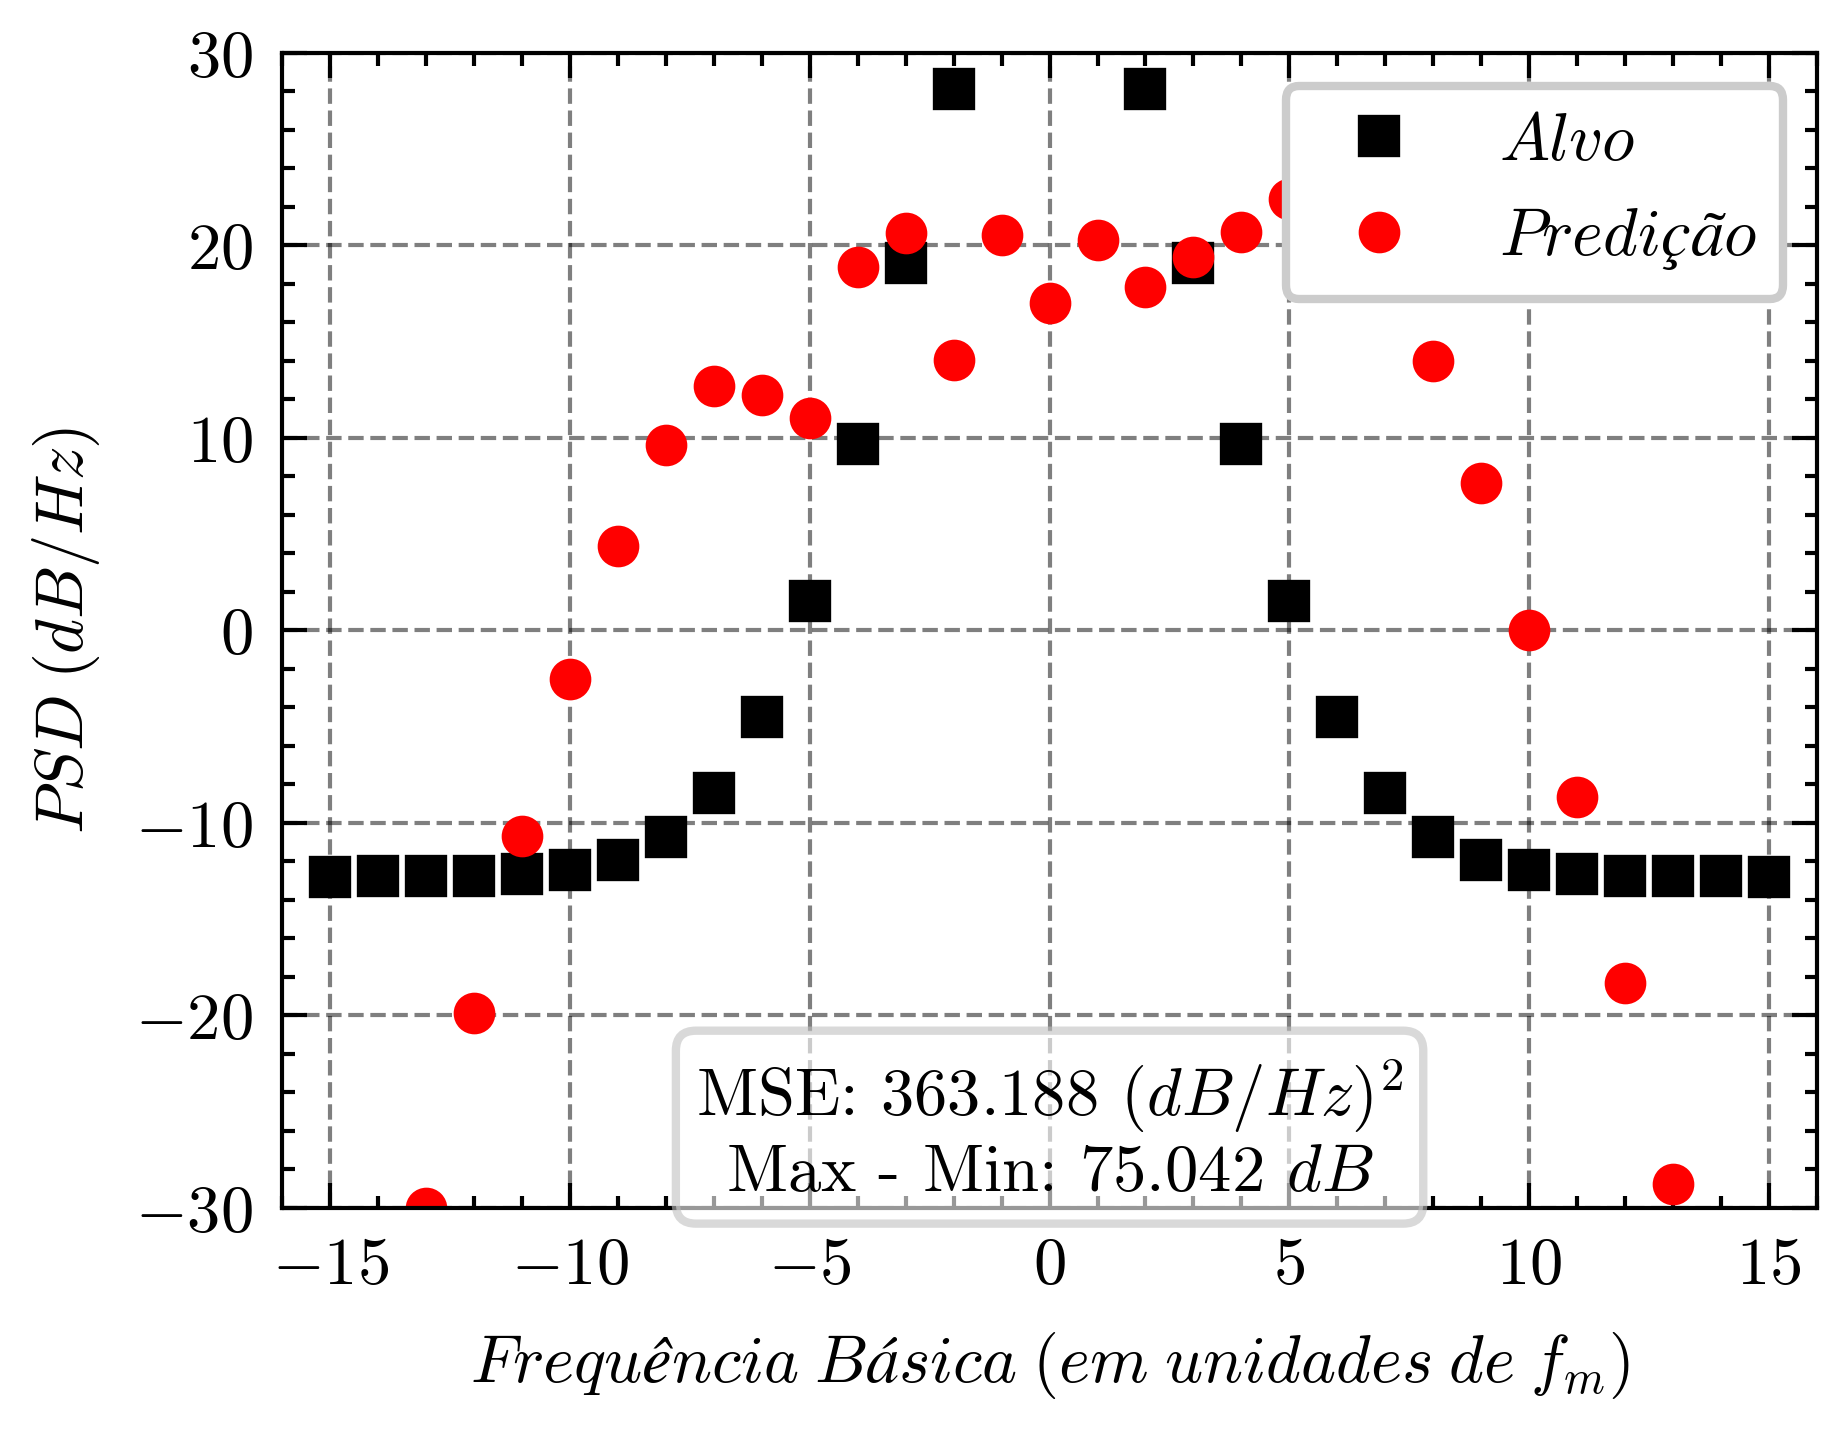

In [34]:
# Test phase

perfect_flat_comb = torch.tensor([-90]*n_outputs).unsqueeze(0).to(device) #flat comb
#perfect_flat_comb = torch.tensor([-80,-85,-90,-95,-100,-105,-100,-95,-90,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb = torch.tensor(0.5*np.arange(-5,6,1)**2, dtype=torch.float32).unsqueeze(0).to(device) #quadratic comb
#perfect_flat_comb = torch.tensor(200*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb 
#perfect_flat_comb = torch.tensor(-60*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb negative
#perfect_flat_comb = torch.tensor(-np.abs(8*np.arange(-5,6,1)), dtype=torch.float32).unsqueeze(0).to(device) #hate comb
#perfect_flat_comb = torch.tensor(3.6*np.arange(-5,6,1), dtype=torch.float32).unsqueeze(0).to(device) # linear comb
#perfect_flat_comb = -2.5*torch.tensor([-80,-85,-80,-85,-80,-85,-80,-85,-80,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb[0,5]= -115 #hole

def gaussian_target(a: float = 0.01):
    gaussian = 50*np.exp(-freqs_peaks_GHz**2/(2000*a**2))
    gaussian = torch.tensor(gaussian, dtype=torch.float32).unsqueeze(0).to(device)
    return gaussian

perfect_flat_comb = gaussian_target(0.1)

# Test FlatComb
perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype = torch.float32) * train_loader.dataset.zero_mean
perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

#inverse_peaks = frequencyCombPeaks(perfect_flat_comb_inv_output.to("cpu"), ofc_args).to(device)
inverse_peaks = frequencyCombPeaks(perfect_flat_comb_inv_output.to("cpu"), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)

inverse_peaks = inverse_peaks - torch.mean(inverse_peaks) * train_loader.dataset.zero_mean
inverse_peaks = train_dataset.normalize(inverse_peaks)

inv_loss = criterion(perfect_flat_comb, inverse_peaks).item()
inv_loss = convert_to_real_loss(inv_loss, train_dataset.norm_scales).item()

perfect_flat_comb_denorm = train_dataset.denormalize(perfect_flat_comb).cpu().detach().numpy().squeeze()
inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks).cpu().detach().numpy().squeeze()

# Plot the Comparison
title = ''
figname = 'figures/fig_inverse_hat_comb'
figname = 'figures/fig_inverse_hole_comb'
figname = 'figures/inverseNet_sample3'
figname = 'figures/fig_inverse_flat_comb'
figname = 'figures/fig_inverse_linear_comb'
figname = 'figures/fig_inverse_gaussian_comb'
figname = 'figures/fig_inverse_flat_comb'

figname = 'figures/inv_analitical/inv_analitical_perfect_flat_comb.png'


#plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inv_loss, figname, title, show_max_min=False)
plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inv_loss, figname, title, show_max_min=True, ylim = (-30,30))

In [ ]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse_DiffGen("test", flat_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(5, targets.shape[0])):

    #inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args).to(device)
    inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)

    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks) * train_loader.dataset.zero_mean
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    print(targets_denorm.shape, inverse_peaks_denorm.shape)

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    title = ''
    figname = "figures/inv_analitical/" + f"inv_analitical_flat_sample_{i+1}.png"
    
    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title, show_max_min=True, ylim = (-3,3))


Test Loss: 15.434807 (dB/Hz)^2


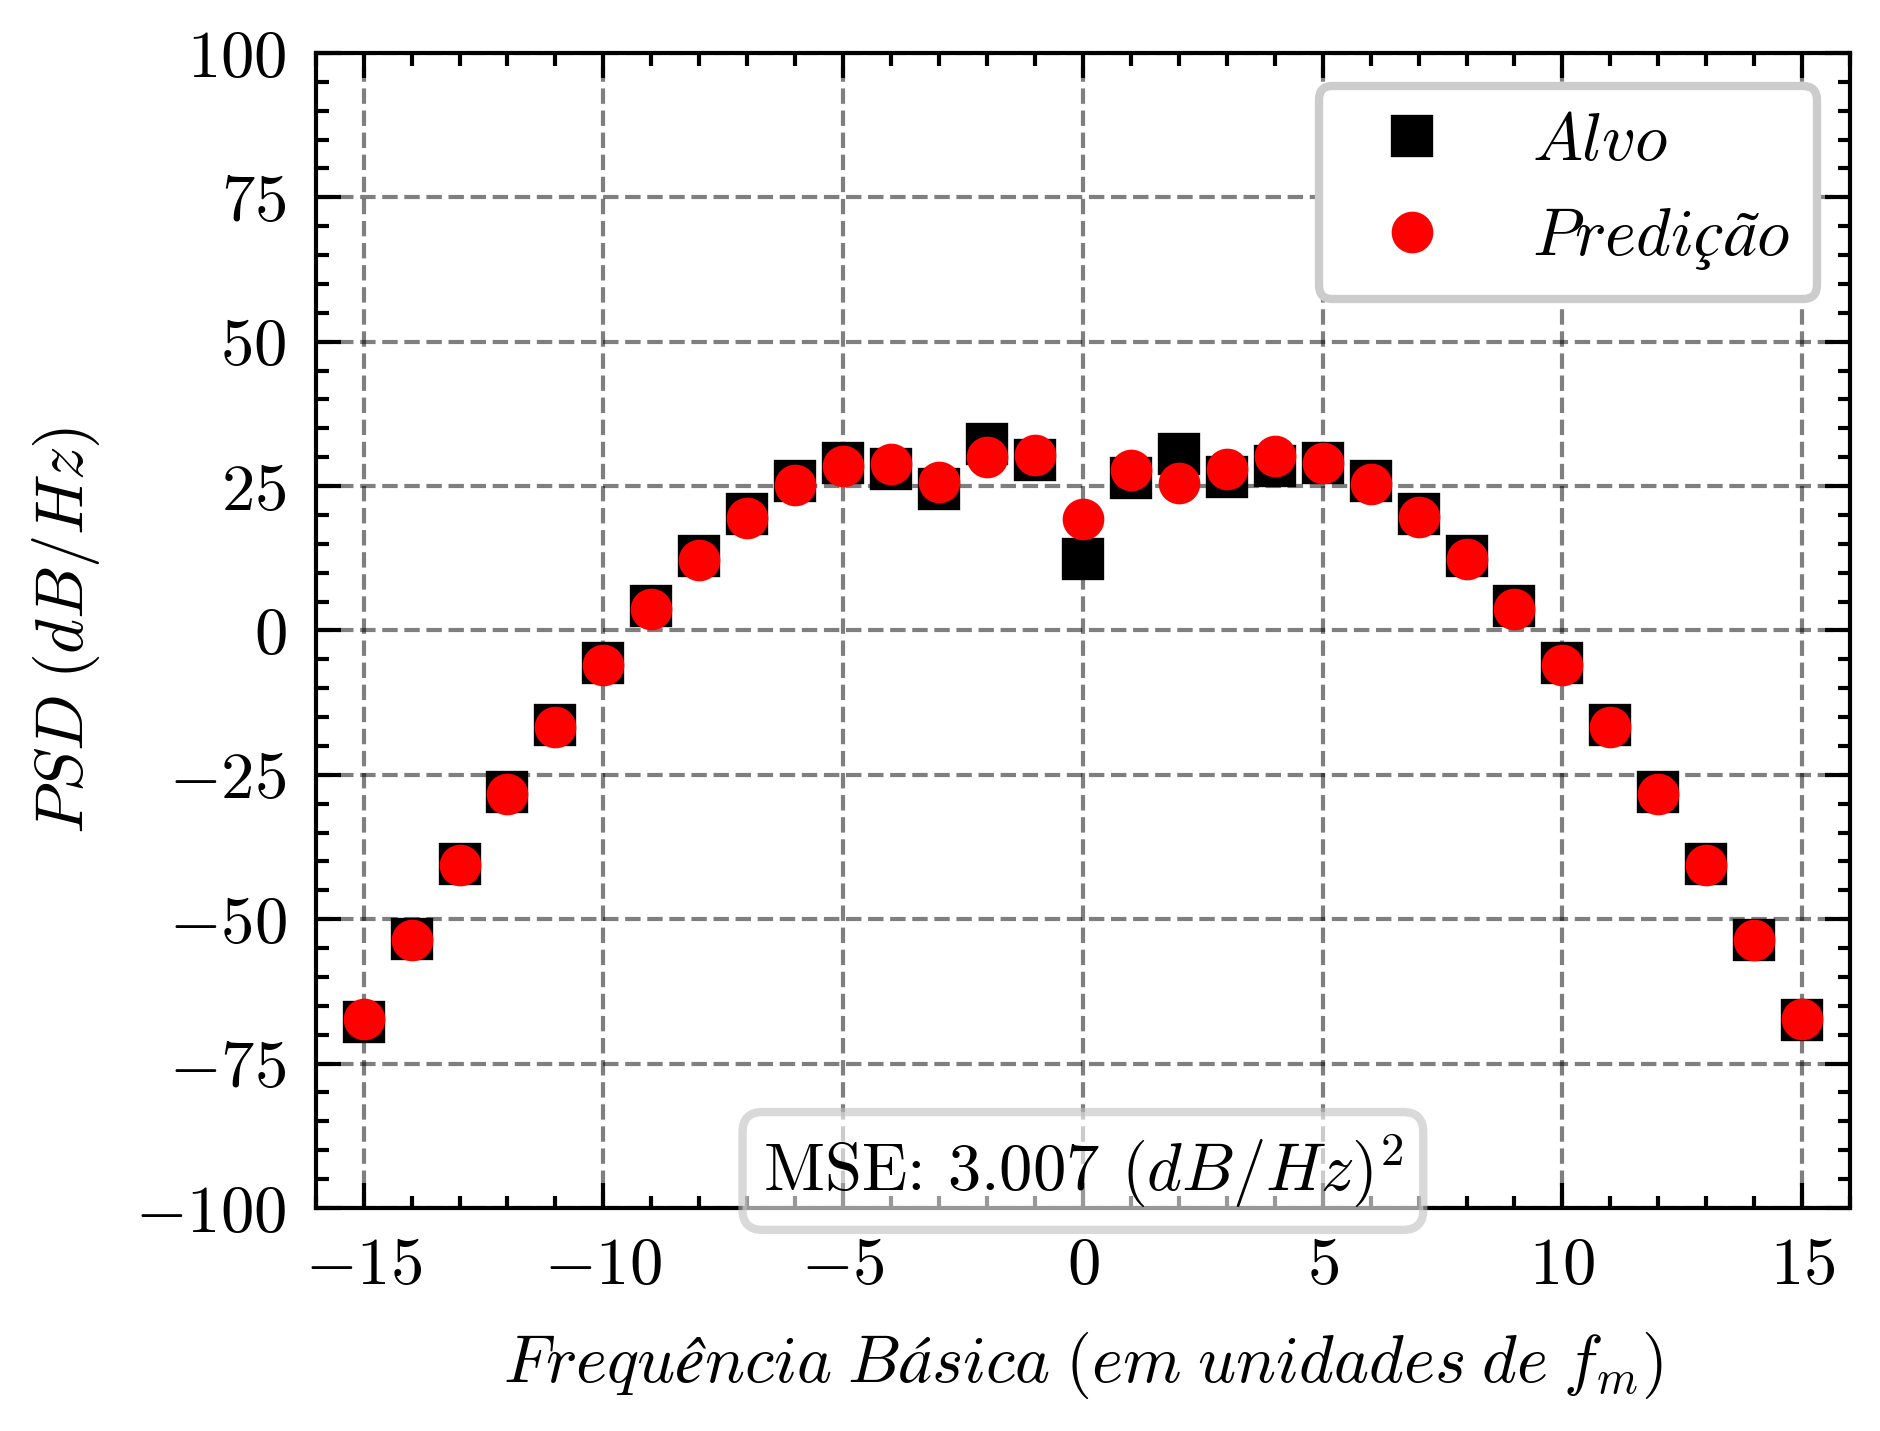

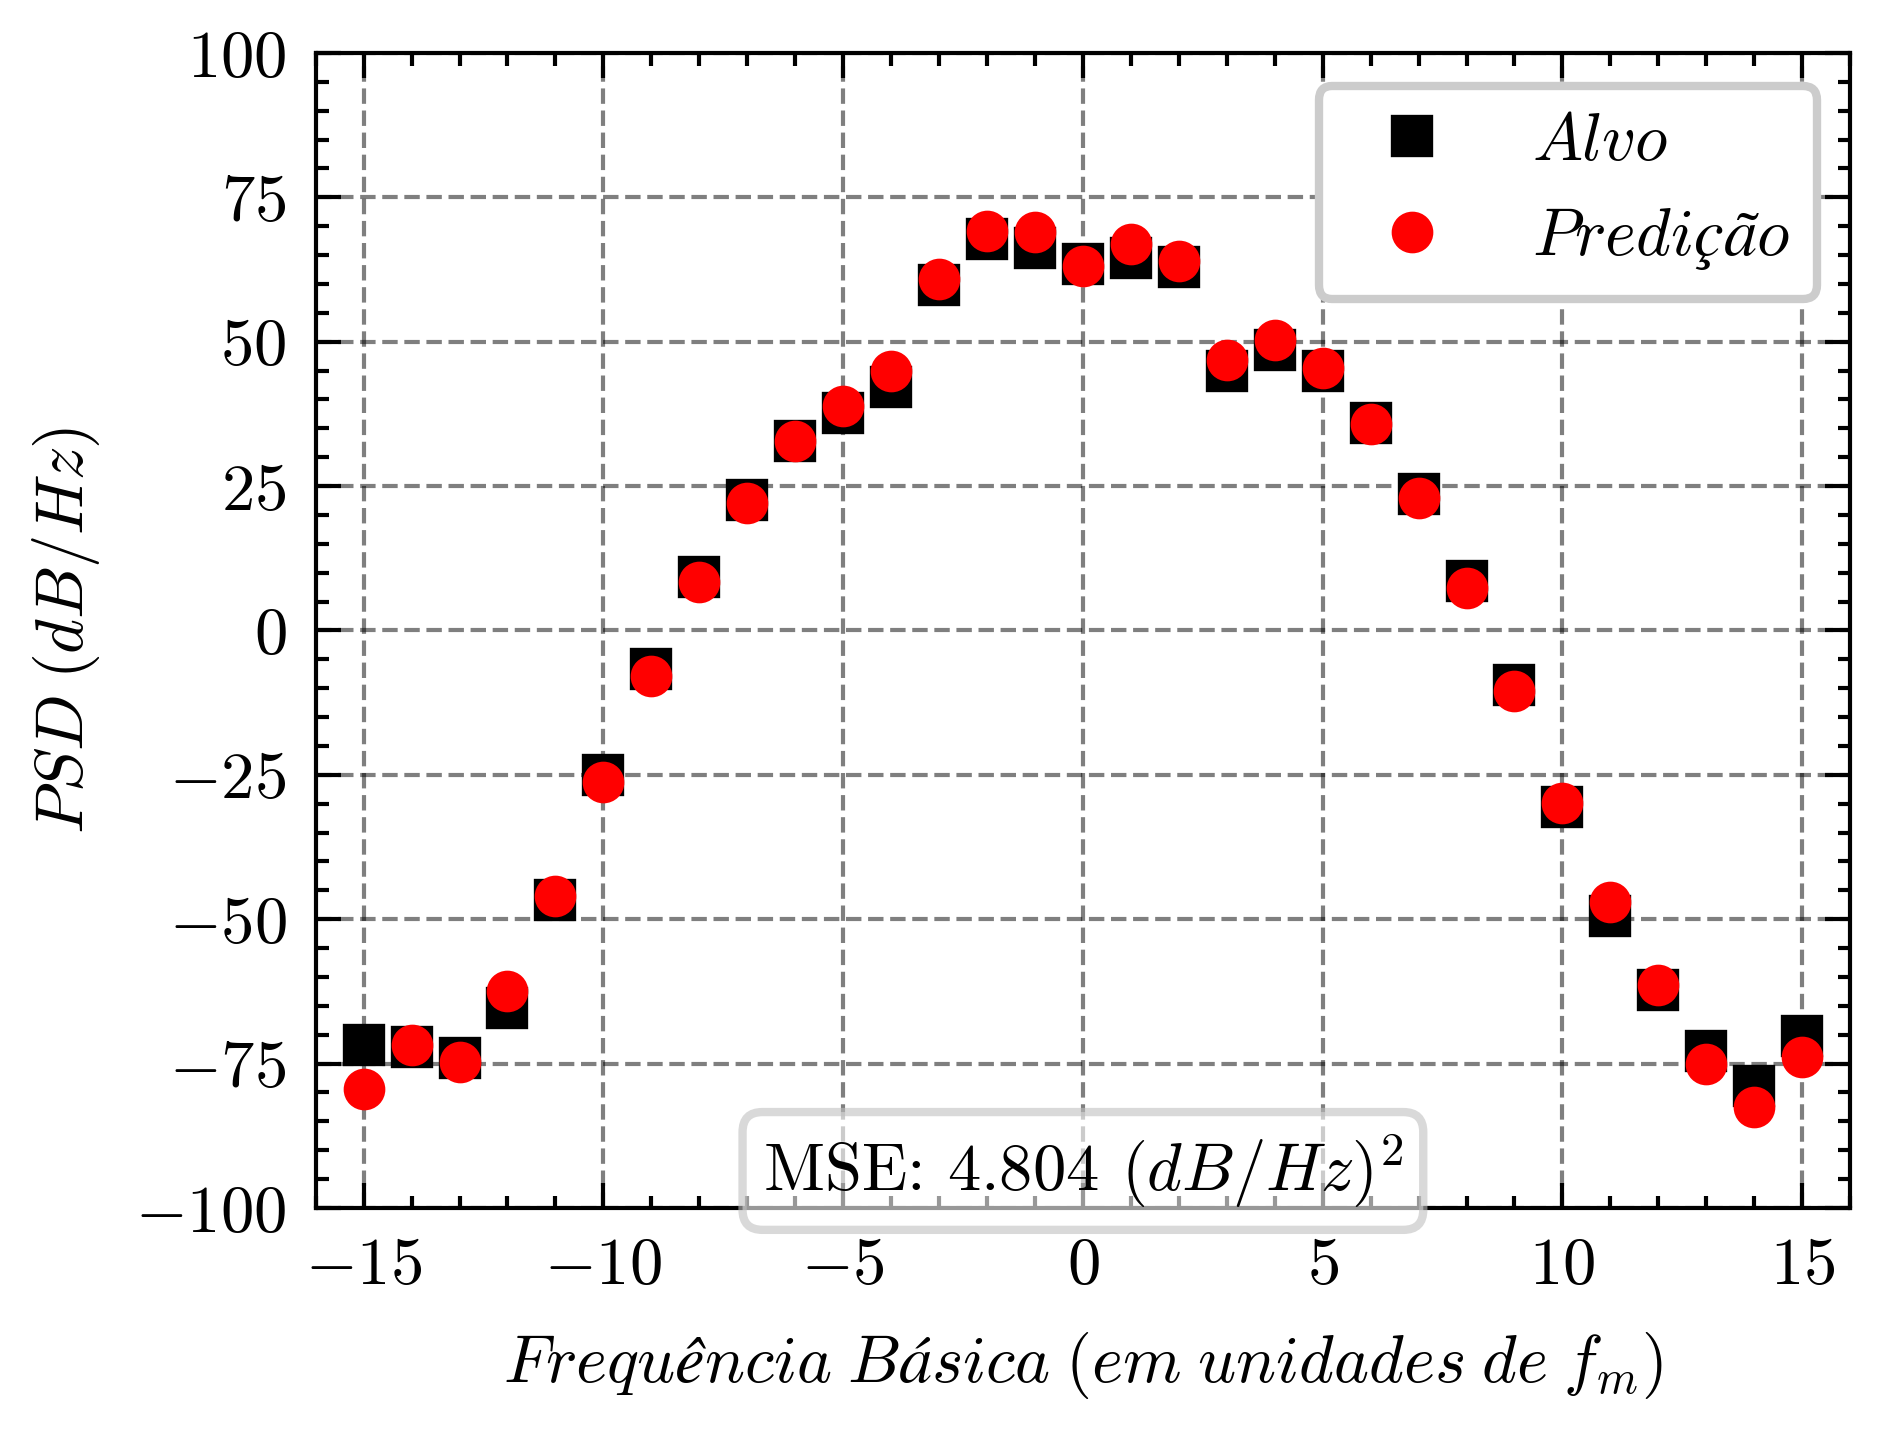

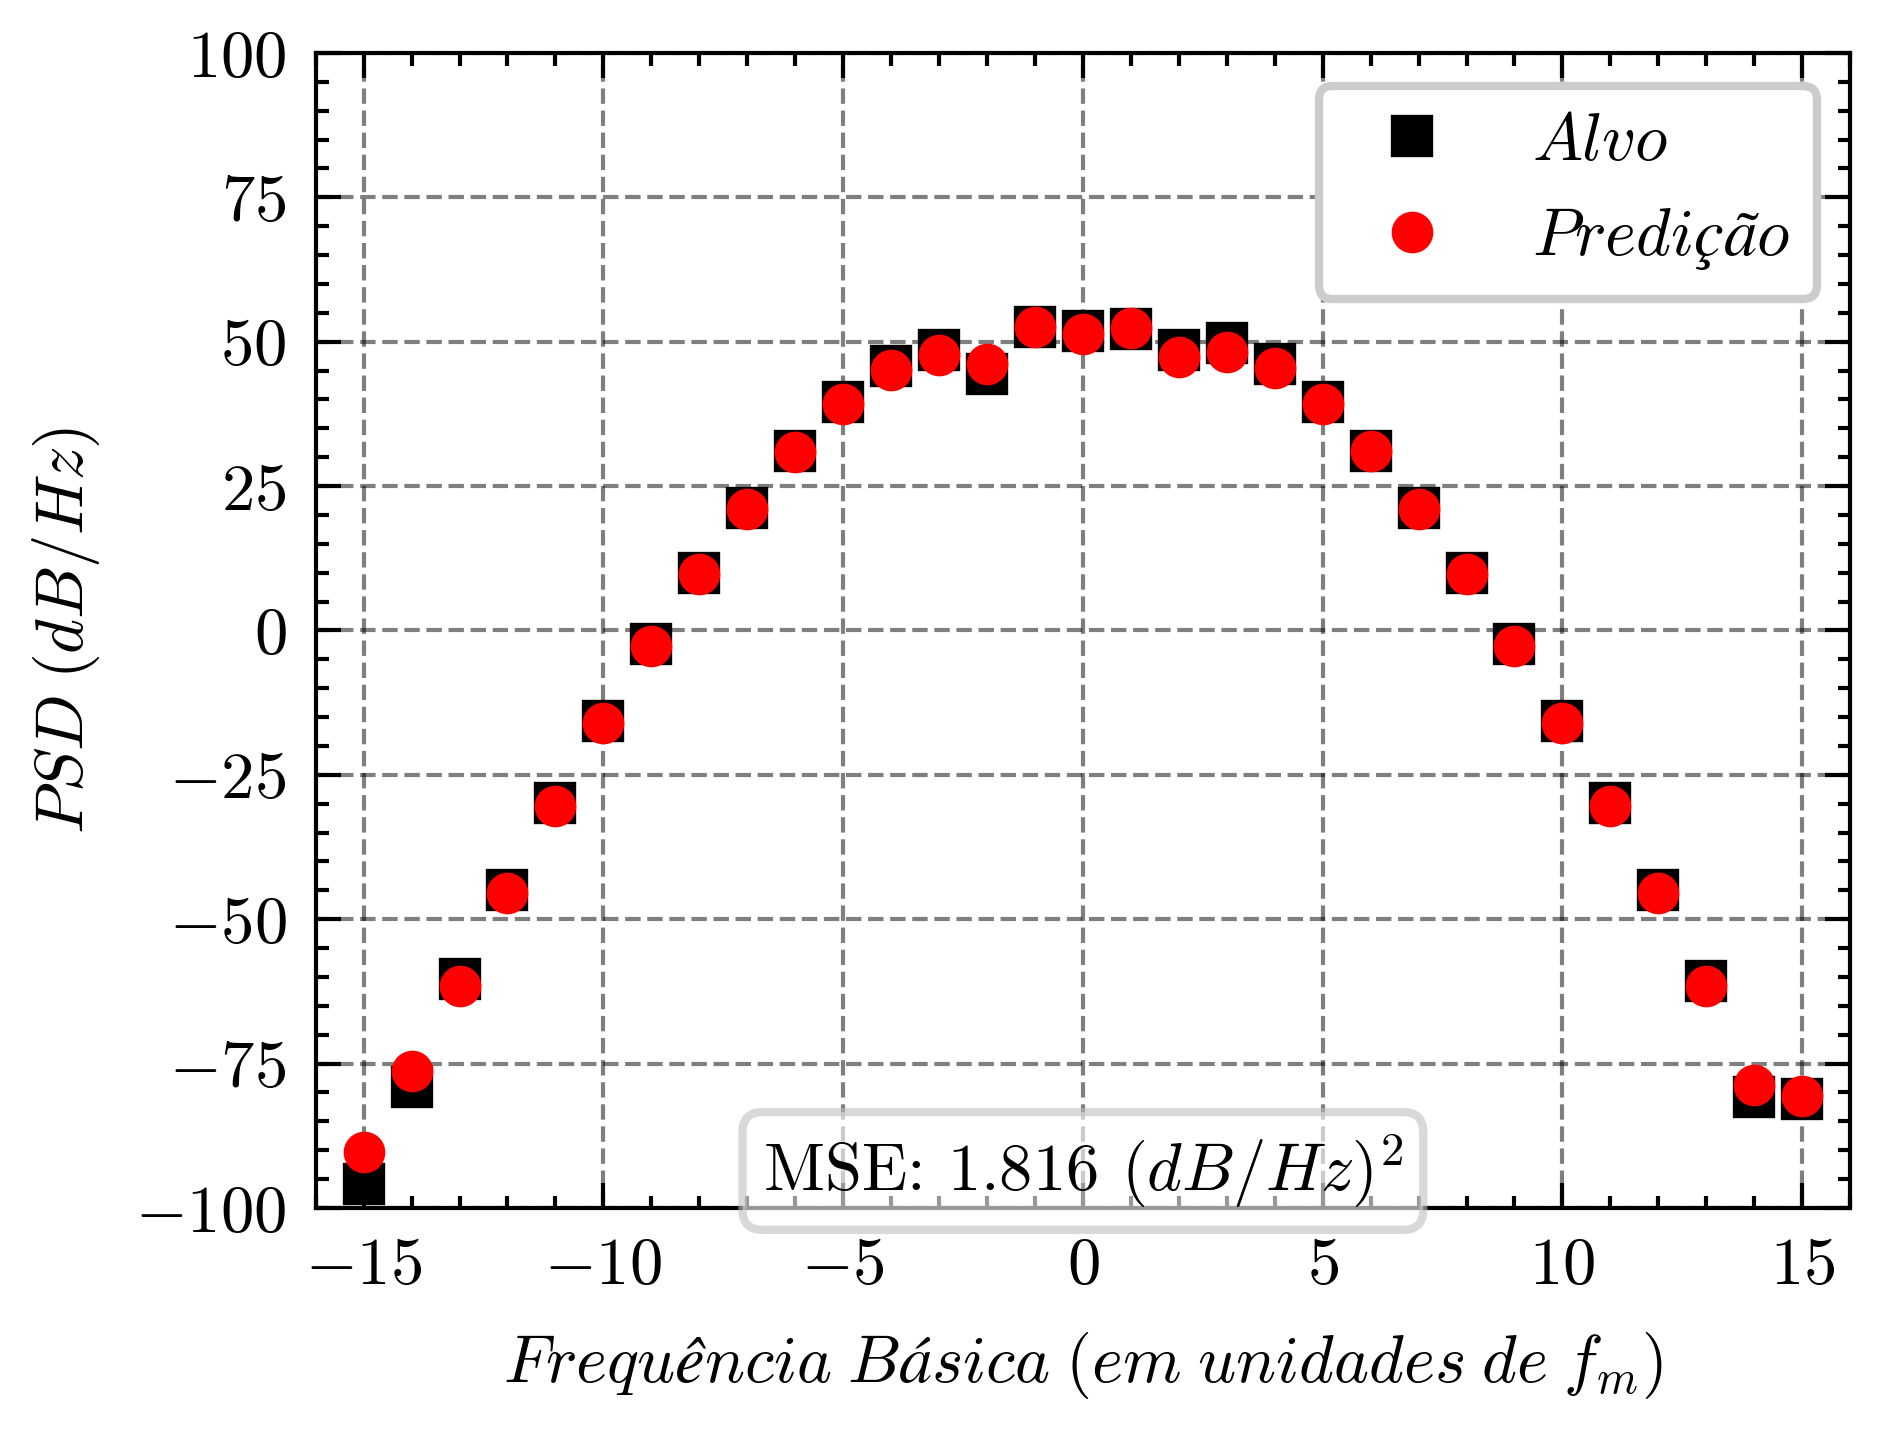

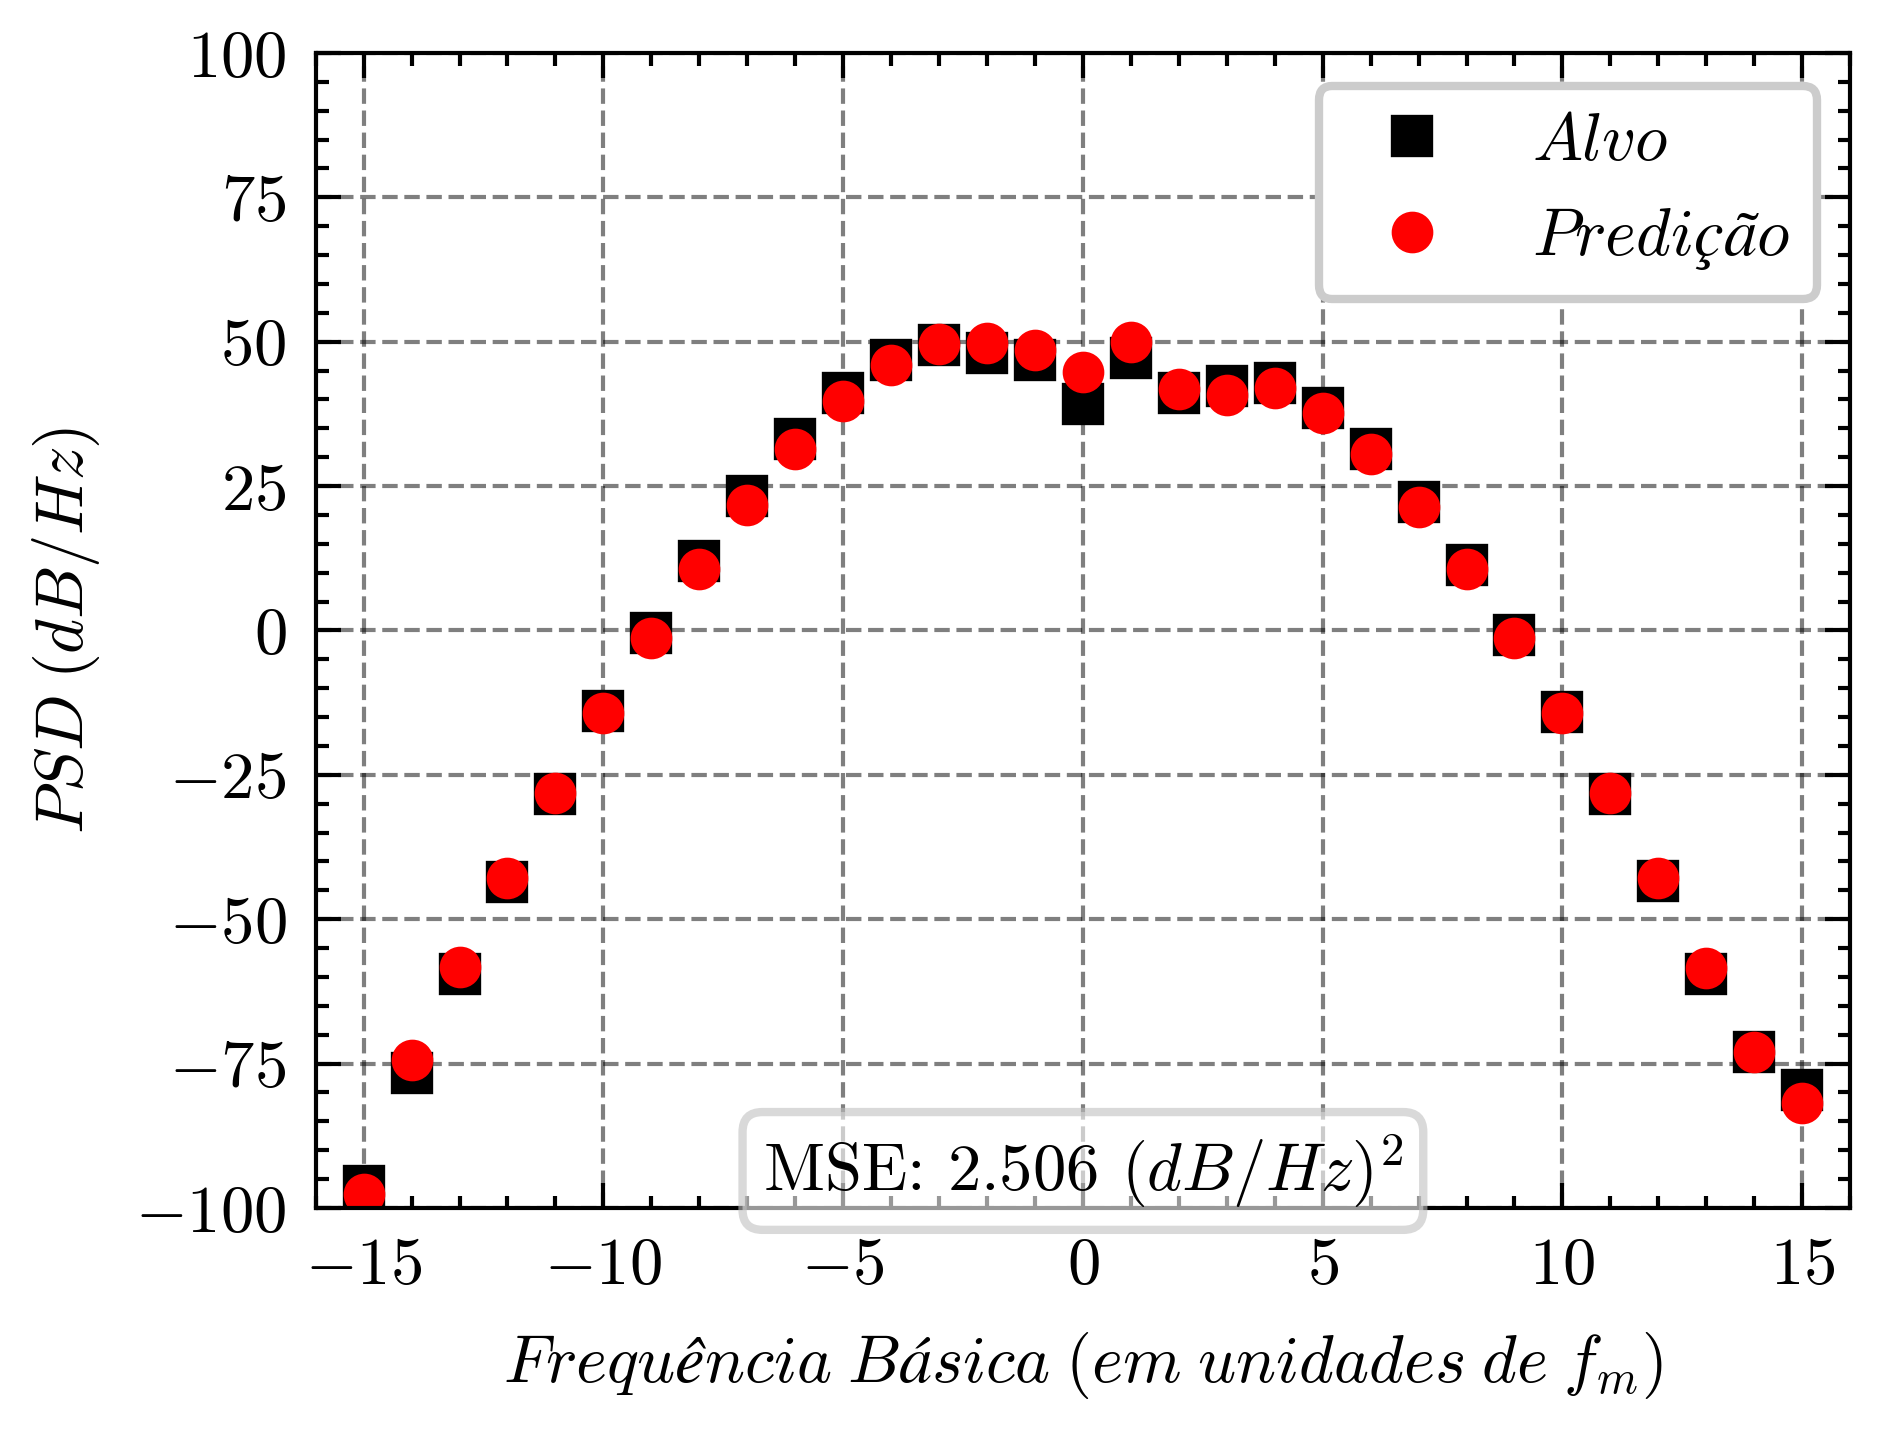

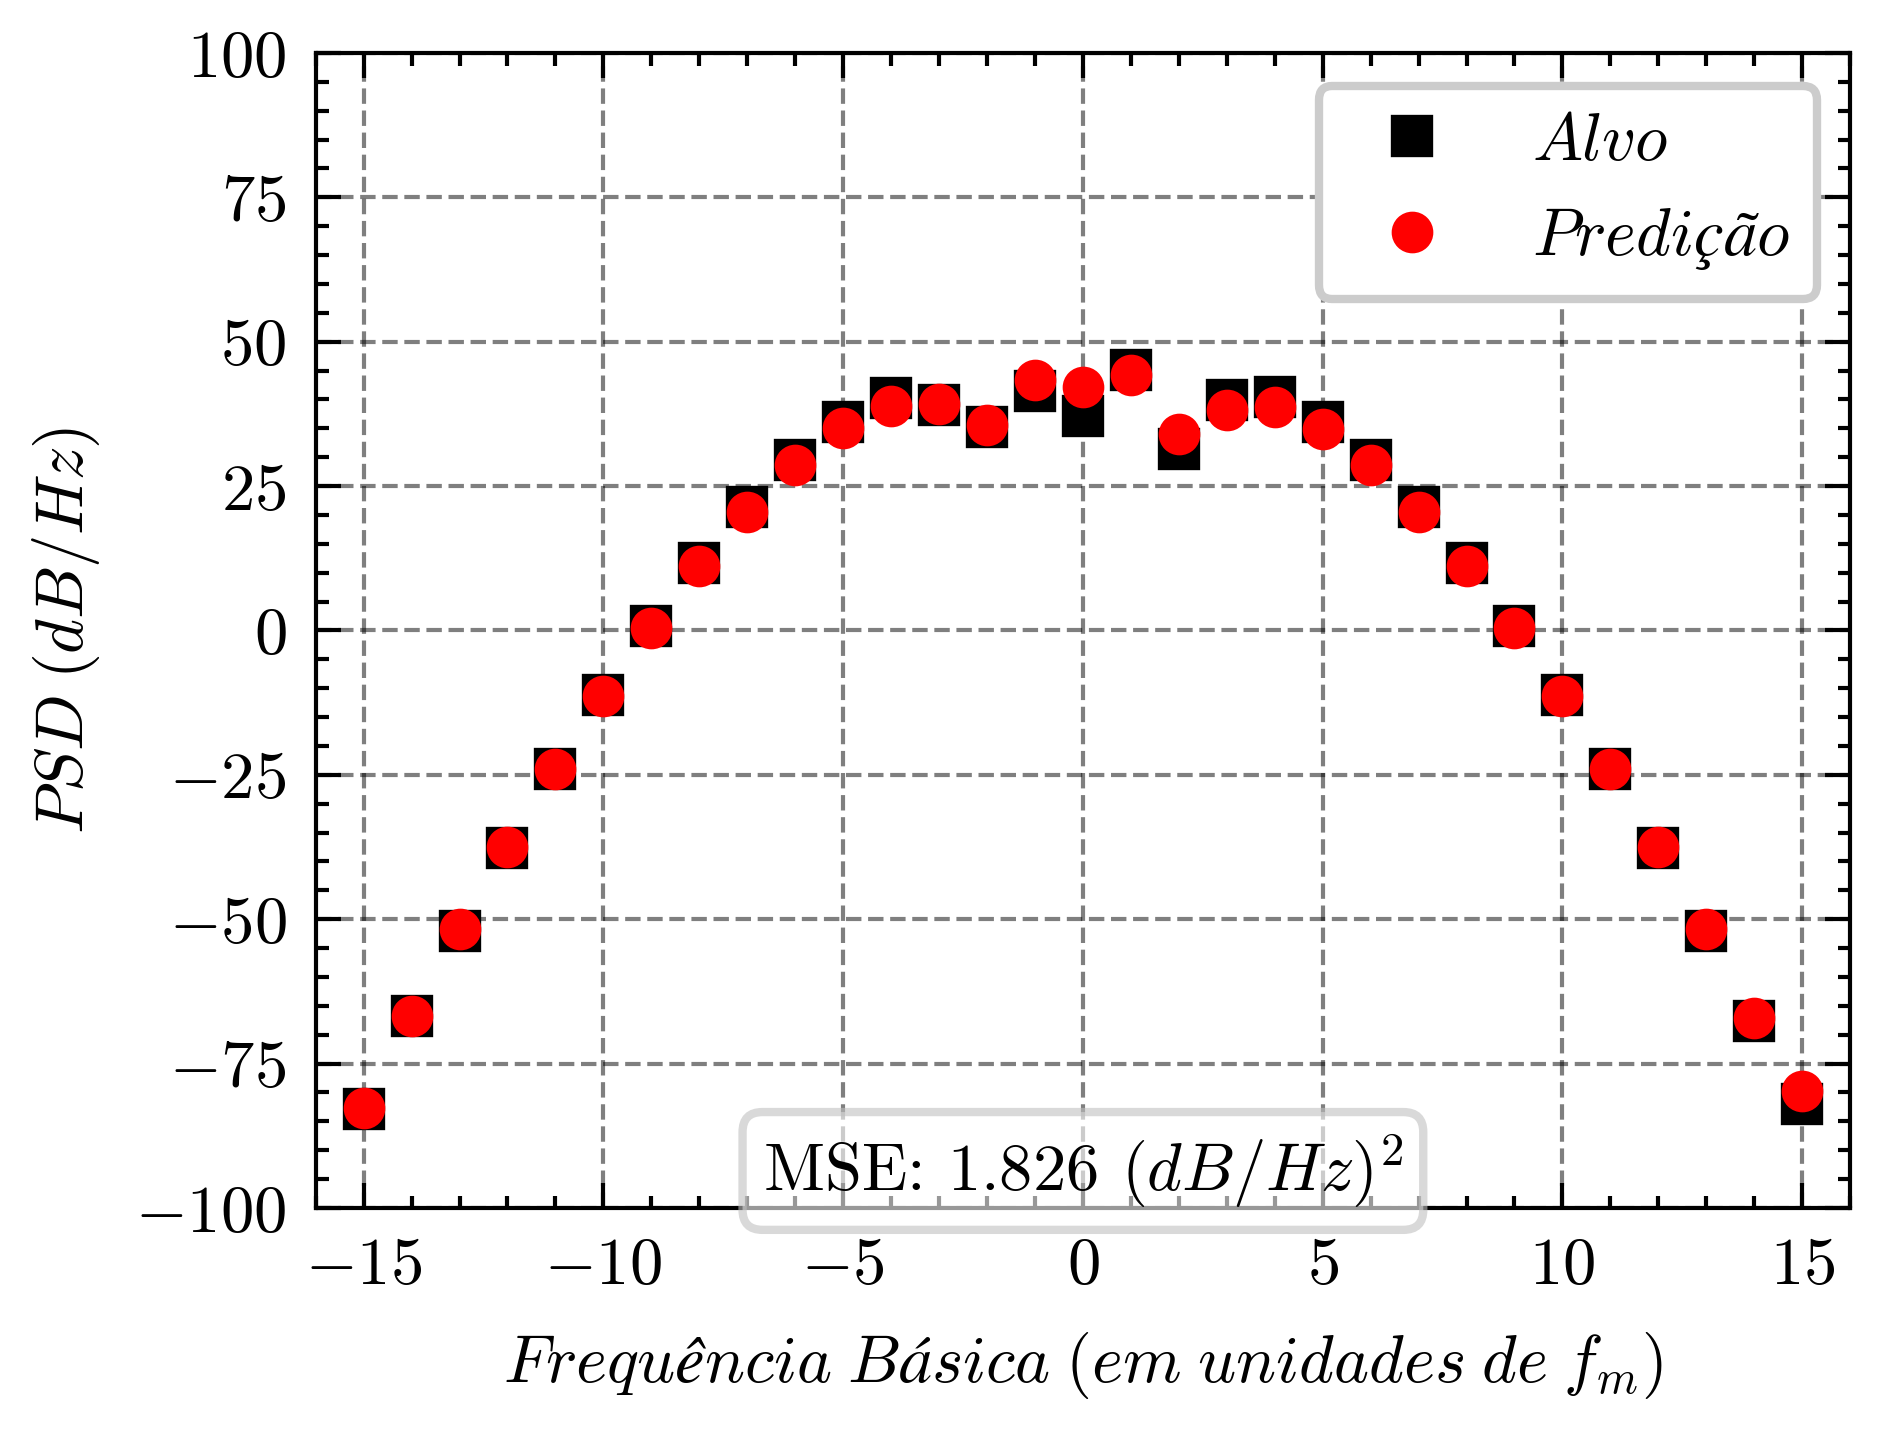

In [ ]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse_DiffGen("test", test_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(5, targets.shape[0])):

    #inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args).to(device)
    inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0).to("cpu"), ofc_args.t, ofc_args.Rs, ofc_args.Vpi, ofc_args.NFFT, ofc_args.Fa, ofc_args.SpS, ofc_args.n_peaks).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks) * train_loader.dataset.zero_mean
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i]).unsqueeze(0)
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    title = ''
    figname = "figures/inv_analitical/" + f"inv_analitical_sample_{i+1}.png"
    
    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title, ylim = (-100,100))

# <a id='toc3_'></a>[Bayesian Optimization](#toc0_)

In [ ]:
#!pip install bayesian-optimization

In [18]:
from bayes_opt import BayesianOptimization
import pickle

#https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_08_4_bayesian_hyperparameter_opt.ipynb

## <a id='toc3_1_'></a>[Forward Network](#toc0_)

In [ ]:
PATIENCE = 30
NUM_EPOCHS = 100
epoch_min = 15

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

def evaluate_forward_network(learning_rate:float = 0.0001 , n_layers:int = 4, n_neurons_per_layer:int = 150, batch_size:int = 100):

    #n_neurons_per_layer = round(n_neurons_per_layer)
    #n_layers = round(n_layers)
    batch_size = round(batch_size)
    architecture = [n_inputs] + [n_neurons_per_layer]*n_layers + [n_outputs]
    
    model = FrequencyCombNet(architecture).to(device)
    criterion = nn.MSELoss() # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):

        # Training phase
        run_one_epoch_forward("train", train_loader, model, criterion, device, optimizer)

        # Validation phase
        avg_val_loss, _, _ = run_one_epoch_forward("val", val_loader, model, criterion, device)

        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(architecture, f"n_epochs: {epoch}")

    return -avg_val_loss

In [ ]:
# #grid search on learning rate

#lr_values = np.linspace(0.1, 0.00001, 101)
lr_values = np.logspace(-6, -1, num = 21)

min_loss = 1
loss = np.zeros(lr_values.size)

for i in range(lr_values.size):
    print(f"\n{i}.Learning Rate: {lr_values[i]}", end = " ")
    loss[i] = -evaluate_forward_network(learning_rate = lr_values[i])
    print(f"Loss: {loss[i]}", end = " ")
    if min_loss > loss[i]:
        min_loss = loss[i]
        best_lr = lr_values[i]
        print("BEST\n")

In [62]:
lr_values[np.argmin(-loss)]

0.0017782794100389228

(0.0, 0.0005)

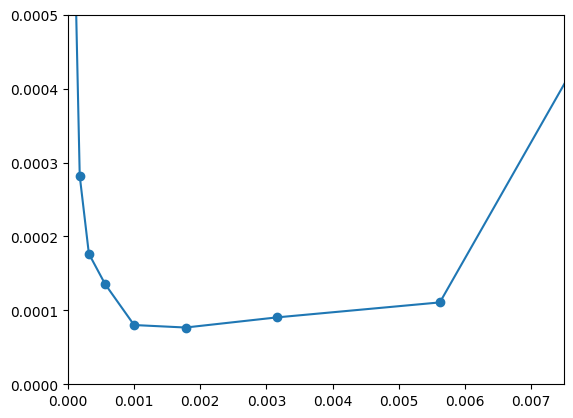

In [63]:
plt.plot(lr_values, -loss, "o-")
plt.xlim(0, 0.0075)
plt.ylim(0,0.0005)

In [59]:
# Bounded region of parameter space
pbounds = {'learning_rate': (1e-6, 1e-1),
           'n_layers': (3, 8),
           'n_neurons_per_layer': (128, 256),
           'batch_size': (64, 256)
           }

bayesian_optimizer_forward = BayesianOptimization(
    f=evaluate_forward_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [60]:
bayesian_optimizer_forward.maximize(init_points=10, n_iter=20)

|   iter    |  target   | batch_... | learni... | n_layers  | n_neur... |
-------------------------------------------------------------------------
[5, 167, 167, 167, 9] n_epochs: 57
| 1         | -0.002086 | 144.1     | 0.07203   | 3.001     | 166.7     |
[5, 172, 172, 172, 172, 9] n_epochs: 56
| 2         | -0.000555 | 92.18     | 0.009235  | 3.931     | 172.2     |
[5, 216, 216, 216, 216, 216, 9] n_epochs: 48
| 3         | -0.002309 | 140.2     | 0.05388   | 5.096     | 215.7     |
[5, 214, 214, 214, 9] n_epochs: 36
| 4         | -0.002764 | 103.3     | 0.08781   | 3.137     | 213.8     |
[5, 153, 153, 153, 153, 9] n_epochs: 37
| 5         | -0.003563 | 144.1     | 0.05587   | 3.702     | 153.4     |
[5, 217, 217, 217, 217, 217, 9] n_epochs: 63
| 6         | -0.003561 | 217.7     | 0.09683   | 4.567     | 216.6     |
[5, 133, 133, 133, 9] n_epochs: 77
| 7         | -0.003538 | 232.3     | 0.08946   | 3.425     | 133.0     |
[5, 182, 182, 182, 9] n_epochs: 85
| 8         | -0.003558 

In [61]:
import pandas as pd

bayesian_optimizer_res = [{"target": i["target"], **i["params"]} for i in bayesian_optimizer_forward.res]
bayesian_optimizer_res = [{"target": i["target"], "batch_size": round(i["batch_size"]), "learning_rate": i["learning_rate"], "n_layers": round(i["n_layers"]), "n_neurons_per_layer": round(i["n_neurons_per_layer"])} for i in bayesian_optimizer_res]

# Convert the optimization history to a DataFrame
optimization_history = pd.DataFrame(bayesian_optimizer_res).sort_values(by='target', ascending=False)
display(optimization_history.head(30))

target  batch_size  learning_rate  n_layers  n_neurons_per_layer
24 -0.000455         114       0.002184         4                  210
14 -0.000494         134       0.002241         4                  252
1  -0.000556          92       0.009235         4                  172
29 -0.001284         221       0.016354         3                  149
28 -0.001294          93       0.020427         6                  240
19 -0.001372         140       0.019419         3                  172
9  -0.001748         196       0.083463         3                  224
26 -0.001933          99       0.027178         7                  211
25 -0.001952         102       0.040038         6                  137
0  -0.002086         144       0.072033         3                  167
2  -0.002309         140       0.053882         5                  216
3  -0.002764         103       0.087812         3                  214
16 -0.002990         252       0.027042         7                  185
17 -0.003311         126       0.063579         5                  224
6  -0.003538         232       0.089461         3                  133
13 -0.003549          68       0.080788         8                  218
18 -0.003557         123       0.067666         6                  168
7  -0.003558          97       0.087814         3                  182
12 -0.003558         184       0.022323         8                  231
21 -0.003559         128       0.048480         5                  233
5  -0.003561         218       0.096826         5                  217
8  -0.003561         248       0.053317         6                  168
15 -0.003562         255       0.032518         7                  134
4  -0.003563         144       0.055869         4                  153
27 -0.003563          90       0.050785         7                  201
11 -0.003564         149       0.041348         6                  223
22 -0.003564         109       0.044701         6                  249
20 -0.003565          66       0.055021         4                  189
10 -0.003567          92       0.053407         4                  173
23 -0.003575          87       0.055054         5                  147

In [62]:
best_case = bayesian_optimizer_forward.max["params"]

print("Batch_size: ", round(best_case["batch_size"]))
print("Learning Rate: ", best_case["learning_rate"])
print("Architecture: ", [n_outputs] + [round(best_case["n_neurons_per_layer"])]*round(best_case["n_layers"]) + [n_inputs])

Batch_size:  114
Learning Rate:  0.002184363697298048
Architecture:  [9, 210, 210, 210, 210, 5]


## <a id='toc3_2_'></a>[Inverse Network](#toc0_)

In [ ]:
PATIENCE = 30
NUM_EPOCHS = 100
epoch_min = 15

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

forward_net_name = 'model_5_128_256_256_128_9_ddmzm_100k_samples_FalseZeroMean_batch_size_110'
forward_net_path = "saved_data/models/" + forward_net_name + ".pth"
model_dict_data = torch.load(forward_net_path, map_location=torch.device(device), weights_only=False)
forward_architecture = get_architecture(model_dict_data)
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(model_dict_data["model_state_dict"])  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases


In [ ]:

def evaluate_inverse_network(learning_rate:float = 0.001 , n_layers:int = 3, n_neurons_per_layer:int = 300 , batch_size_p:float = 8):

    #n_neurons_per_layer = round(n_neurons_per_layer)
    #n_layers = round(n_layers)
    #batch_size = round(2**batch_size_p)

    # Create an inverse model
    #inverse_architecture = [n_outputs] + [n_neurons_per_layer]*n_layers + [n_inputs]
    inverse_architecture = [n_outputs] + [128,256,256,128] + [n_inputs]
    batch_size = 110
    inverse_net = FrequencyCombNet(inverse_architecture).to(device)
    
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error

    # Optimizer
    inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
            
        # Training phase
        run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)

        # Validation phase
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
        
        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -avg_val_loss


In [ ]:

def evaluate_inverse_network2(learning_rate:float = 0.0001 , n_layers:int = 6, batch_size_p:float = 6.5):

    N = 600000 # Quantity of net parameters

    #n_layers should be > 1
    a = (n_layers-1)
    b = (n_layers+n_inputs+n_outputs)
    c = (n_outputs-N)
    n_neurons_per_layer = round((-b + np.sqrt(b**2 - 4*a*c))/(2*a))
    
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)

    # Create an inverse model
    inverse_architecture = [n_outputs] + [n_neurons_per_layer]*n_layers + [n_inputs]
    inverse_net = FrequencyCombNet(inverse_architecture).to(device)
    
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error

    # Optimizer
    inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
            
        # Training phase
        run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)

        # Validation phase
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
        
        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -avg_val_loss



In [ ]:
# #grid search on learning rate

#lr_values = np.linspace(0.1, 0.00001, 101)
lr_values = np.logspace(-6, -1, num = 21)

min_loss = 1
loss = np.zeros(lr_values.size)

for i in range(lr_values.size):
    print(f"\n{i}.Learning Rate: {lr_values[i]}", end = " ")
    loss[i] = -evaluate_inverse_network(learning_rate = lr_values[i])
    print(f"Loss: {loss[i]}", end = " ")
    if min_loss > loss[i]:
        min_loss = loss[i]
        best_lr = lr_values[i]
        print("BEST\n")

In [33]:
lr_values[loss.argmin()]

0.0001

In [ ]:
# Bounded region of parameter space
pbounds = {'learning_rate': (0.0, 0.0001),
           'n_layers': (3, 6),
           'n_neurons_per_layer': (128, 512),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_inverse = BayesianOptimization(
    f=evaluate_inverse_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)


#with open('bayes_opt_state_inv.pkl', 'rb') as f:
#    bayesian_optimizer_inverse = pickle.load(f)

In [ ]:
bayesian_optimizer_inverse.maximize(init_points=0, n_iter=20)

In [ ]:
# Bounded region of parameter space
pbounds2 = {'learning_rate': (0.0, 0.0001),
           'n_layers': (3, 6),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_inverse = BayesianOptimization(
    f=evaluate_inverse_network2,
    pbounds=pbounds2,
    verbose=2,
    random_state=1,
)

In [ ]:
bayesian_optimizer_inverse.maximize(init_points=10, n_iter=20)

In [ ]:
import pandas as pd

bayesian_optimizer_inverse_res = [{"target": i["target"], **i["params"]} for i in bayesian_optimizer_inverse.res]
bayesian_optimizer_inverse_res = [{"target": i["target"], "batch_size": round(2**i["batch_size_p"]), "learning_rate": i["learning_rate"], "n_layers": round(i["n_layers"]), "n_neurons_per_layer": round(i["n_neurons_per_layer"])} for i in bayesian_optimizer_inverse_res]

# Convert the optimization history to a DataFrame
optimization_history = pd.DataFrame(bayesian_optimizer_inverse_res).sort_values(by='target', ascending=False)
display(optimization_history.head(30))

In [ ]:
#save optimizer state checkout to load and continue the optimization later
with open('bayes_opt_state_inv2.pkl', 'wb') as f:
    pickle.dump(bayesian_optimizer_inverse, f)

In [ ]:
best_case = bayesian_optimizer_inverse.max["params"]
print("Batch_size: ", round(2**best_case["batch_size_p"]))
print("Learning Rate: ", best_case["learning_rate"])
print("Architecture: ", [n_outputs] + [round(best_case["n_neurons_per_layer"])]*round(best_case["n_layers"]) + [n_inputs])

## <a id='toc3_3_'></a>[Inverse Network - Differentiable OFC Generator](#toc0_)

In [ ]:
PATIENCE = 40
NUM_EPOCHS = 100
epoch_min = 15

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

def evaluate_inverse_network_DiffGen(learning_rate:float = 0.001 , n_layers:int = 3, n_neurons_per_layer:int = 300 , batch_size_p:float = 8):

    n_neurons_per_layer = round(n_neurons_per_layer)
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)

    # Create an inverse model
    inverse_architecture = [n_outputs] + [n_neurons_per_layer]*n_layers + [n_inputs]
    inverse_net = FrequencyCombNet(inverse_architecture).to(device)
    
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error

    # Optimizer
    inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
            
        # Training phase
        run_one_epoch_inverse_DiffGen("train", train_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device, inv_optimizer)

        # Validation phase
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse_DiffGen("val", val_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device)
                
        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -avg_val_loss # last value

In [ ]:
#grid search on learning rate

lr_values = np.linspace(0.1, 0.00001, 101)

min_loss = 1
loss = np.zeros(lr_values.size)

for i in range(lr_values.size):
    print(f"{i}.Learning Rate: {lr_values[i]}")
    loss[i] = evaluate_inverse_network_DiffGen(lr_values[i])

    if min_loss > loss[i]:
        min_loss = loss[i]
        best_lr = lr_values[i]
        print("best")

In [20]:
# Bounded region of parameter space
pbounds = {'learning_rate': (0.0, 0.001),
           'n_layers': (3, 8),
           'n_neurons_per_layer': (128, 512),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_inverse_DiffGen = BayesianOptimization(
    f=evaluate_inverse_network_DiffGen,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)


#with open('bayes_opt_state_inv_diffgen.pkl', 'rb') as f:
#    bayesian_optimizer_inverse_DiffGen = pickle.load(f)

In [22]:
bayesian_optimizer_inverse_DiffGen.maximize(init_points=10, n_iter=70)

|   iter    |  target   | batch_... | learni... | n_layers  | n_neur... |
-------------------------------------------------------------------------
[11, 244, 244, 244, 7] n_epochs: 100
| 1         | -0.000194 | 7.668     | 0.0007203 | 3.001     | 244.1     |
[11, 261, 261, 261, 261, 7] n_epochs: 100
| 2         | -0.000129 | 6.587     | 9.234e-05 | 3.931     | 260.7     |
[11, 391, 391, 391, 391, 391, 7] n_epochs: 80
| 3         | -0.000204 | 7.587     | 0.0005388 | 5.096     | 391.1     |
[11, 385, 385, 385, 7] n_epochs: 52
| 4         | -0.000313 | 6.818     | 0.0008781 | 3.137     | 385.5     |
[11, 204, 204, 204, 204, 7] n_epochs: 74
| 5         | -0.000234 | 7.669     | 0.0005587 | 3.702     | 204.1     |
[11, 394, 394, 394, 394, 394, 7] n_epochs: 100
| 6         | -0.000204 | 9.203     | 0.0009683 | 4.567     | 393.9     |
[11, 143, 143, 143, 7] n_epochs: 53
| 7         | -0.000283 | 9.506     | 0.0008946 | 3.425     | 143.0     |
[11, 290, 290, 290, 7] n_epochs: 67
| 8         |

In [24]:
import pandas as pd

bayesian_optimizer_inverse_res = [{"target": i["target"], **i["params"]} for i in bayesian_optimizer_inverse_DiffGen.res]
bayesian_optimizer_inverse_res = [{"target": i["target"], "batch_size": round(2**i["batch_size_p"]), "learning_rate": i["learning_rate"], "n_layers": round(i["n_layers"]), "n_neurons_per_layer": round(i["n_neurons_per_layer"])} for i in bayesian_optimizer_inverse_res]

# Convert the optimization history to a DataFrame
optimization_history = pd.DataFrame(bayesian_optimizer_inverse_res).sort_values(by='target', ascending=False)

In [25]:
display(optimization_history.head(30))

target  batch_size  learning_rate  n_layers  n_neurons_per_layer
109 -0.000116          80       0.000178         6                  290
126 -0.000117         181       0.000163         7                  493
107 -0.000117         383       0.000371         7                  241
47  -0.000123          92       0.000041         6                  258
89  -0.000125         781       0.000293         5                  481
25  -0.000129         119       0.000248         6                  389
1   -0.000130          96       0.000092         4                  261
42  -0.000132         381       0.000205         5                  285
94  -0.000135         376       0.000360         8                  159
122 -0.000137         244       0.000427         7                  380
59  -0.000140         574       0.000585         5                  458
91  -0.000140         965       0.000404         7                  399
58  -0.000141         790       0.000533         7                  447
95  -0.000142         328       0.000402         7                  219
130 -0.000146         715       0.000831         4                  345
119 -0.000149         392       0.000409         5                  173
52  -0.000150         610       0.000591         6                  351
82  -0.000150         142       0.000130         3                  389
38  -0.000150         111       0.000314         6                  330
78  -0.000151         308       0.000124         7                  406
71  -0.000152         609       0.000734         6                  441
101 -0.000153         110       0.000247         4                  439
60  -0.000159          79       0.000372         7                  494
12  -0.000160         173       0.000102         5                  436
23  -0.000163         113       0.000505         6                  130
132 -0.000164         147       0.000349         6                  387
61  -0.000167         262       0.000468         6                  188
110 -0.000168         731       0.000109         5                  274
72  -0.000170         125       0.000290         6                  260
40  -0.000172         694       0.000523         7                  423

In [ ]:
# save with pickle optimization state
with open('bayes_opt_state_inv_diffgen.pkl', 'wb') as f:
    pickle.dump(bayesian_optimizer_inverse_DiffGen, f)

# <a id='toc4_'></a>[Optuna Optimization](#toc0_)

In [9]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner, PercentilePruner
from optuna.visualization import plot_optimization_history, plot_param_importances

c:\Users\PC\Documents\GitHub\OFC_SBFoton\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <a id='toc4_1_'></a>[Forward Network](#toc0_)

In [ ]:

PATIENCE = 20
NUM_EPOCHS = 100
epoch_min = 15
MAX_NUM_PARAMS = 600000

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

def objective(trial):
    
    # Default values
    n_layers = 6
    activation = 'relu'
    dropout = 0.0
    use_bn = False
    init_weights = False
    use_gradient_clipping = False
    use_autocast = False
    use_scaler = False
    batch_size = 128
    optimizer_name = "Adam"
    lr =  8e-5
    weight_decay = 0.0

    # Hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 3, 8)
    #activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'selu'])
    dropout = trial.suggest_float('dropout_rate', 0.0, 0.3)
    #use_bn = trial.suggest_categorical('use_batchnorm', [True, False])
    #init_weights = trial.suggest_categorical('init_weights', [True, False])
    use_gradient_clipping = trial.suggest_categorical('use_gradient_clip', [True, False])
    use_autocast = trial.suggest_categorical('use_autocast', [True, False])
    use_scaler = trial.suggest_categorical('use_scaler', [True, False])
    #batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512])
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
    weight_decay=trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    
    #architecture = [n_inputs] + [trial.suggest_int('n_neurons', 128, 512)]*n_layers + [n_outputs]
    #architecture = [n_inputs] + [trial.suggest_categorical(f'n_neurons_layer_{i}', [32, 64, 128, 256]) for i in range (n_layers)] + [n_outputs]
    architecture = [n_inputs] + [trial.suggest_int(f'neuronsHL_{i}', 64, 320, step=32) for i in range(n_layers)] + [n_outputs]

    #Limite de parametros das camadas ocultas
    total_params = calc_num_params(architecture[1:-1])
    if total_params > MAX_NUM_PARAMS:  # Se ultrapassar o limite, descarta o trial
        raise optuna.TrialPruned()
    
    # Model
    model = FrequencyCombNet(
        architecture=architecture,
        activation=activation,
        use_batchnorm=use_bn,
        dropout_rate=dropout,
        init_weights=init_weights,
    ).to(device)
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Loop de treinamento com early stopping
    val_loss_min = float("inf")
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
        # Treino
        run_one_epoch_forward("train", train_loader, model, criterion, device, optimizer, use_gradient_clipping, use_autocast, use_scaler)

        # Validação
        avg_val_loss, _, _ = run_one_epoch_forward("val", val_loader, model, criterion, device, use_gradient_clipping=use_gradient_clipping, use_autocast = use_autocast, use_scaler = use_scaler)

        trial.set_user_attr(f"epoch_{epoch}_val_loss", avg_val_loss)

        # Pruning 
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping manual (patience)
        if avg_val_loss < val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    return avg_val_loss 

In [ ]:

# Configuração do estudo Optuna (TPE = Bayesian Optimization)
sampler = TPESampler(seed=42)  # Equivalente ao BayesianOptimization
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=10)  # Poda trials ruins
#pruner = PercentilePruner(25.0, n_startup_trials=5) # 

study = optuna.create_study(direction="minimize", 
                            #sampler=sampler, 
                            #pruner=pruner,
                            storage="sqlite:///optuna.db",  # Salva resultados em SQLite
                            study_name="for_net_opt_new",
                            load_if_exists=True,)

# Executar a otimização (equivalente ao maximize())
study.optimize(objective, n_trials=600)  # 30 trials (10 init_points + 20 n_iter)


In [ ]:
# Resultados
print("Melhores hiperparâmetros:", study.best_params)
print("Melhor val_loss:", study.best_value)

paramss = study.best_params
lr = paramss['lr']
architecture = [paramss[f'neuronsHL_{i}'] for i in range(paramss['n_layers'])]

print(f"\nlr: {lr}")
print(f"architecture (hidden layers): {architecture}")
print(f"number of parameters: {calc_num_params(architecture)}")

plot_optimization_history(study).show()
plot_param_importances(study).show()
optuna.visualization.plot_contour(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()
optuna.visualization.plot_slice(study).show()

Melhores hiperparâmetros: {'n_layers': 8, 'lr': 0.00031705632877650767, 'n_neurons_layer_0': 224, 'n_neurons_layer_1': 288, 'n_neurons_layer_2': 288, 'n_neurons_layer_3': 96, 'n_neurons_layer_4': 192, 'n_neurons_layer_5': 320, 'n_neurons_layer_6': 320, 'n_neurons_layer_7': 320}
Melhor val_loss: 6.639841364069961e-05

lr: 0.00031705632877650767
architecture (hidden layers): [224, 288, 288, 96, 192, 320, 320, 320]
number of parameters: 461600


## <a id='toc4_2_'></a>[Inverse Network](#toc0_)

In [ ]:

PATIENCE = 20
NUM_EPOCHS = 100
epoch_min = 15
MAX_NUM_PARAMS = 600000

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

forward_net_name = 'model_5_128_256_256_128_9_ddmzm_100k_samples_FalseZeroMean_batch_size_110'
forward_net_path = "saved_data/models/" + forward_net_name + ".pth"
model_dict_data = torch.load(forward_net_path, map_location=torch.device(device), weights_only=False)
forward_architecture = get_architecture(model_dict_data)
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(model_dict_data["model_state_dict"])  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

def objective(trial):
    
    # Default values
    n_layers = 6
    activation = 'relu'
    dropout = 0.0
    use_bn = False
    init_weights = False
    use_gradient_clipping = False
    use_autocast = False
    use_scaler = False
    batch_size = 128
    optimizer_name = "Adam"
    lr =  8e-5
    weight_decay = 0.0

    # Hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 3, 8)
    #activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'selu'])
    dropout = trial.suggest_float('dropout_rate', 0.0, 0.3)
    #use_bn = trial.suggest_categorical('use_batchnorm', [True, False])
    #init_weights = trial.suggest_categorical('init_weights', [True, False])
    use_gradient_clipping = trial.suggest_categorical('use_gradient_clip', [True, False])
    use_autocast = trial.suggest_categorical('use_autocast', [True, False])
    use_scaler = trial.suggest_categorical('use_scaler', [True, False])
    #batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512])
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
    weight_decay=trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    
    #architecture = [n_outputs] + [trial.suggest_int('n_neurons', 128, 512)]*n_layers + [n_inputs]
    #architecture = [n_outputs] + [trial.suggest_categorical(f'n_neurons_layer_{i}', [32, 64, 128, 256]) for i in range (n_layers)] + [n_inputs]
    architecture = [n_outputs] + [trial.suggest_int(f'neuronsHL_{i}', 64, 320, step=32) for i in range(n_layers)] + [n_inputs]


    #Limite de parametros das camadas ocultas
    total_params = calc_num_params(architecture[1:-1])
    if total_params > MAX_NUM_PARAMS:  # Se ultrapassar o limite, descarta o trial
        raise optuna.TrialPruned()
    
    # Model
    inverse_net = FrequencyCombNet(
        architecture=architecture,
        activation=activation,
        use_batchnorm=use_bn,
        dropout_rate=dropout,
        init_weights=init_weights,
    ).to(device)
    
    optimizer = getattr(torch.optim, optimizer_name)(inverse_net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Loop de treinamento com early stopping
    val_loss_min = float("inf")
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
        # Treino
        run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, optimizer, use_gradient_clipping, use_autocast, use_scaler)

        # Validação
        avg_val_loss, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device, use_gradient_clipping=use_gradient_clipping, use_autocast = use_autocast, use_scaler = use_scaler)

        trial.set_user_attr(f"epoch_{epoch}_val_loss", avg_val_loss)

        # Pruning 
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping manual (patience)
        if avg_val_loss < val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    return avg_val_loss 

In [ ]:

# Configuração do estudo Optuna (TPE = Bayesian Optimization)
sampler = TPESampler(seed=42)  # Equivalente ao BayesianOptimization
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=10)  # Poda trials ruins
#pruner = PercentilePruner(25.0, n_startup_trials=5) # 

study = optuna.create_study(direction="minimize", 
                            #sampler=sampler, 
                            #pruner=pruner,
                            storage="sqlite:///optuna.db",  # Salva resultados em SQLite
                            study_name="inv_net_opt_new",
                            load_if_exists=True,)

# Executar a otimização (equivalente ao maximize())
study.optimize(objective, n_trials=600)  # 30 trials (10 init_points + 20 n_iter)


In [ ]:
# Resultados
print("Melhores hiperparâmetros:", study.best_params)
print("Melhor val_loss:", study.best_value)

paramss = study.best_params
lr = paramss['lr']
architecture = [paramss[f'neuronsHL_{i}'] for i in range(paramss['n_layers'])]

print(f"\nlr: {lr}")
print(f"architecture (hidden layers): {architecture}")
print(f"number of parameters: {calc_num_params(architecture)}")

plot_optimization_history(study).show()
plot_param_importances(study).show()
#optuna.visualization.plot_contour(study).show()
#optuna.visualization.plot_parallel_coordinate(study).show()
#optuna.visualization.plot_slice(study).show()

## <a id='toc4_3_'></a>[Inverse Network - Differentiable OFC Generator](#toc0_)

In [10]:

PATIENCE = 20
NUM_EPOCHS = 100
epoch_min = 15
MAX_NUM_PARAMS = 600000

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

def objective(trial):
    
    # Default values
    n_layers = 6
    activation = 'relu'
    dropout = 0.0
    use_bn = False
    init_weights = False
    use_gradient_clipping = False
    use_autocast = True
    use_scaler = True
    batch_size = 128
    optimizer_name = "Adam"
    lr =  80e-6
    weight_decay = 0.0

    # Hyperparameters to optimize
    n_layers = trial.suggest_int('n_layers', 3, 8)
    #activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'selu'])
    #dropout = trial.suggest_float('dropout_rate', 0.0, 0.3)
    #use_bn = trial.suggest_categorical('use_batchnorm', [True, False])
    #init_weights = trial.suggest_categorical('init_weights', [True, False])
    #use_gradient_clipping = trial.suggest_categorical('use_gradient_clip', [True, False])
    #use_autocast = trial.suggest_categorical('use_autocast', [True, False])
    #use_scaler = trial.suggest_categorical('use_scaler', [True, False])
    #batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512])
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float('lr', 8e-6, 800e-6, log=True)
    #weight_decay=trial.suggest_float('weight_decay', 0.1e-6, 1000e-6, log=True)
    
    architecture = [n_outputs] + [trial.suggest_int('n_neurons', 128, 512)]*n_layers + [n_inputs] #flat architecture
    #architecture = [n_outputs] + [trial.suggest_categorical(f'n_neurons_layer_{i}', [32, 64, 128, 256]) for i in range (n_layers)] + [n_inputs]
    #architecture = [n_outputs] + [trial.suggest_int(f'neuronsHL_{i}', 100, 300, step=10) for i in range(n_layers)] + [n_inputs]


    #Limite de parametros das camadas ocultas
    total_params = calc_num_params(architecture[1:-1])
    if total_params > MAX_NUM_PARAMS:  # Se ultrapassar o limite, descarta o trial
        raise optuna.TrialPruned("Number of parameters exceeded the limit")
    
    # Model
    inverse_net = FrequencyCombNet(
        architecture=architecture,
        activation=activation,
        use_batchnorm=use_bn,
        dropout_rate=dropout,
        init_weights=init_weights,
    ).to(device)
    
    optimizer = getattr(torch.optim, optimizer_name)(inverse_net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Loop de treinamento com early stopping
    val_loss_min = float("inf")
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
        # Treino
        run_one_epoch_inverse_DiffGen("train", train_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device, optimizer, use_gradient_clipping, use_autocast, use_scaler)

        # Validação
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse_DiffGen("val", val_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device, use_gradient_clipping=use_gradient_clipping, use_autocast = use_autocast, use_scaler = use_scaler)

        # Pruning 
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():# and epoch > epoch_min:
            trial.set_user_attr(f"final_epoch", epoch)
            trial.set_user_attr(f"final_val_loss", avg_val_loss)
            raise optuna.TrialPruned(f"Pruned at epoch {epoch} with loss {avg_val_loss:.4f}")

        # Early stopping manual (patience)
        if avg_val_loss < val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            trial.set_user_attr(f"final_epoch", epoch)
            trial.set_user_attr(f"final_val_loss", avg_val_loss)
            break

    return avg_val_loss 

In [12]:

# Configuração do estudo Optuna (TPE = Bayesian Optimization)

sampler = TPESampler(seed=42, n_startup_trials=15)  

pruner = MedianPruner(n_startup_trials=20, # número mínimo de trials antes de começar a poda
                     n_warmup_steps=1, # número de epochs antes de começar a poda 
                     )  

#pruner = PercentilePruner(25.0, n_startup_trials=10) # 
#pruner = HyperbandPruner(min_resource=20, max_resource=100)

study = optuna.create_study(direction="minimize", 
                            sampler=sampler, 
                            #pruner=pruner,
                            study_name="inv_net_diffGen_opt1",
                            storage="sqlite:///optuna.db",  # Salva resultados em SQLite
                            load_if_exists=True,
                            )

[I 2025-05-21 23:59:12,079] A new study created in RDB with name: inv_net_diffGen_opt1


In [ ]:
# Executar a otimização 
study.optimize(objective, n_trials=30)

[I 2025-05-21 23:59:15,393] Trial 0 pruned. Number of parameters exceeded the limit


In [ ]:
study.optimize(objective, n_trials=300)


[I 2025-05-16 21:26:42,479] Trial 61 pruned. Pruned at epoch 1 with loss 0.0006
[I 2025-05-16 21:27:18,568] Trial 62 pruned. Pruned at epoch 3 with loss 0.0005
[I 2025-05-16 21:27:29,295] Trial 63 pruned. Pruned at epoch 1 with loss 0.0006
[I 2025-05-16 21:28:22,263] Trial 64 pruned. Pruned at epoch 5 with loss 0.0004
[I 2025-05-16 21:46:19,171] Trial 65 finished with value: 0.00022607431313557988 and parameters: {'n_layers': 3, 'lr': 7.958153355465907e-05, 'n_neurons': 274}. Best is trial 19 with value: 0.00014394214875287713.
[I 2025-05-16 21:55:38,639] Trial 66 finished with value: 0.0003131237894078677 and parameters: {'n_layers': 3, 'lr': 7.258749064955133e-05, 'n_neurons': 301}. Best is trial 19 with value: 0.00014394214875287713.
[I 2025-05-16 22:15:17,356] Trial 67 finished with value: 0.00029372666650352643 and parameters: {'n_layers': 5, 'lr': 0.0001973426105618741, 'n_neurons': 321}. Best is trial 19 with value: 0.00014394214875287713.
[I 2025-05-16 22:15:30,489] Trial 68 pr

In [ ]:
# Resultados
print("Melhores hiperparâmetros:", study.best_params)
print("Melhor val_loss:", study.best_value)

paramss = study.best_params
lr = paramss['lr']
#architecture = [paramss[f'neuronsHL_{i}'] for i in range(paramss['n_layers'])]
architecture = [n_outputs] + [paramss['n_neurons']]*paramss['n_layers'] + [n_inputs]

print(f"\nlr: {lr}")
print(f"architecture (hidden layers): {architecture}")
print(f"number of parameters: {calc_num_params(architecture)}")

plot_optimization_history(study).show()
plot_param_importances(study).show()
optuna.visualization.plot_contour(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()
optuna.visualization.plot_slice(study).show()
optuna.visualization.plot_intermediate_values(study).show()
optuna.visualization.plot_edf(study).show()


Melhores hiperparâmetros: {'n_layers': 5, 'lr': 0.00022037778398679663, 'n_neurons': 348}
Melhor val_loss: 0.00014394214875287713

lr: 0.00022037778398679663
architecture (hidden layers): [11, 348, 348, 348, 348, 348, 8]
number of parameters: 492776


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Coletar todos os trials válidos
df = study.trials_dataframe()

#drop lines where value is NaN
df = df.dropna(subset=['value'])

parametro = 'params_use_autocast'
#parametro = 'params_use_gradient_clip'
#parametro = 'params_use_batchnorm'
#parametro = 'params_init_weights' # False is better
#parametro = 'params_use_scaler'


# Separar trials que usaram o parametro e os que não usaram
df_param_True = df[df[parametro] == True]
df_param_False = df[df[parametro] == False]

percent_True = len(df_param_True) / len(df) * 100
percent_False = len(df_param_False) / len(df) * 100

# Plot
plt.figure()
#plt.scatter(df_param_False['number'], df_param_False['value'], label=f'{parametro}: False ({percent_False:.0f}%)', color='red')
plt.scatter(df_param_True['number'], df_param_True['value'], label=f'{parametro}: True ({percent_True:.0f}%)', color='blue')
plt.scatter(df_param_False['number'], df_param_False['value'], label=f'{parametro}: False ({percent_False:.0f}%)', color='red')

plt.xlabel('Trial Number')
plt.ylabel('Validation Loss')
plt.title(f'Validation Loss vs Trial Number ({parametro} ON/OFF)')
plt.legend()

# Boxplot para comparar a distribuição dos valores
plt.figure()
plt.boxplot([df_param_True['value'], df_param_False['value']], tick_labels=[f'{parametro}=True', f'{parametro}=False'], showfliers=True)
plt.ylabel('Validation Loss')
plt.title('Comparison of Loss Distributions')
plt.ylim(0, 0.004)

# <a id='toc5_'></a>[Other Auxiliar Figures](#toc0_)

In [ ]:
#plotting the first four Bessel funcions
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import jn


with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize=(3*0.8,2.4*0.8), dpi = 300)
    x = np.linspace(0, 20, 100)
    for n in range(4):
        plt.plot(x, jn(n, x), label=fr"$J_{n}(x)$", color = f"C{n}",lw =1.2)

    ax.legend()
    ax.autoscale(tight=True)
    ax.set_xlabel("$x$")
    ax.set_ylabel(r"$J_n(x)$")
    ax.set_xlim(0, 17)
    ax.set_ylim(-0.5,1.3)
    ax.set_yticks(np.arange(-0.4,1.4,0.4))
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
    fig.savefig("bessel_Jn", dpi=300)
    plt.show()
    plt.close()

In [ ]:
#plotting the power spectral density of a optical frequency comb generated using PM modulation

V1 = 10
Phase1 = 0
u1 = V1 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase1)
frequency_comb = pm(1, u1, 5)
#'''
params = [2,2,2,2,2,4,3,3]
params = [2,2,2,4,3,4,3,3]
V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2 = params

u1 = V1 * np.cos(2 * np.pi * ofc_args.Rs * ofc_args.t + Phase1)
u2 = V2 * np.cos(2 * np.pi * ofc_args.Rs * ofc_args.t + Phase2)
u3 = V3 * np.cos(2 * np.pi * ofc_args.Rs * ofc_args.t + Phase3)

P = 1e-3*10**(10/10) # 10 dBm
frequency_comb = P
frequency_comb =  pm(frequency_comb, u3, ofc_args.Vpi)
frequency_comb = mzm(frequency_comb, u1, ofc_args.Vpi, Vb1)
frequency_comb = mzm(frequency_comb, u2, ofc_args.Vpi, Vb2)
#'''

Pxx, freqs = get_psd_ByFFT(frequency_comb, ofc_args.Fa, ofc_args.NFFT) # Get the power spectrum of the frequency comb signal
log_Pxx = 10*np.log10(Pxx) # Convert the power spectrum to dB
indx = get_indx_peaks(log_Pxx, ofc_args.NFFT/ofc_args.SpS, ofc_args.n_peaks) 
peaks = log_Pxx[indx].tolist()
   
with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    ax.plot(freqs/ofc_args.Rs,log_Pxx,"g-", label='Optical Frequency Comb',lw = 1.3)
    ax.plot(freqs[indx]/ofc_args.Rs,peaks,"ko", label='Peaks', markersize=4)
    ax.autoscale(tight=True)
    
    ax.set_xlim(-10.9, 10.9)
    ax.set_ylim(-126, -82)
    #ax.set_ylim(-300, -82)
    ax.set_xlabel(r"$Frequência\; Básica\; (em\; unidades\; de\; f_m)$")
    ax.set_ylabel(r"$PSD\; (dB/Hz)$")

    #ax.yaxis.tick_right()
    #ax.yaxis.set_label_position("right")

    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

    #fig.savefig("ofc_pm_example", dpi=300)
    fig.savefig("ofc_peaks_example", dpi=300)
    plt.show()
    plt.close()
    

In [ ]:
Vpi = 2
Vdc = -2

Vmax = 4
Vmin = -4
V = np.linspace(Vmin, Vmax, 100)

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize=(5*0.8,2.4*0.8), dpi = 300)
    
    ax.plot(V/Vpi, mzm(1,V, Vpi, Vdc), label = r'$Campo$')
    ax.plot(V/Vpi, np.abs(mzm(1,V, Vpi, Vdc))**2, label = r'$Potência$')
    ax.plot(0, np.abs(mzm(1,0, Vpi, Vdc))**2, 'sr', markersize=4)
    ax.plot(Vpi/Vpi, np.abs(mzm(1,Vpi, Vpi, Vdc))**2, 'or', markersize=4)
    ax.autoscale(tight=True)
    
    ax.set_xlim([Vmin/Vpi, Vmax/Vpi])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel(r'$V (V_\pi)$')
    ax.set_ylabel(r'$Transmitância (a.u.)$')
    ax.legend()

    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
    fig.savefig("mzm_op", dpi=300)
    plt.show()
    plt.close()

In [ ]:
# i want to plot a graph with some point around a regression line to ilustrated de MSE error

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

np.random.seed(1)
x = np.linspace(0.5, 3.5, 6)
y = 4 + 2 * x + np.random.randn(6, 1).squeeze()

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    regress = linregress(x.squeeze(), y.squeeze())

    xx = np.linspace(0,4)
    ax.plot(xx, regress.intercept + regress.slope*xx, "r--")

    sig = [1, -1, -1, -1, 1,-1]
    for i in range(x.shape[0]):
        ax.plot([x[i], x[i]], [y[i], regress.intercept + regress.slope*x[i]], "k-",lw =1)
        #colocar um traço horizontal nas pontas de cada linha de erro
        traco = 0.05
        ax.plot([x[i]-traco, x[i]+traco], [regress.intercept + regress.slope*x[i], regress.intercept + regress.slope*x[i]], "k-",lw =1)
        ax.plot([x[i]-traco, x[i]+traco], [y[i]-0.15*sig[i], y[i]-0.15*sig[i]], "k-",lw =1)

    #no penultimo ponto colocar o texto y e y_hat, centralizado, negrito r"$\textbf{y}$" e r"$\textbf{\hat{y}}$"
    ax.text(x[-2], y[-2]+0.4, r'$y_i$', fontsize=10, ha='center')
    ax.text(x[-2], regress.intercept + regress.slope*x[-2]-0.8, r'$\hat{y}_i$', fontsize=10, ha='center')

    ax.plot(x, y, "b.")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.autoscale(tight=True)
    ax.set_ylim(4, 12.5)

    



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
x = np.linspace(0,5,10)
y = 1.5 * x + 4
yerr = 2*np.abs(np.random.randn(10, 1).squeeze())


upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    ax.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits)
    ax.plot(x,y, "r-", lw =2)
    ax.plot(x,y, "r-", lw =2)
    ax.show()
    ax.close()



In [ ]:
# i want to plot a graph with some point around a regression line to ilustrated de MSE error using errror bars

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

np.random.seed(1)
x = np.linspace(0.5, 3.5, 5)
y = 4 + 2 * x + np.random.randn(5, 1).squeeze()

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    regress = linregress(x.squeeze(), y.squeeze())
    
    xx = np.linspace(0,4)
    ax.plot(xx, regress.intercept + regress.slope*xx, "r--")
    ax.errorbar(x, y, yerr=0.2, fmt='o', color='b', ecolor='r', capsize=5)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.autoscale(tight=True)
    fig.savefig("regression_error", dpi=300)
    plt.show()
    plt.close()